### Materials and Methods


#### 3.1. Materials

Data for the seven metrics was accumulated from various open-source databases as listed in Fig 1. below.

In [1]:
# I'm working in a Python Virtual Environment, install the following packages into yours.

#!pip install missingno
#!pip install -U scikit-learn
#!pip install scipy
#!pip install seaborn
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install fancyimpute
#!pip install nbconvert[qtpdf]


# Specifically for Jupyter Notebooks

# !python3 -m pip install cite2c
# !python3 -m cite2c.install

In [2]:
# Importing the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats
from fancyimpute import KNN
from fancyimpute import IterativeImputer
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import skew

In [3]:
# The table of indicators
the_metrics = [
    ['Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Resilience', 'Resilience', 'Food Safety', 'Food Safety', 'Waste & Loss Reduction'],
    ['Non-Staple Food Energy', 'Shannon Diversity', 'Modified Functional Attribute Diversity', 'Nutrient Density Score', 'Population Share With Adequate Nutrients', 'Ecosystem Status', 'GHG Emissions', 'Net FreshWater Withdrawals', 'Energy Use', 'Land Use', 'Income Equality', 'Poverty Index', 'GFSI Food Availability Score', 'Food Affordability', 'Animal Health & Welfare', 'Community Rights', ' Child Labor', 'Gender Equity', 'Food Production Diversity', 'ND-GAIN Country Index', 'GFSI Safety Score', 'Foodborne Disease Burden', 'Pre & Post-Consumer Food Loss'],
    ['Nutrients From Non-Staple Food', 'Nutrient Diversity in The Food System', 'Nutrient Diversity in The Food System', 'Nutrient Diversity in The Food System', 'Proportion of Population With Adequate Nutrients', 'Ecosystem Status', 'Eco-Efficiency', 'Eco-Efficiency', 'Eco-Efficiency', 'Eco-Efficiency', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Gender Equality', 'Extent of Child Labor', 'Respect for Community Rights', 'Animal Health & Welfare', "Nation's Vulnerability to Climate Change", "Shares of Agricultural Food Production in The Country", "Food Borne Disease Burden", "GFSI Food Safety", "Later"]
]

sources = [['FAOs Food Balance Sheets'], ['FAOs Food Balance Sheets'], ['FAOs Food Balance Sheets'],['FAOs Food Balance Sheets'], ['FAOSTATS'], ['Yale Center for Environmental Law and Policy'], ['United Nations Framework Convention on Climate Change'], ['Data Collections, NASA'], ['Data Collections, NASA'], ['Data Collections, NASA'], ['Global Food Security Index (GFSI)'], ['Global Food Security Index (GFSI)'], ['United Nations, 2021'], ['United Nations, 2021'], ['Global Gender Gap Report 2020'], ['ILO, 2020'], ['Environmental Democracy Index'], ['Not Measured (Insufficient Data)'], ["Notre Dame Global Adaptation Initiative"], ["FAOSTAT"], ["World Health Organisation (WHO)"], ["Global Food Security Index (GFSI)"], ["Later"]]


the_table = pd.DataFrame(sources,
                         index= the_metrics,
                         columns = ["Sources"]
                        )

the_table.index = the_table.index.rename(['The Metric', 'Indicators', 'What They Measure'])

the_table.style

#the_table.to_csv('The Metrics.csv')

In [4]:
# Building a data scaler for some of the indicators

def scaler(df, column) :
    """Scales the dataset to a 0-100 scale"""

    median_values = df[column].median()

    scaled_values = list()

    for i, val in df[[column]].iterrows():
        scaler = 100 * np.exp(np.log(0.5) * (val/median_values))

        scaled_values.append(scaler.values[0])

    df["Scaled Values"] = scaled_values

    return df

In [5]:
# Building the sampling function that will be used in all datasets

# Setting the seed for sampling function

np.random.seed(10)

## Metric 1: Food Nutrient Adequacy

### Indicator 1: Non-Staple Food Energy

In [6]:
# 1. Loading the 'Country_Groups' Data Set
size_of_economy = pd.read_csv('Country_Groups.csv', sep = ",", \
                  header = 0, usecols = ["Country","Income group", \
                  "Region"]).set_index('Country')

display(size_of_economy.head())

Income group                     Region
Country                                                    
Aruba                High income  Latin America & Caribbean
Afghanistan           Low income                 South Asia
Angola       Lower middle income         Sub-Saharan Africa
Albania      Upper middle income      Europe & Central Asia
Andorra              High income      Europe & Central Asia

In [7]:
# 2. Displaying the count of countries in each country group.

counts = pd.DataFrame(size_of_economy['Income group'].value_counts())

counts.loc['Total'] = counts['count'].sum()

display(counts)

count
Income group              
High income             79
Lower middle income     55
Upper middle income     55
Low income              27
Total                  216

In [8]:
# 3. Loading the Dietary Intake Dataset

dietary_intake = pd.read_csv("Daily_Energy_Intake.csv", 
                		sep= ',', 
                		header= None,
                        skiprows= [0],
                        names= ['Country', 'Food', 'Value'],
                        usecols= [0, 1, 2],
                            )

display(dietary_intake.head(10))

Country                   Food  Value
0  Afghanistan     Wheat and products   1362
1  Afghanistan      Rice and products    140
2  Afghanistan    Barley and products      1
3  Afghanistan     Maize and products     30
4  Afghanistan                   Oats      0
5  Afghanistan    Millet and products      1
6  Afghanistan         Cereals, Other      0
7  Afghanistan   Cassava and products      0
8  Afghanistan  Potatoes and products     53
9  Afghanistan           Roots, Other      0

In [9]:
# 4. Transposing the 2nd column to work with the data easily.
dietary_intake_transposed = dietary_intake.pivot_table(
	index= 'Country',
    columns= 'Food',
    values = 'Value'
)
    
display(dietary_intake_transposed.head())

Food                 Apples and products  Aquatic Animals, Others   
Country                                                             
Afghanistan                          4.0                      NaN  \
Albania                             44.0                      0.0   
Algeria                             16.0                      0.0   
Angola                               0.0                      0.0   
Antigua and Barbuda                  7.0                      NaN   

Food                 Aquatic Plants  Bananas  Barley and products  Beans   
Country                                                                    
Afghanistan                     NaN      5.0                  1.0    NaN  \
Albania                         0.0     14.0                  1.0   46.0   
Algeria                         0.0      7.0                107.0   14.0   
Angola                          0.0     72.0                  0.0   67.0   
Antigua and Barbuda             0.0     29.0                  0.0   10.0   

Food                 Beer  Beverages, Alcoholic  Beverages, Fermented   
Country                                                                 
Afghanistan           0.0                   0.0                   0.0  \
Albania              44.0                   6.0                   0.0   
Algeria               5.0                   1.0                   0.0   
Angola               44.0                   9.0                  23.0   
Antigua and Barbuda  42.0                  65.0                   1.0   

Food                 Bovine Meat  ...  Sunflower seed  Sunflowerseed Oil   
Country                           ...                                      
Afghanistan                 16.0  ...             NaN               31.0  \
Albania                     59.0  ...             NaN              114.0   
Algeria                     24.0  ...             NaN               30.0   
Angola                      21.0  ...             NaN                6.0   
Antigua and Barbuda         36.0  ...             0.0                2.0   

Food                 Sweet potatoes  Sweeteners, Other  Tea (including mate)   
Country                                                                        
Afghanistan                     NaN                1.0                   2.0  \
Albania                         0.0               33.0                   0.0   
Algeria                         0.0               10.0                   0.0   
Angola                        104.0               10.0                   0.0   
Antigua and Barbuda             6.0               31.0                   1.0   

Food                 Tomatoes and products  Vegetables, other   
Country                                                         
Afghanistan                            0.0               30.0  \
Albania                               39.0              137.0   
Algeria                               20.0              100.0   
Angola                                 1.0               13.0   
Antigua and Barbuda                    5.0               40.0   

Food                 Wheat and products  Wine  Yams  
Country                                              
Afghanistan                      1362.0   0.0   NaN  
Albania                           969.0   4.0   NaN  
Algeria                          1398.0   0.0   NaN  
Angola                            193.0   2.0   NaN  
Antigua and Barbuda               585.0  19.0   3.0  

[5 rows x 97 columns]

In [10]:
# 5. Checking the data type and Column Names

display(dietary_intake_transposed.info())

display(dietary_intake_transposed.columns)


<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, Afghanistan to Zimbabwe
Data columns (total 97 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Apples and products              186 non-null    float64
 1   Aquatic Animals, Others          167 non-null    float64
 2   Aquatic Plants                   179 non-null    float64
 3   Bananas                          182 non-null    float64
 4   Barley and products              179 non-null    float64
 5   Beans                            179 non-null    float64
 6   Beer                             184 non-null    float64
 7   Beverages, Alcoholic             185 non-null    float64
 8   Beverages, Fermented             179 non-null    float64
 9   Bovine Meat                      186 non-null    float64
 10  Butter, Ghee                     186 non-null    float64
 11  Cassava and products             147 non-null    float64
 12  Cephalopods 

None

Index(['Apples and products', 'Aquatic Animals, Others', 'Aquatic Plants',
       'Bananas', 'Barley and products', 'Beans', 'Beer',
       'Beverages, Alcoholic', 'Beverages, Fermented', 'Bovine Meat',
       'Butter, Ghee', 'Cassava and products', 'Cephalopods', 'Cereals, Other',
       'Citrus, Other', 'Cloves', 'Cocoa Beans and products', 'Coconut Oil',
       'Coconuts - Incl Copra', 'Coffee and products', 'Cottonseed',
       'Cottonseed Oil', 'Cream', 'Crustaceans', 'Dates', 'Demersal Fish',
       'Eggs', 'Fats, Animals, Raw', 'Fish, Body Oil', 'Fish, Liver Oil',
       'Freshwater Fish', 'Fruits, other', 'Grapefruit and products',
       'Grapes and products (excl wine)', 'Groundnut Oil', 'Groundnuts',
       'Honey', 'Infant food', 'Lemons, Limes and products', 'Maize Germ Oil',
       'Maize and products', 'Marine Fish, Other', 'Meat, Aquatic Mammals',
       'Meat, Other', 'Milk - Excluding Butter', 'Millet and products',
       'Miscellaneous', 'Molluscs, Other', 'Mutton &

In [11]:
# 6. Merging countries and their sizes of economies:  
size_and_dietary_intake = pd.merge(size_of_economy,
                                        dietary_intake_transposed,
                                        left_index=True,
                                        right_index= True)

display(size_and_dietary_intake.head())

# size_and_dietary_intake.info()

Income group                      Region   
Country                                                                 
Afghanistan                    Low income                  South Asia  \
Angola                Lower middle income          Sub-Saharan Africa   
Albania               Upper middle income       Europe & Central Asia   
United Arab Emirates          High income  Middle East & North Africa   
Argentina             Upper middle income   Latin America & Caribbean   

                      Apples and products  Aquatic Animals, Others   
Country                                                              
Afghanistan                           4.0                      NaN  \
Angola                                0.0                      0.0   
Albania                              44.0                      0.0   
United Arab Emirates                 10.0                      0.0   
Argentina                             7.0                      0.0   

                      Aquatic Plants  Bananas  Barley and products  Beans   
Country                                                                     
Afghanistan                      NaN      5.0                  1.0    NaN  \
Angola                           0.0     72.0                  0.0   67.0   
Albania                          0.0     14.0                  1.0   46.0   
United Arab Emirates             0.0     14.0                  NaN   21.0   
Argentina                        0.0     22.0                  NaN   19.0   

                      Beer  Beverages, Alcoholic  ...  Sunflower seed   
Country                                           ...                   
Afghanistan            0.0                   0.0  ...             NaN  \
Angola                44.0                   9.0  ...             NaN   
Albania               44.0                   6.0  ...             NaN   
United Arab Emirates   NaN                   NaN  ...             2.0   
Argentina             42.0                  13.0  ...             NaN   

                      Sunflowerseed Oil  Sweet potatoes  Sweeteners, Other   
Country                                                                      
Afghanistan                        31.0             NaN                1.0  \
Angola                              6.0           104.0               10.0   
Albania                           114.0             0.0               33.0   
United Arab Emirates               19.0             1.0               13.0   
Argentina                         270.0             6.0               68.0   

                      Tea (including mate)  Tomatoes and products   
Country                                                             
Afghanistan                            2.0                    0.0  \
Angola                                 0.0                    1.0   
Albania                                0.0                   39.0   
United Arab Emirates                   0.0                    2.0   
Argentina                             26.0                   13.0   

                      Vegetables, other  Wheat and products  Wine  Yams  
Country                                                                  
Afghanistan                        30.0              1362.0   0.0   NaN  
Angola                             13.0               193.0   2.0   NaN  
Albania                           137.0               969.0   4.0   NaN  
United Arab Emirates               32.0               829.0   NaN   1.0  
Argentina                          29.0               927.0  42.0   NaN  

[5 rows x 99 columns]

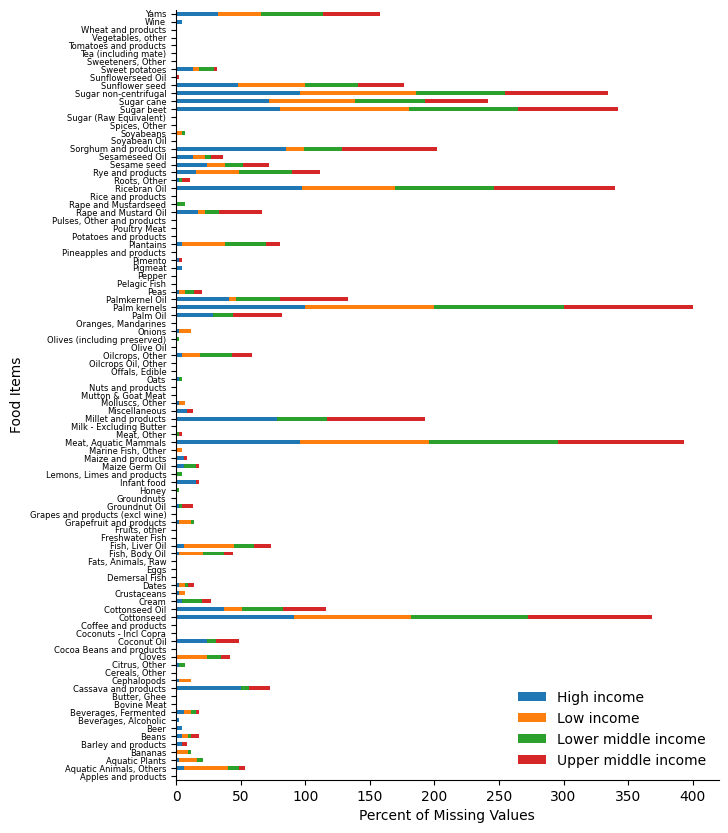

In [12]:
# 7. Checking the Type and Extent of Missing Data

## Splitting the data such that income groups and other fields are separate:
income_groups = size_and_dietary_intake[['Income group']]
# display(income_groups)


data = size_and_dietary_intake.iloc[:, 2:]
# display(data)


dietary_intake_nullity = data.isnull()
# display(dietary_intake_nullity)


## Merging it so that one can group missing values by income groups
dietary_nullity_income_grouped = pd.merge(income_groups,
                                          dietary_intake_nullity,
                                          left_index=True,
                                          right_index=True).groupby('Income group')

percentage_of_nullity = (dietary_nullity_income_grouped.sum() / dietary_nullity_income_grouped.count()) * 100
# display(percentage_of_nullity)



# Visualizing Nullity
percentage_of_nullity_dietary_intake_transposed = percentage_of_nullity.T

ax = percentage_of_nullity_dietary_intake_transposed.plot(kind='barh',
                                                          stacked=True)

ax.figure.set_size_inches(7, 10)
ax.set(xlabel='Percent of Missing Values',
       ylabel='Food Items')
ax.legend(loc='lower right', frameon=False)
#ax.invert_yaxis()
for spine in ['top', 'right'] :
    ax.spines[spine].set_visible(False)
# ax.set_title('Percentage of Missing Values For Each Food Item in Each Income Group', fontdict={'fontsize' : 10})
ax.tick_params(axis='y', which= 'major', labelsize=6)

#plt.set_size_inches(9, 7)
#plt.savefig('Percent_of_Nullity_1st_indicator.png')
plt.show()

In [109]:
# 9. Cleaning the dataset
# 9.1. Replacing 'NaN's with 0's
size_and_dietary_intake_imputed = size_and_dietary_intake.fillna(0.1) 	#print(the_sheet.head())


# 9.2. Grouping the foods into 7 groups : "Cereals", "Roots & Tubers", "Meat, Milk and Products, Eggs", "Vegetables", "Fruits and Plantains", "Seeds, Nuts and Oils", "Starch and Sugars"

daily_intake_aggregated = {
    'Country' : size_and_dietary_intake_imputed.index,
    'Income group' : size_and_dietary_intake_imputed['Income group'].values,
    #'Region' : size_and_dietary_intake_imputed['Region'].values,
    'Cereals' : 0,
    'Roots & Tubers' : 0,
    'Meat, Milk and products & Eggs' : 0,
    'Seeds, Nuts, and Oils' : 0,
    'Starchs & Sugars' : 0
}

daily_intake_aggregated['Cereals'] = \
    	size_and_dietary_intake_imputed['Barley and products']+ \
    	size_and_dietary_intake_imputed['Cereals, Other']+ \
        size_and_dietary_intake_imputed['Maize and products']+ \
        size_and_dietary_intake_imputed['Millet and products']+ \
        size_and_dietary_intake_imputed['Oats']+ \
        size_and_dietary_intake_imputed['Rice and products']+ \
        size_and_dietary_intake_imputed['Rye and products']+ \
        size_and_dietary_intake_imputed['Sorghum and products'] + \
        size_and_dietary_intake_imputed['Wheat and products']
        
daily_intake_aggregated['Roots & Tubers'] = \
    	size_and_dietary_intake_imputed['Cassava and products']+ \
        size_and_dietary_intake_imputed['Potatoes and products']+ \
        size_and_dietary_intake_imputed['Roots, Other']+ \
        size_and_dietary_intake_imputed['Sweet potatoes']+ \
    	size_and_dietary_intake_imputed['Yams'] + \
    	size_and_dietary_intake_imputed['Sugar cane'] + \
        size_and_dietary_intake_imputed['Sugar beet']

daily_intake_aggregated["Dairy & Egg Products"] = \
    size_and_dietary_intake_imputed['Butter, Ghee']+ \
    size_and_dietary_intake_imputed['Cream']+ \
    size_and_dietary_intake_imputed['Eggs'] + \
    size_and_dietary_intake_imputed['Milk - Excluding Butter']

daily_intake_aggregated["Finfish / Shellfish Products"] = \
	size_and_dietary_intake_imputed['Cephalopods']+ \
	size_and_dietary_intake_imputed['Crustaceans']+ \
    size_and_dietary_intake_imputed['Demersal Fish'] + \
    size_and_dietary_intake_imputed['Fish, Body Oil'] + \
    size_and_dietary_intake_imputed['Fish, Liver Oil'] + \
    size_and_dietary_intake_imputed['Freshwater Fish'] + \
    size_and_dietary_intake_imputed['Marine Fish, Other'] + \
    size_and_dietary_intake_imputed['Molluscs, Other']+ \
    size_and_dietary_intake_imputed['Pelagic Fish'] + \
    size_and_dietary_intake_imputed['Aquatic Animals, Others']


daily_intake_aggregated["Poultry"] = \
    size_and_dietary_intake_imputed['Poultry Meat']

daily_intake_aggregated["Pork"] = \
    size_and_dietary_intake_imputed['Pigmeat']


daily_intake_aggregated['Beef Products'] = \
    	size_and_dietary_intake_imputed['Bovine Meat']+ \
        size_and_dietary_intake_imputed['Offals, Edible'] + \
        size_and_dietary_intake_imputed['Fats, Animals, Raw'] + \
        size_and_dietary_intake_imputed['Meat, Other'] + \
        size_and_dietary_intake_imputed['Meat, Aquatic Mammals'] + \
    	size_and_dietary_intake_imputed['Mutton & Goat Meat']
        
daily_intake_aggregated["Spices & Herbs"] = \
    size_and_dietary_intake_imputed['Spices, Other'] + \
    size_and_dietary_intake_imputed['Tea (including mate)'] + \
    size_and_dietary_intake_imputed['Cloves']

daily_intake_aggregated["Legumes & Products"] = \
    size_and_dietary_intake_imputed['Pulses, Other and products']+ \
    size_and_dietary_intake_imputed['Beans']+ \
    size_and_dietary_intake_imputed['Soyabeans']+ \
    size_and_dietary_intake_imputed['Peas']

daily_intake_aggregated['Vegetables'] = \
    size_and_dietary_intake_imputed['Pimento'] + \
    size_and_dietary_intake_imputed['Pepper'] + \
	size_and_dietary_intake_imputed['Onions']+ \
    size_and_dietary_intake_imputed['Vegetables, other'] + \
	size_and_dietary_intake_imputed['Tomatoes and products'] + \
    size_and_dietary_intake_imputed['Aquatic Plants']
    
daily_intake_aggregated['Fruits & Plantains'] = \
    	size_and_dietary_intake_imputed['Bananas']+ \
    	size_and_dietary_intake_imputed['Coconuts - Incl Copra']+ \
    	size_and_dietary_intake_imputed['Dates']+ \
    	size_and_dietary_intake_imputed['Fruits, other']+ \
    	size_and_dietary_intake_imputed['Grapefruit and products'] + \
    	size_and_dietary_intake_imputed['Grapes and products (excl wine)'] + \
    	size_and_dietary_intake_imputed['Lemons, Limes and products'] + \
    	size_and_dietary_intake_imputed['Oranges, Mandarines'] + \
    	size_and_dietary_intake_imputed['Pineapples and products'] + \
    	size_and_dietary_intake_imputed['Plantains'] + \
    	size_and_dietary_intake_imputed['Apples and products'] + \
        size_and_dietary_intake_imputed['Citrus, Other']
    
daily_intake_aggregated['Seeds, Nuts, and Oils'] = \
    	size_and_dietary_intake_imputed['Cocoa Beans and products'] + \
        size_and_dietary_intake_imputed['Maize Germ Oil'] + \
        size_and_dietary_intake_imputed['Nuts and products'] + \
    	size_and_dietary_intake_imputed['Coconut Oil'] + \
        size_and_dietary_intake_imputed['Coconuts - Incl Copra'] + \
    	size_and_dietary_intake_imputed['Coffee and products'] + \
    	size_and_dietary_intake_imputed['Cottonseed Oil'] + \
    	size_and_dietary_intake_imputed['Cottonseed'] + \
        size_and_dietary_intake_imputed['Ricebran Oil'] + \
    	size_and_dietary_intake_imputed['Groundnut Oil'] + \
        size_and_dietary_intake_imputed['Oilcrops Oil, Other'] + \
    	size_and_dietary_intake_imputed['Groundnuts'] + \
        size_and_dietary_intake_imputed['Olive Oil'] + \
        size_and_dietary_intake_imputed['Olives (including preserved)'] + \
    	size_and_dietary_intake_imputed['Oilcrops, Other'] + \
    	size_and_dietary_intake_imputed['Palmkernel Oil'] + \
    	size_and_dietary_intake_imputed['Palm Oil'] + \
    	size_and_dietary_intake_imputed['Palm kernels'] + \
    	size_and_dietary_intake_imputed['Rape and Mustard Oil'] + \
    	size_and_dietary_intake_imputed['Rape and Mustardseed'] + \
    	size_and_dietary_intake_imputed['Sesame seed'] + \
    	size_and_dietary_intake_imputed['Sesameseed Oil'] + \
    	size_and_dietary_intake_imputed['Soyabean Oil'] + \
    	size_and_dietary_intake_imputed['Sunflower seed'] + \
    	size_and_dietary_intake_imputed['Sunflowerseed Oil']
    	#the_sheet_transposed['Nuts and products [2551]'] + \
    
daily_intake_aggregated['Starchs & Sugars'] = \
    	size_and_dietary_intake_imputed['Honey'] + \
    	size_and_dietary_intake_imputed['Sugar (Raw Equivalent)'] + \
    	size_and_dietary_intake_imputed['Sugar non-centrifugal'] + \
    	size_and_dietary_intake_imputed['Sweeteners, Other'] + \
    	size_and_dietary_intake_imputed['Beverages, Fermented']

daily_intake_aggregated['Infant food'] = \
        size_and_dietary_intake_imputed['Infant food']


daily_dietary_intake = pd.DataFrame(daily_intake_aggregated).set_index('Country')


# Removing the "Meat, Milk and products & Eggs column"
daily_dietary_intake = daily_dietary_intake.drop("Meat, Milk and products & Eggs", axis=1)


display(daily_dietary_intake.head())
# daily_dietary_intake.to_csv('Daily Dietary Energy Intake.csv', index=True)

daily_dietary_intake.head()

Income group  Cereals  Roots & Tubers   
Country                                                              
Afghanistan                    Low income   1534.2            53.4  \
Angola                Lower middle income    761.1           733.3   
Albania               Upper middle income   1066.2            89.3   
United Arab Emirates          High income   1079.4            39.1   
Argentina             Upper middle income   1049.4            84.3   

                      Seeds, Nuts, and Oils  Starchs & Sugars   
Country                                                         
Afghanistan                           209.5             149.1  \
Angola                                321.5             159.1   
Albania                               331.9             204.1   
United Arab Emirates                  811.3             346.2   
Argentina                             404.4             437.1   

                      Dairy & Egg Products  Finfish / Shellfish Products   
Country                                                                    
Afghanistan                          120.0                           1.7  \
Angola                                14.0                          24.1   
Albania                              716.0                          15.0   
United Arab Emirates                 219.0                          42.0   
Argentina                            297.0                          11.0   

                      Poultry   Pork  Beef Products  Spices & Herbs   
Country                                                               
Afghanistan               6.0    0.0           50.1             3.0  \
Angola                   33.0   77.0           39.1             0.0   
Albania                  62.0   59.0          164.1             0.1   
United Arab Emirates    111.0    0.1          115.1            10.0   
Argentina               194.0  112.0          408.1            27.0   

                      Legumes & Products  Vegetables  Fruits & Plantains   
Country                                                                    
Afghanistan                         17.2        34.1                59.1  \
Angola                              77.1        15.0               103.1   
Albania                             50.0       208.0               289.1   
United Arab Emirates               160.0        55.0               109.0   
Argentina                           55.0        54.0                81.0   

                      Infant food  
Country                            
Afghanistan                   1.0  
Angola                        1.0  
Albania                       1.0  
United Arab Emirates          5.0  
Argentina                     0.1

Income group  Cereals  Roots & Tubers   
Country                                                              
Afghanistan                    Low income   1534.2            53.4  \
Angola                Lower middle income    761.1           733.3   
Albania               Upper middle income   1066.2            89.3   
United Arab Emirates          High income   1079.4            39.1   
Argentina             Upper middle income   1049.4            84.3   

                      Seeds, Nuts, and Oils  Starchs & Sugars   
Country                                                         
Afghanistan                           209.5             149.1  \
Angola                                321.5             159.1   
Albania                               331.9             204.1   
United Arab Emirates                  811.3             346.2   
Argentina                             404.4             437.1   

                      Dairy & Egg Products  Finfish / Shellfish Products   
Country                                                                    
Afghanistan                          120.0                           1.7  \
Angola                                14.0                          24.1   
Albania                              716.0                          15.0   
United Arab Emirates                 219.0                          42.0   
Argentina                            297.0                          11.0   

                      Poultry   Pork  Beef Products  Spices & Herbs   
Country                                                               
Afghanistan               6.0    0.0           50.1             3.0  \
Angola                   33.0   77.0           39.1             0.0   
Albania                  62.0   59.0          164.1             0.1   
United Arab Emirates    111.0    0.1          115.1            10.0   
Argentina               194.0  112.0          408.1            27.0   

                      Legumes & Products  Vegetables  Fruits & Plantains   
Country                                                                    
Afghanistan                         17.2        34.1                59.1  \
Angola                              77.1        15.0               103.1   
Albania                             50.0       208.0               289.1   
United Arab Emirates               160.0        55.0               109.0   
Argentina                           55.0        54.0                81.0   

                      Infant food  
Country                            
Afghanistan                   1.0  
Angola                        1.0  
Albania                       1.0  
United Arab Emirates          5.0  
Argentina                     0.1

In [90]:
# Checking how good is the sample: 1. Sample sizes for each country

daily_dietary_intake[["Income group","Cereals"]].groupby("Income group").count()

Cereals
Income group                
High income               46
Low income                21
Lower middle income       44
Upper middle income       45

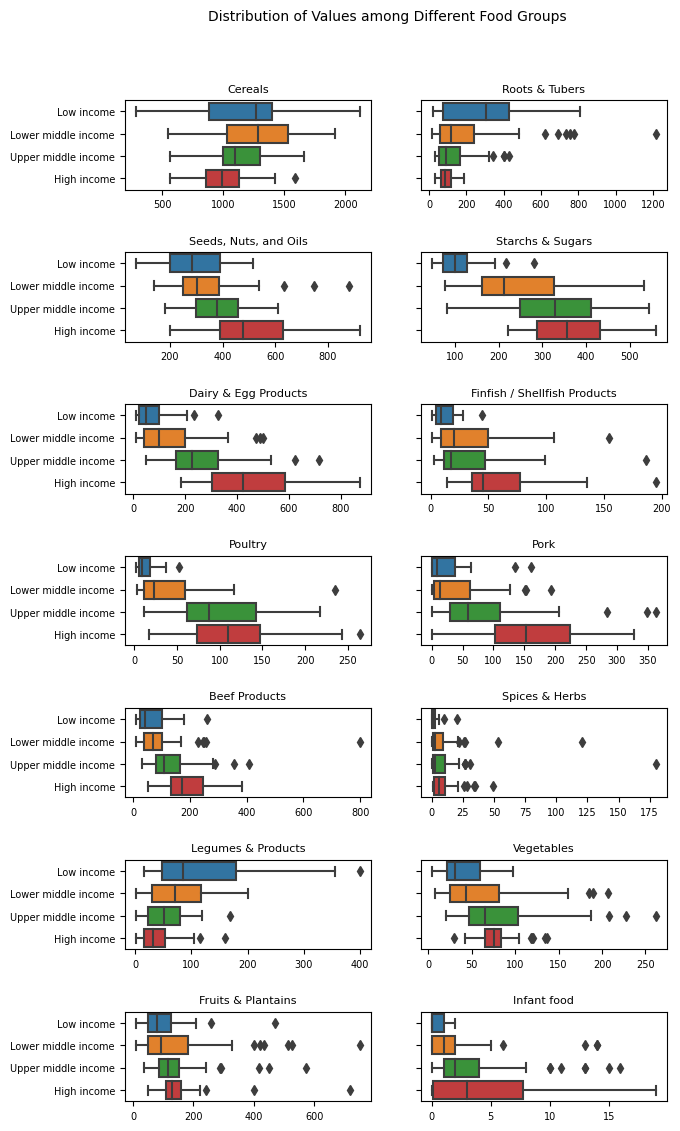

In [158]:
# Checking the distributions and Extreme Values: 2. The Box Plots

fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8), 
      (ax9, ax10), 
      (ax11, ax12), 
      (ax13, ax14)) = plt.subplots(7, 2, sharey=True, sharex=False, figsize=(7, 13))

def distributions(df, x, y, ax) :
    
    """Plots Boxplots for income groups"""
    
    g = sns.boxplot(data=df,
                    ax= ax,
                    x=x,
                    palette='tab10',
                    y=y).set(xlabel='',
                             ylabel='',
                             title=x)
    
    ax.set_title(x, fontsize=8)
    
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    return g

distributions(df=daily_dietary_intake, x="Cereals", y="Income group", ax=ax1)
distributions(df=daily_dietary_intake, x="Roots & Tubers", y="Income group", ax=ax2)
distributions(df=daily_dietary_intake, x="Seeds, Nuts, and Oils", y="Income group", ax=ax3)
distributions(df=daily_dietary_intake, x="Starchs & Sugars", y="Income group", ax=ax4)
distributions(df=daily_dietary_intake, x="Dairy & Egg Products", y="Income group", ax=ax5)
distributions(df=daily_dietary_intake, x="Finfish / Shellfish Products", y="Income group", ax=ax6)
distributions(df=daily_dietary_intake, x="Poultry", y="Income group", ax=ax7)
distributions(df=daily_dietary_intake, x="Pork", y="Income group", ax=ax8)
distributions(df=daily_dietary_intake, x="Beef Products", y="Income group", ax=ax9)
distributions(df=daily_dietary_intake, x="Spices & Herbs", y="Income group", ax=ax10)
distributions(df=daily_dietary_intake, x="Legumes & Products", y="Income group", ax=ax11)
distributions(df=daily_dietary_intake, x="Vegetables", y="Income group", ax=ax12)
distributions(df=daily_dietary_intake, x="Fruits & Plantains", y="Income group", ax=ax13)
distributions(df=daily_dietary_intake, x="Infant food", y="Income group", ax=ax14)

plt.suptitle('Distribution of Values among Different Food Groups', y= 0.95, fontsize=10)
plt.subplots_adjust(hspace= 0.7)
#plt.savefig('Distribution_of_Daily_Kcal_Intakes.png')


# Refer to this code for finer customizations of Seaborn plots.

In [159]:
# Removing Extreme Values

# Cereals: High Income (1500)

daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "High income") & (daily_dietary_intake["Cereals"] < 1500)]


# Roots and Tubers: Lower middle (600) and Upper middle (400)
daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "Lower middle income") & (daily_dietary_intake["Roots & Tubers"] < 600)]

daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "Upper middle income") & (daily_dietary_intake["Roots & Tubers"] < 400)]


# Seeds, Nuts, and Oils: Lower middle income (600)
daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "Lower middle income") & (daily_dietary_intake["Seeds, Nuts, and Oils"] < 600)]


# Starchs & Sugars: Low income (200)
daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "Low income") & (daily_dietary_intake["Starchs & Sugars"] < 200)]


# Dairy & Egg Products: Low income: Low income (210), Lower middle (400), Upper middle (600)
daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "Low income") & (daily_dietary_intake["Dairy & Egg Products"] < 210)]

daily_dietary_intake = daily_dietary_intake[(daily_dietary_intake["Income group"] == "Lower middle income") & (daily_dietary_intake["Dairy & Egg Products"] < 400)]



Income group  Cereals  Roots & Tubers   
Country                                                      
United Arab Emirates  High income   1079.4            39.1  \
Antigua and Barbuda   High income    737.1            37.1   
Australia             High income    754.1            83.2   
Austria               High income    905.2           105.3   
Belgium               High income    819.2           165.4   
Bahrain               High income   1124.0            56.0   
Barbados              High income    924.2            88.2   
Canada                High income    896.1           120.2   
Switzerland           High income    772.1            88.3   
Chile                 High income   1227.2           118.3   
Cyprus                High income   1154.2            33.1   
Germany               High income    790.1           124.3   
Denmark               High income    801.2           117.2   
Spain                 High income    781.1           107.3   
Estonia               High income    625.2           127.3   
Finland               High income    972.3           114.3   
France                High income   1035.2            92.4   
Greece                High income    811.2            99.4   
Croatia               High income    858.2            74.4   
Hungary               High income    935.2            73.3   
Ireland               High income   1134.2           132.4   
Iceland               High income    776.4            71.2   
Israel                High income   1158.2            72.3   
Italy                 High income   1109.2            69.3   
Japan                 High income   1057.1            60.2   
Kuwait                High income   1425.3            73.2   
Lithuania             High income   1129.2           104.3   
Luxembourg            High income    958.2            60.3   
Latvia                High income    921.2           187.3   
Malta                 High income   1036.2            75.2   
New Caledonia         High income   1037.1            60.2   
Netherlands           High income    865.2           131.3   
Norway                High income   1043.2            93.2   
Nauru                 High income    564.3            45.4   
New Zealand           High income    954.2            85.0   
Oman                  High income   1175.2            46.1   
Poland                High income   1127.3           184.3   
Portugal              High income    934.1           115.3   
French Polynesia      High income   1004.3           134.3   
Qatar                 High income   1394.1            60.1   
Slovenia              High income   1156.2            74.4   
Sweden                High income    908.2           101.2   
Seychelles            High income   1242.1            50.2   
Trinidad and Tobago   High income   1096.3            71.2   
Uruguay               High income   1100.2           101.3   

                      Seeds, Nuts, and Oils  Starchs & Sugars   
Country                                                         
United Arab Emirates                  811.3             346.2  \
Antigua and Barbuda                   295.5             250.1   
Australia                             702.5             407.1   
Austria                               651.4             400.1   
Belgium                               578.5             479.1   
Bahrain                               632.2             482.1   
Barbados                              342.4             560.1   
Canada                                714.5             422.1   
Switzerland                           624.6             445.1   
Chile                                 200.8             389.1   
Cyprus                                506.6             228.0   
Germany                               644.4             424.1   
Denmark                               301.5             472.1   
Spain                                 842.5             300.1   
Estonia                               405.9             290.1   
F

In [14]:
## 9.3. Separating country groups into different datasets.
def income_group_separator(df, col, cat) :

    """Separates a respective income group's data"""
    
    new_df = df[df[col] == cat]
    
    return new_df

low_inc_values = income_group_separator(daily_dietary_intake, 'Income group', 'Low income')

lower_middle_values = income_group_separator(daily_dietary_intake,'Income group', 'Lower middle income')

upper_middle_values = income_group_separator(daily_dietary_intake,'Income group', 'Upper middle income')

high_inc_values = income_group_separator(daily_dietary_intake, 'Income group', 'High income').sample(15)


# Taking a peek of the data:
display(high_inc_values.head())


Income group  Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Country                                                                      
New Caledonia  High income   1037.0            60.0                  436.0  \
Cyprus         High income   1154.0            33.0                  506.0   
Iceland        High income    776.0            71.0                  391.0   
New Zealand    High income    954.0            85.0                  411.0   
Oman           High income   1175.0            46.0                  332.0   

               Starchs & Sugars  Dairy & Egg Products   
Country                                                 
New Caledonia             275.0                 307.0  \
Cyprus                    228.0                 411.0   
Iceland                   368.0                 874.0   
New Zealand               544.0                 364.0   
Oman                      222.0                 295.0   

               Finfish / Shellfish Products  Poultry   Pork  Beef Products   
Country                                                                      
New Caledonia                          48.0    130.0  151.0          153.0  \
Cyprus                                 47.0    111.0  173.0          105.0   
Iceland                               195.0    109.0  225.0          271.0   
New Zealand                            46.0    114.0  109.0          249.0   
Oman                                   43.0     77.0    6.0          159.0   

               Spices & Herbs  Legumes & Products  Vegetables   
Country                                                         
New Caledonia             6.0                15.0        57.0  \
Cyprus                    4.0                26.0        68.0   
Iceland                   9.0                 7.0        70.0   
New Zealand               9.0                35.0        76.0   
Oman                     26.0                56.0       119.0   

               Fruits & Plantains  Infant food  
Country                                         
New Caledonia               148.0         16.0  
Cyprus                       86.0         12.0  
Iceland                     158.0          3.0  
New Zealand                 127.0          0.0  
Oman                        401.0          4.0

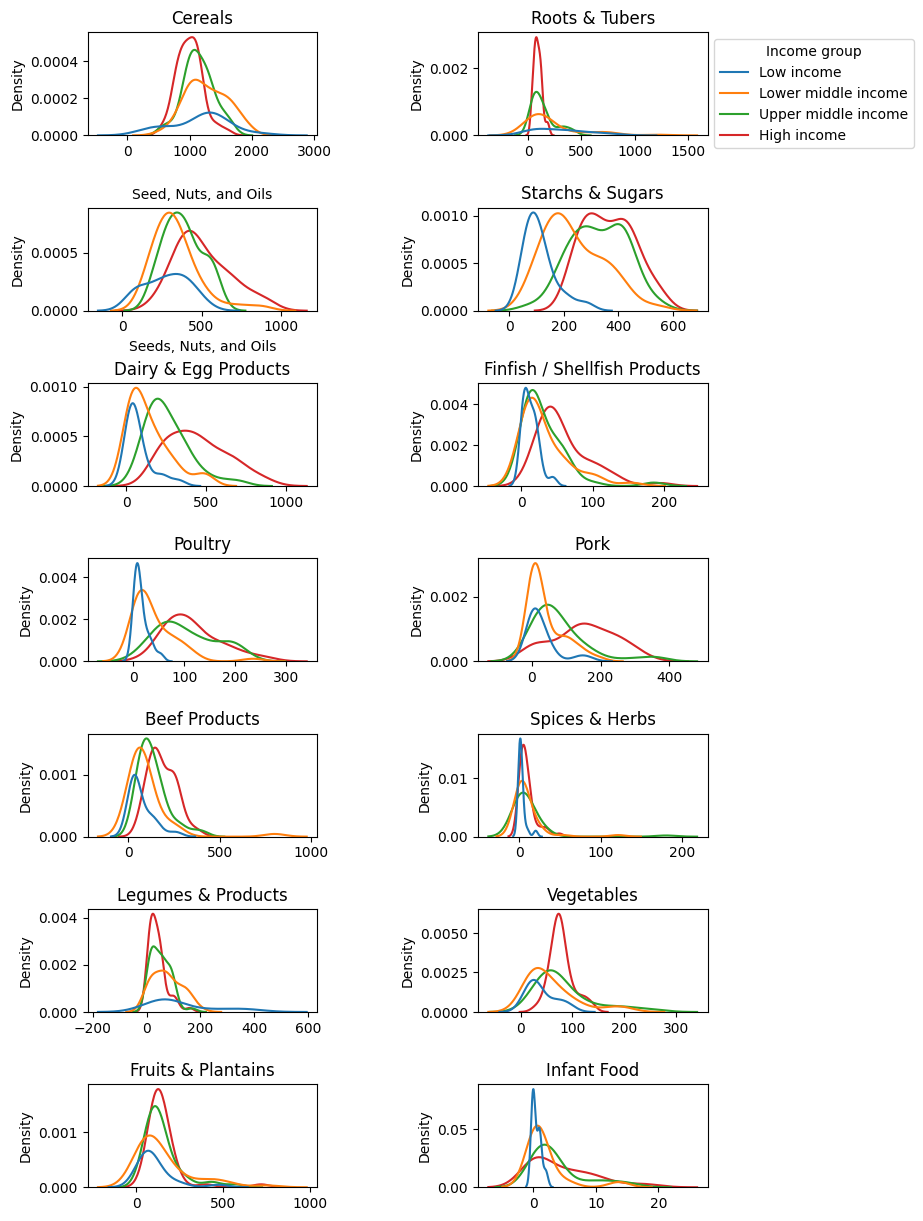

In [127]:
# Visualizing distributions of the dataset: KDE Plots

fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8), 
      (ax9, ax10), 
      (ax11, ax12), 
      (ax13, ax14)) = plt.subplots(7, 2, sharey=False, sharex=False, figsize=(8, 15))

sns.kdeplot(data=daily_dietary_intake, x="Cereals", hue="Income group", ax=ax1, legend=False).set(xlabel="", title="Cereals")
sns.kdeplot(data=daily_dietary_intake, x="Roots & Tubers", hue="Income group", ax=ax2).set(xlabel="", title="Roots & Tubers")
sns.kdeplot(data=daily_dietary_intake, x="Seeds, Nuts, and Oils", hue="Income group", ax=ax3, legend=False).set_title("Seed, Nuts, and Oils", fontsize=10)
sns.kdeplot(data=daily_dietary_intake, x="Starchs & Sugars", hue="Income group", ax=ax4, legend=False).set(xlabel="", title="Starchs & Sugars")
sns.kdeplot(data=daily_dietary_intake, x="Dairy & Egg Products", hue="Income group", ax=ax5, legend=False).set(xlabel="", title="Dairy & Egg Products")
sns.kdeplot(data=daily_dietary_intake, x="Finfish / Shellfish Products", hue="Income group", ax=ax6, legend=False).set(xlabel="", title="Finfish / Shellfish Products")
sns.kdeplot(data=daily_dietary_intake, x="Poultry", hue="Income group", ax=ax7, legend=False).set(xlabel="", title="Poultry")
sns.kdeplot(data=daily_dietary_intake, x="Pork", hue="Income group", ax=ax8, legend=False).set(xlabel="", title="Pork")
sns.kdeplot(data=daily_dietary_intake, x="Beef Products", hue="Income group", ax=ax9, legend=False).set(xlabel="", title="Beef Products")
sns.kdeplot(data=daily_dietary_intake, x="Spices & Herbs", hue="Income group", ax=ax10, legend=False).set(xlabel="", title="Spices & Herbs")
sns.kdeplot(data=daily_dietary_intake, x="Legumes & Products", hue="Income group", ax=ax11, legend=False).set(xlabel="", title="Legumes & Products")
sns.kdeplot(data=daily_dietary_intake, x="Vegetables", hue="Income group", ax=ax12, legend=False).set(xlabel="", title="Vegetables")
sns.kdeplot(data=daily_dietary_intake, x="Fruits & Plantains", hue="Income group", ax=ax13, legend=False).set(xlabel="", title="Fruits & Plantains")
sns.kdeplot(data=daily_dietary_intake, x="Infant food", hue="Income group", ax=ax14, legend=False).set(xlabel="", title="Infant Food")

plt.subplots_adjust(hspace=0.7, wspace= 0.7)

sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1), frameon=True)

In [84]:
# Checking the normality by using the Shapiro Wilk's Lambda

def shapiro(df) :
    """Modifies the dataset to work well with the Shapiro test"""

    shapiro_collection = dict()

    for i, val in df.T.iloc[1:].iterrows():
        shapiro_values = stats.shapiro(val.values)

        shapiro_collection[f"{i}"] = shapiro_values.statistic


    return pd.DataFrame.from_dict(shapiro_collection, orient="index", columns=["Shapiro's coeffiecients"]).T


display(shapiro(low_inc_values))
display(shapiro(lower_middle_values))
display(shapiro(upper_middle_values))
display(shapiro(high_inc_values))

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients  0.937017        0.908387               0.946292  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.859132              0.744526  \

                         Finfish / Shellfish Products   Poultry      Pork   
Shapiro's coeffiecients                      0.881025  0.828223  0.666448  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.800318         0.59246            0.805422  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.904225             0.73916     0.726444

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients  0.976928        0.721017               0.877604  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.947933              0.842628  \

                         Finfish / Shellfish Products   Poultry      Pork   
Shapiro's coeffiecients                      0.807086  0.752063  0.775052  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.543328         0.46562            0.950683  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.823581             0.77562     0.565715

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients  0.98214        0.820275                0.96388  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.980895              0.912511  \

                         Finfish / Shellfish Products   Poultry      Pork   
Shapiro's coeffiecients                      0.723099  0.936469  0.795089  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.876975        0.353308            0.934211  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.832007            0.757775     0.784018

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients  0.868206        0.961704               0.832981  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.933118              0.930136  \

                         Finfish / Shellfish Products   Poultry      Pork   
Shapiro's coeffiecients                      0.589643  0.964341  0.965353  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.929569        0.821281            0.904463  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.880659            0.706513     0.860961

In [88]:
# Checking the skewness of the data sets
def skew_calculator(df) :
    """Modifies the dataset to measure skewness in it"""

    skewness_values = dict()

    for i, val in df.T.iloc[1:].iterrows():
        skew_values = skew(list(val.values))

        skewness_values[f"{i}"] = skew_values


    return pd.DataFrame.from_dict(skewness_values, orient="index", columns=["Skew coeffiecients"]).T


display(skew_calculator(low_inc_values))
display(skew_calculator(lower_middle_values))
display(skew_calculator(upper_middle_values))
display(skew_calculator(high_inc_values))

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Skew coeffiecients  -0.3071         0.58328              -0.116731  \

                    Starchs & Sugars  Dairy & Egg Products   
Skew coeffiecients          1.420464              1.785387  \

                    Finfish / Shellfish Products   Poultry      Pork   
Skew coeffiecients                      1.158359  1.417509  2.067741  \

                    Beef Products  Spices & Herbs  Legumes & Products   
Skew coeffiecients       1.511289        2.811072            1.124117  \

                    Vegetables  Fruits & Plantains  Infant food  
Skew coeffiecients    0.750708            2.278933     0.891896

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Skew coeffiecients  0.119391        1.938001               1.528839  \

                    Starchs & Sugars  Dairy & Egg Products   
Skew coeffiecients          0.648158              1.264258  \

                    Finfish / Shellfish Products   Poultry     Pork   
Skew coeffiecients                      1.658136  2.234549  1.35448  \

                    Beef Products  Spices & Herbs  Legumes & Products   
Skew coeffiecients       4.218687        4.327924            0.373902  \

                    Vegetables  Fruits & Plantains  Infant food  
Skew coeffiecients    1.483858            1.799684     2.640305

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Skew coeffiecients  0.007582        1.267065               0.224546  \

                    Starchs & Sugars  Dairy & Egg Products   
Skew coeffiecients         -0.113163              1.201837  \

                    Finfish / Shellfish Products   Poultry      Pork   
Skew coeffiecients                      2.701397  0.410341  1.837758  \

                    Beef Products  Spices & Herbs  Legumes & Products   
Skew coeffiecients       1.415299         5.53357            0.750235  \

                    Vegetables  Fruits & Plantains  Infant food  
Skew coeffiecients    1.514024            2.170005     1.485251

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Skew coeffiecients  1.394865        0.369587               0.975723  \

                    Starchs & Sugars  Dairy & Egg Products   
Skew coeffiecients          0.180399              0.828984  \

                    Finfish / Shellfish Products   Poultry      Pork   
Skew coeffiecients                      2.741162  0.252114 -0.050058  \

                    Beef Products  Spices & Herbs  Legumes & Products   
Skew coeffiecients       0.489132        1.354034            0.788573  \

                    Vegetables  Fruits & Plantains  Infant food  
Skew coeffiecients    1.123832            2.355729     0.503735

In [118]:
# Transforming the data

transformed_low_inc_values = np.log(low_inc_values.iloc[:, 1:])
transformed_lower_middle_values = np.log(lower_middle_values.iloc[:, 1:])
transformed_upper_middle_values = np.log(upper_middle_values.iloc[:, 1:])
transformed_high_inc_values = np.log(high_inc_values.iloc[:, 1:])

display(shapiro(transformed_low_inc_values))
display(shapiro(transformed_lower_middle_values))
display(shapiro(transformed_upper_middle_values))
display(shapiro(transformed_high_inc_values))

c:\Users\David\Desktop\Dev\thesis\.venv\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\David\Desktop\Dev\thesis\.venv\Lib\site-packages\scipy\stats\_morestats.py:1805: RuntimeWarning: invalid value encountered in subtract
  x = x - np.median(x)


Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.925617               0.876068  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients           0.97362              0.961017  \

                         Finfish / Shellfish Products   Poultry  Pork   
Shapiro's coeffiecients                      0.936902  0.963645   NaN  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.965668             NaN            0.913465  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.951287            0.950265          NaN

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.977638               0.984589  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.978138               0.96401  \

                         Finfish / Shellfish Products   Poultry  Pork   
Shapiro's coeffiecients                      0.971302  0.975959   NaN  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.980029             NaN            0.842204  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.983304            0.989578          NaN

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.951704               0.967389  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.916554              0.988793  \

                         Finfish / Shellfish Products   Poultry  Pork   
Shapiro's coeffiecients                      0.981411  0.940355   NaN  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.987779             NaN              0.8758  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.980882              0.9751          NaN

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.956346                0.88145  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.934561              0.969365  \

                         Finfish / Shellfish Products   Poultry  Pork   
Shapiro's coeffiecients                      0.851064  0.907431   NaN  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.936207        0.950464            0.951109  \

                         Vegetables  Fruits & Plantains  Infant food  
Shapiro's coeffiecients    0.945206            0.895543          NaN

In [147]:
# Removing foods_groups that don't follow normality

clean_low_inc_values = transformed_low_inc_values.drop(["Pork", "Spices & Herbs", "Infant food"], axis=1)

clean_lower_middle_values = transformed_lower_middle_values.drop(["Pork", "Spices & Herbs", "Infant food"], axis=1)

clean_upper_middle_values = transformed_upper_middle_values.drop(["Pork", "Spices & Herbs", "Infant food"], axis=1)

clean_high_inc_values = transformed_high_inc_values.drop(["Pork", "Infant food"], axis=1)


clean_low_inc_values.head()

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Country                                                                     
Afghanistan               7.335634        3.970292               5.342334  \
Burundi                   5.826000        6.697034               4.248495   
Burkina Faso              7.314553        2.995732               5.541264   
Central African Republic  5.655992        6.529419               5.837730   
Ethiopia                  7.452402        4.343805               4.430817   

                          Starchs & Sugars  Dairy & Egg Products   
Country                                                            
Afghanistan                       5.003946              4.787492  \
Burundi                           4.127134              2.564949   
Burkina Faso                      4.804021              3.970292   
Central African Republic          4.553877              3.258097   
Ethiopia                          4.595120              4.143135   

                          Finfish / Shellfish Products   Poultry   
Country                                                            
Afghanistan                                   0.000000  1.791759  \
Burundi                                       1.609438  0.693147   
Burkina Faso                                  2.890372  3.526361   
Central African Republic                      2.639057  2.197225   
Ethiopia                                      0.000000  0.693147   

                          Beef Products  Legumes & Products  Vegetables   
Country                                                                   
Afghanistan                    3.912023            2.833213    3.526361  \
Burundi                        2.639057            5.631212    3.135494   
Burkina Faso                   4.634729            5.843544    4.094345   
Central African Republic       5.181784            4.442651    2.397895   
Ethiopia                       3.871201            5.416100    3.433987   

                          Fruits & Plantains  
Country                                       
Afghanistan                         4.077537  
Burundi                             4.836282  
Burkina Faso                        4.394449  
Central African Republic            4.382027  
Ethiopia                            2.564949

In [148]:
# Rechecking the Shapiro Wilk's Lambda of the cleaned datasets

display(shapiro(clean_low_inc_values))
display(shapiro(clean_lower_middle_values))
display(shapiro(clean_upper_middle_values))
display(shapiro(clean_high_inc_values))

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.925617               0.876068  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients           0.97362              0.961017  \

                         Finfish / Shellfish Products   Poultry   
Shapiro's coeffiecients                      0.936902  0.963645  \

                         Beef Products  Legumes & Products  Vegetables   
Shapiro's coeffiecients       0.965668            0.913465    0.951287  \

                         Fruits & Plantains  
Shapiro's coeffiecients            0.950265

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.977638               0.984589  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.978138               0.96401  \

                         Finfish / Shellfish Products   Poultry   
Shapiro's coeffiecients                      0.971302  0.975959  \

                         Beef Products  Legumes & Products  Vegetables   
Shapiro's coeffiecients       0.980029            0.842204    0.983304  \

                         Fruits & Plantains  
Shapiro's coeffiecients            0.989578

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.951704               0.967389  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.916554              0.988793  \

                         Finfish / Shellfish Products   Poultry   
Shapiro's coeffiecients                      0.981411  0.940355  \

                         Beef Products  Legumes & Products  Vegetables   
Shapiro's coeffiecients       0.987779              0.8758    0.980882  \

                         Fruits & Plantains  
Shapiro's coeffiecients              0.9751

Roots & Tubers  Seeds, Nuts, and Oils   
Shapiro's coeffiecients        0.956346                0.88145  \

                         Starchs & Sugars  Dairy & Egg Products   
Shapiro's coeffiecients          0.934561              0.969365  \

                         Finfish / Shellfish Products   Poultry   
Shapiro's coeffiecients                      0.851064  0.907431  \

                         Beef Products  Spices & Herbs  Legumes & Products   
Shapiro's coeffiecients       0.936207        0.950464            0.951109  \

                         Vegetables  Fruits & Plantains  
Shapiro's coeffiecients    0.945206            0.895543

In [151]:
# Joining the dataset to have a single dataset.

cleaned_dietary_intakes = pd.concat([clean_low_inc_values,
                                     clean_lower_middle_values,
                                     clean_upper_middle_values,
                                     clean_high_inc_values], axis=0)

cleaned_dietary_intakes.head()


cleaned_dietary_intakes = pd.merge(size_of_economy,
                                   cleaned_dietary_intakes,
                                   left_index=True,
                                   right_index=True).drop("Region", axis=1)


cleaned_dietary_intakes.head()

Income group   Cereals  Roots & Tubers   
Country                                                      
Afghanistan           Low income  7.335634        3.970292  \
Angola       Lower middle income  6.634633        6.597146   
Albania      Upper middle income  6.971669        4.488636   
Argentina    Upper middle income  6.955593        4.430817   
Armenia      Upper middle income  7.177019        4.787492   

             Seeds, Nuts, and Oils  Starchs & Sugars  Dairy & Egg Products   
Country                                                                      
Afghanistan               5.342334          5.003946              4.787492  \
Angola                    5.771441          5.068904              2.639057   
Albania                   5.802118          5.318120              6.573680   
Argentina                 6.001415          6.079933              5.693732   
Armenia                   5.690359          5.837730              5.998937   

             Finfish / Shellfish Products   Poultry  Beef Products   
Country                                                              
Afghanistan                      0.000000  1.791759       3.912023  \
Angola                           3.178054  3.496508       3.663562   
Albania                          2.708050  4.127134       5.099866   
Argentina                        2.397895  5.267858       6.011267   
Armenia                          2.302585  4.127134       5.634790   

             Legumes & Products  Vegetables  Fruits & Plantains   
Country                                                           
Afghanistan            2.833213    3.526361            4.077537  \
Angola                 4.343805    2.708050            4.634729   
Albania                3.912023    5.337538            5.666427   
Argentina              4.007333    3.988984            4.394449   
Armenia                3.135494    4.852030            4.955827   

             Spices & Herbs  
Country                      
Afghanistan             NaN  
Angola                  NaN  
Albania                 NaN  
Argentina               NaN  
Armenia                 NaN

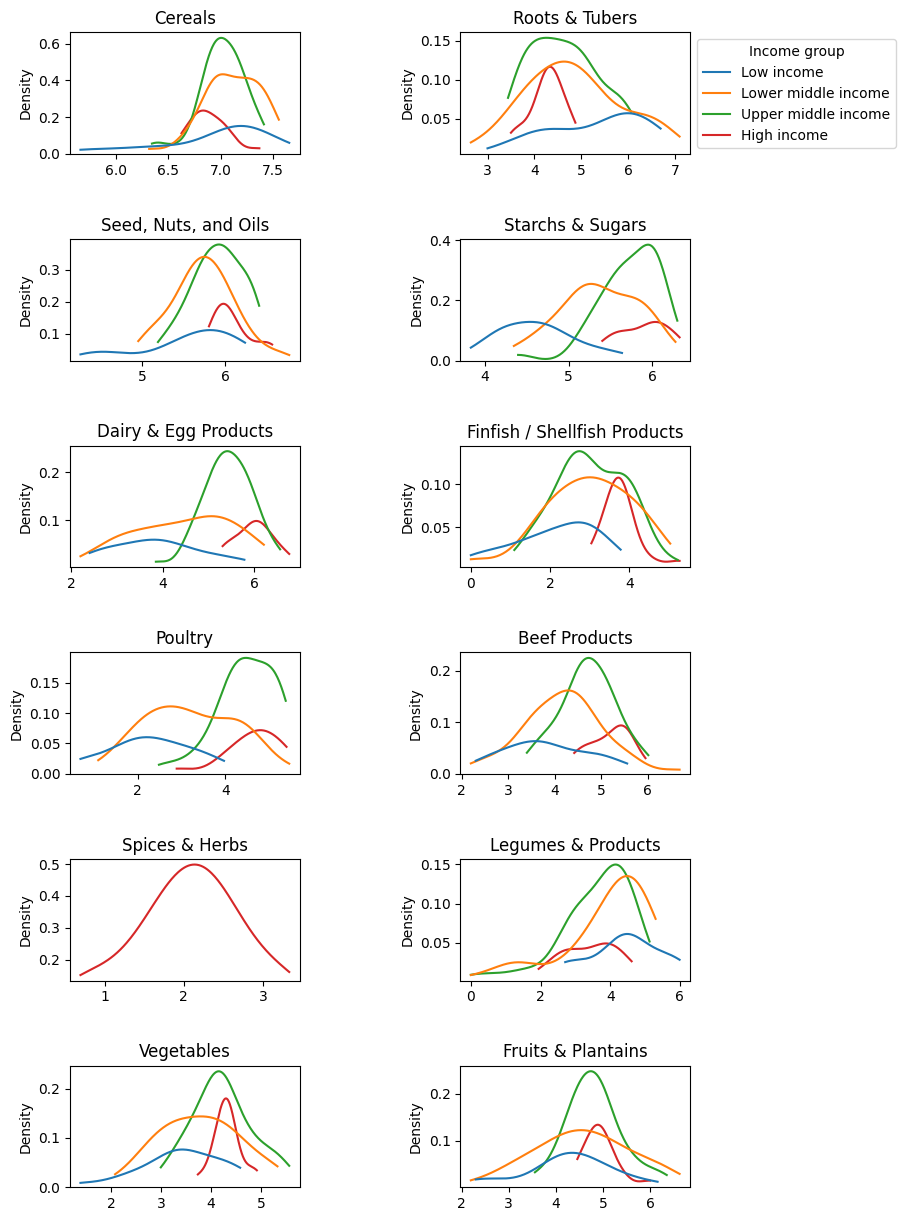

In [152]:
# Replotting the dataset to see distributions in different food groups

fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8), 
      (ax9, ax10), 
      (ax11, ax12)) = plt.subplots(6, 2, sharey=False, sharex=False, figsize=(8, 15))

sns.kdeplot(data=cleaned_dietary_intakes, x="Cereals", hue="Income group", ax=ax1, cut=0, legend=False).set(xlabel="", title="Cereals")
sns.kdeplot(data=cleaned_dietary_intakes, x="Roots & Tubers", hue="Income group", ax=ax2, cut=0).set(xlabel="", title="Roots & Tubers")
sns.kdeplot(data=cleaned_dietary_intakes, x="Seeds, Nuts, and Oils", hue="Income group", ax=ax3, legend=False, cut=0).set(xlabel="", title="Seed, Nuts, and Oils")
sns.kdeplot(data=cleaned_dietary_intakes, x="Starchs & Sugars", hue="Income group", ax=ax4, legend=False, cut=0).set(xlabel="", title="Starchs & Sugars")
sns.kdeplot(data=cleaned_dietary_intakes, x="Dairy & Egg Products", hue="Income group", ax=ax5, legend=False, cut=0).set(xlabel="", title="Dairy & Egg Products")
sns.kdeplot(data=cleaned_dietary_intakes, x="Finfish / Shellfish Products", hue="Income group", ax=ax6, legend=False, cut=0).set(xlabel="", title="Finfish / Shellfish Products")
sns.kdeplot(data=cleaned_dietary_intakes, x="Poultry", hue="Income group", ax=ax7, legend=False, cut=0).set(xlabel="", title="Poultry")
sns.kdeplot(data=cleaned_dietary_intakes, x="Beef Products", hue="Income group", ax=ax8, legend=False, cut=0).set(xlabel="", title="Beef Products")
sns.kdeplot(data=cleaned_dietary_intakes, x="Spices & Herbs", hue="Income group", ax=ax9, legend=False, cut=0).set(xlabel="", title="Spices & Herbs")
sns.kdeplot(data=cleaned_dietary_intakes, x="Legumes & Products", hue="Income group", ax=ax10, legend=False, cut=0).set(xlabel="", title="Legumes & Products")
sns.kdeplot(data=cleaned_dietary_intakes, x="Vegetables", hue="Income group", ax=ax11, legend=False, cut=0).set(xlabel="", title="Vegetables")
sns.kdeplot(data=cleaned_dietary_intakes, x="Fruits & Plantains", hue="Income group", ax=ax12, legend=False, cut=0).set(xlabel="", title="Fruits & Plantains")

plt.subplots_adjust(hspace=0.7, wspace= 0.7)

sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1), frameon=True)

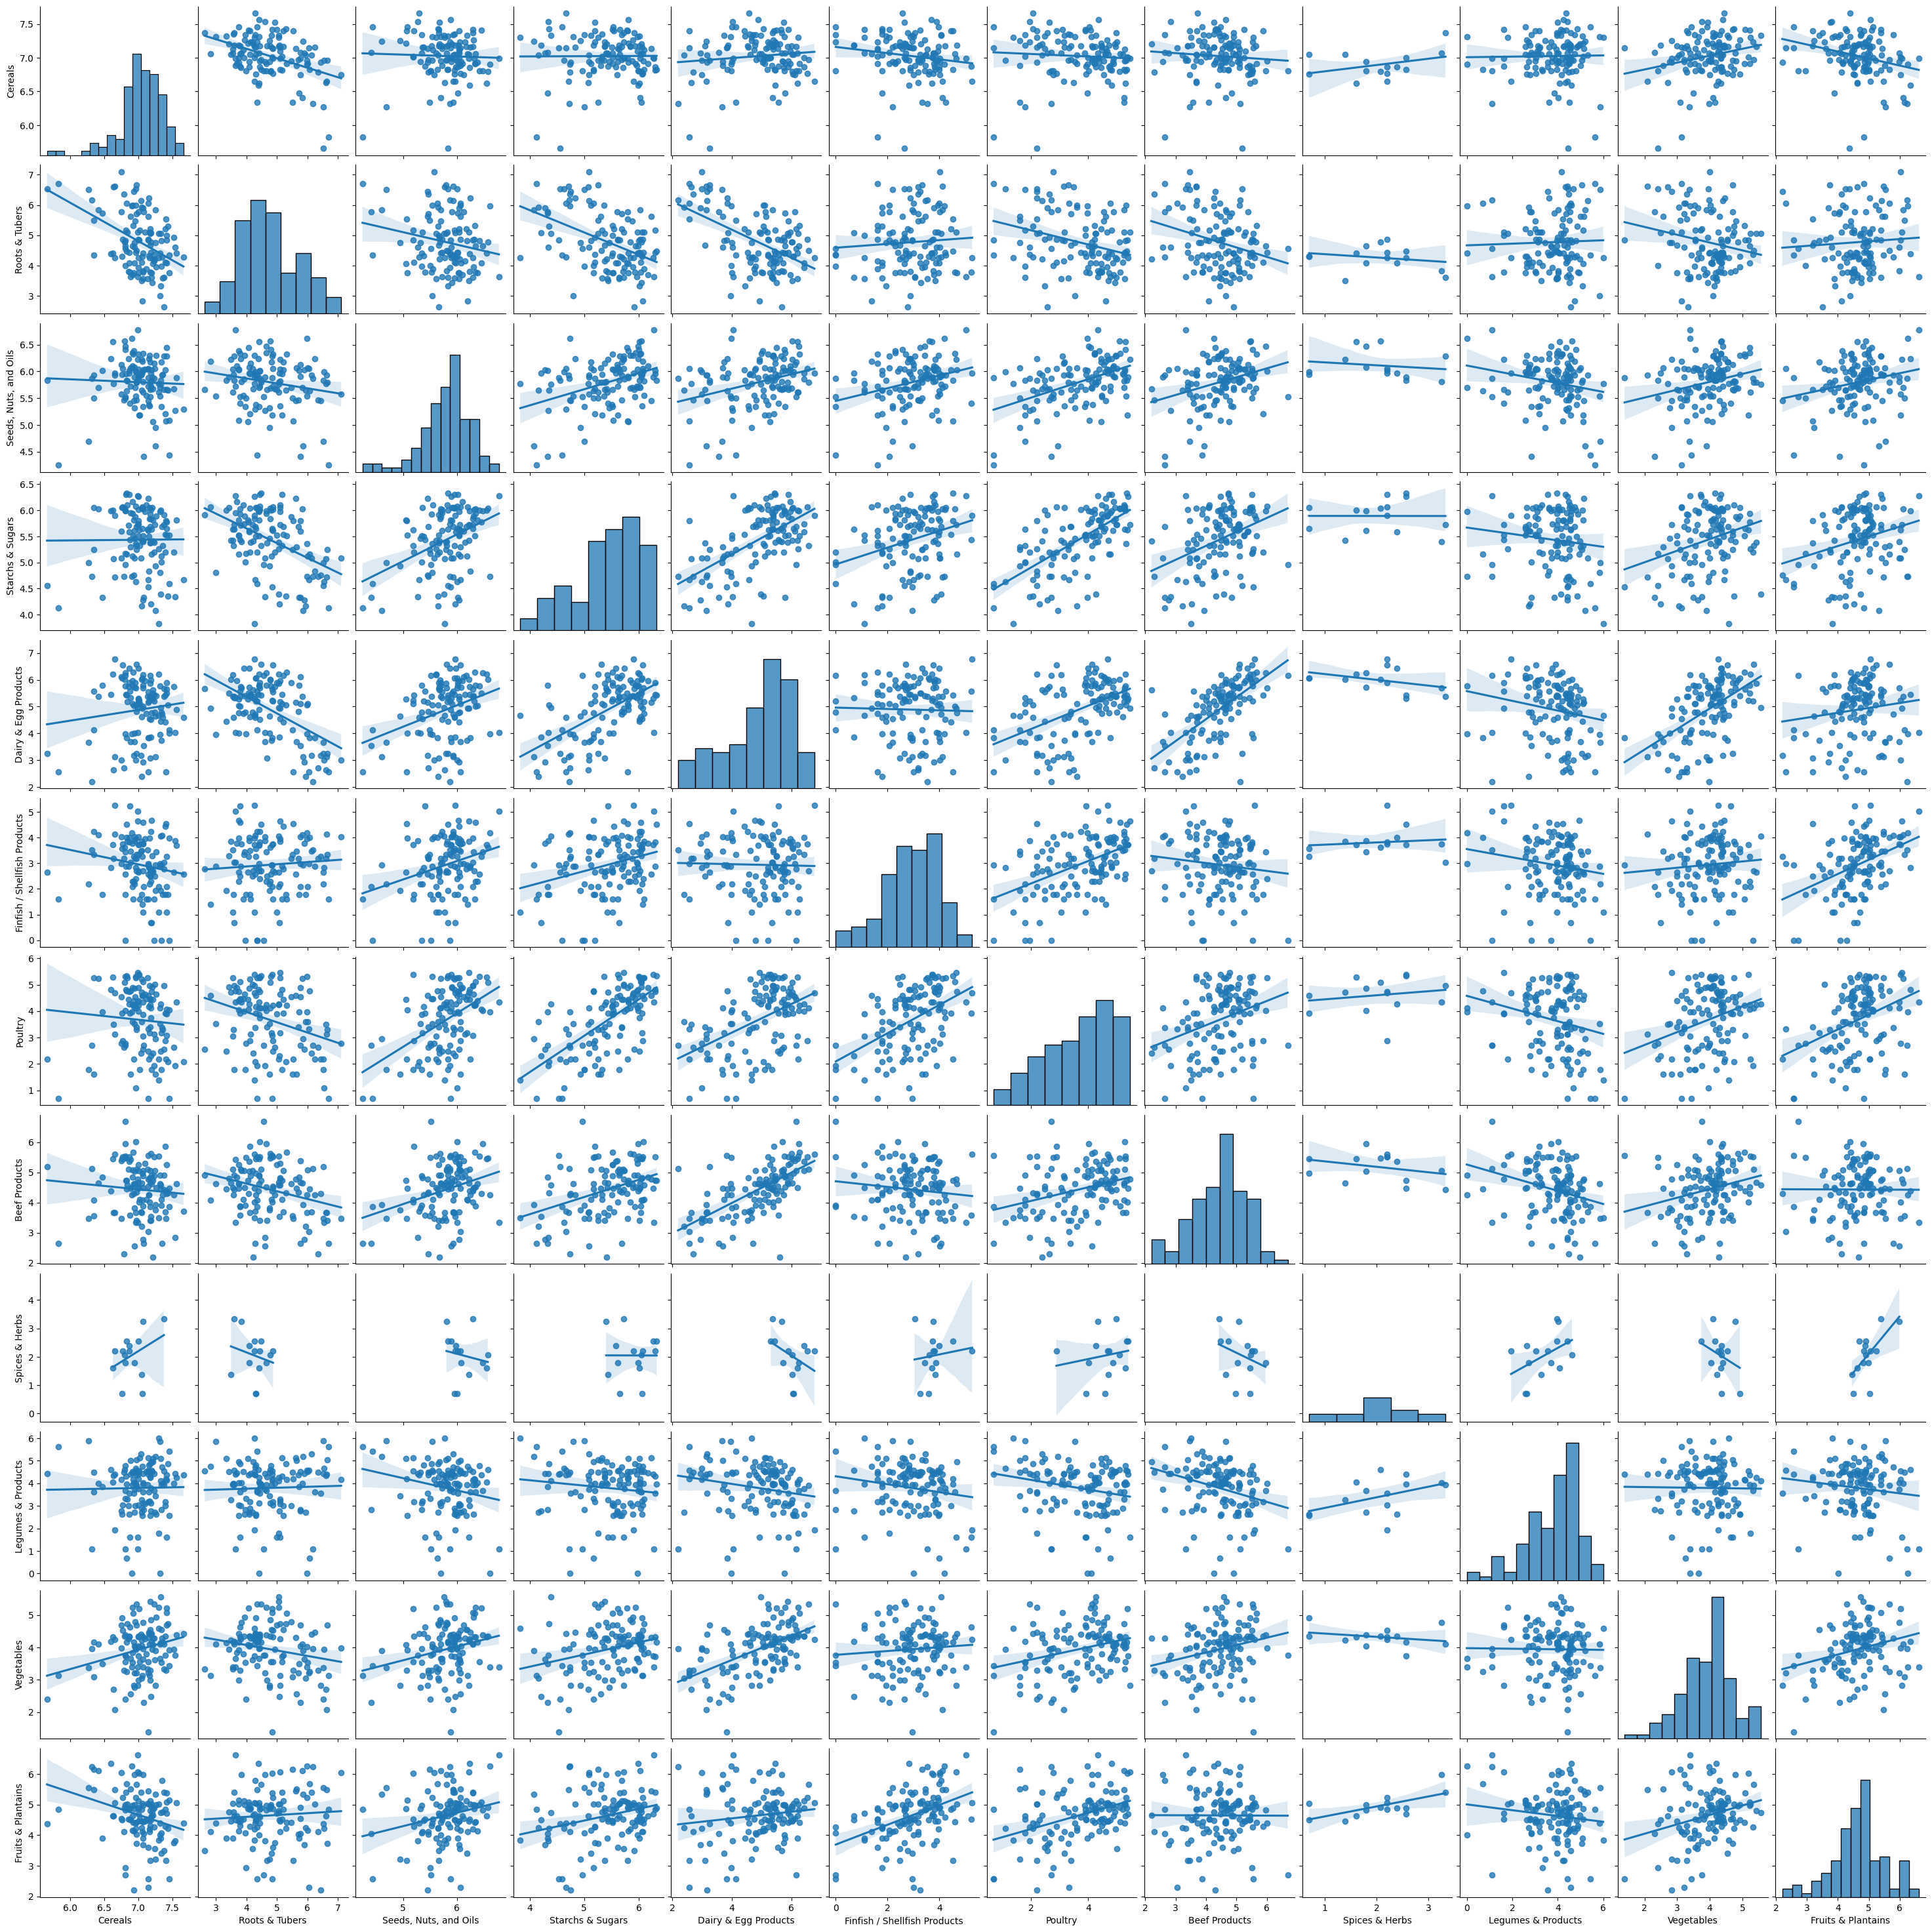

In [153]:
# Analyzing heteroskedasticity by using a matrix of scatterplots

sns.pairplot(cleaned_dietary_intakes,
             vars=["Cereals",
                   "Roots & Tubers",
                   "Seeds, Nuts, and Oils",
                   "Starchs & Sugars",
                   "Dairy & Egg Products",
                   "Finfish / Shellfish Products",
                   "Poultry",
                   "Beef Products",
                   "Spices & Herbs",
                   "Legumes & Products",
                   "Vegetables",
                   "Fruits & Plantains"],
                   kind="reg",
                   diag_kind="hist")

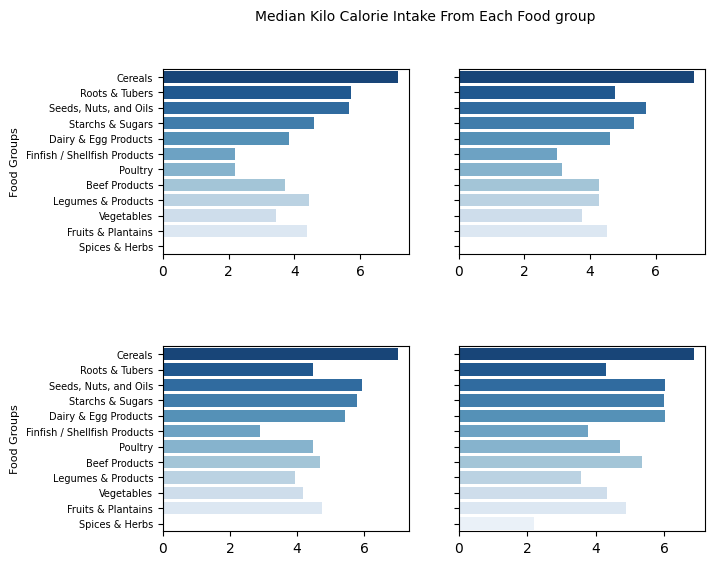

In [154]:
# 10. Preparing to extract dietary values from foods that are not staples.

## Summary Statistics on the data
daily_intake_economized = cleaned_dietary_intakes.groupby('Income group')

median_kilo_calories_by_income_group = daily_intake_economized.median()



In [ ]:



## 10.2. Visualizing median kilo calories from each income group.
## Transposing so that one can plot
median_kilo_cal_transposed = median_kilo_calories_by_income_group.T

#display(daily_dietary_intake.head(10))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=True)
fig.set_size_inches(7, 6)


def bar_plotter(df, x, y, ax, xlabel=None, ylabel=None, palette=None, title=None) :
    
    """Creates bar plots for Income groups"""
    
    g = sns.barplot(x=x,
                    y=y,
                    data= df,
                    ax= ax,
                    palette=palette).set(xlabel='')


    ax.tick_params(axis= 'y', which='major', labelsize=7)
    ax.set_ylabel(ylabel, fontdict={"fontsize" : 8})
    ax.set_xlabel(xlabel, fontdict={'fontsize' : 8})
    ax.set_title(label=title, fontsize=10)
    plt.subplots_adjust(hspace=0.5)



df = median_kilo_cal_transposed

y = median_kilo_cal_transposed.index

yl = 'Food Groups'


bar_plotter(df, x='Low income', y=y, ax=ax1, ylabel=yl, palette="Blues_r")

bar_plotter(df, x='Lower middle income', ax=ax2, y=y, palette="Blues_r")

bar_plotter(df, x='Upper middle income', ax=ax3, y=y, ylabel=yl, palette="Blues_r")

bar_plotter(df, x='High income', y=y, ax=ax4, palette="Blues_r")


plt.suptitle('Median Kilo Calorie Intake From Each Food group', fontsize=10)
plt.savefig('Median Daily_Intake_Kcal.png')
plt.show()

In [137]:
median_kcal_high_income = median_kilo_cal_transposed[['High income']].sort_values('High income', ascending=False)

median_kcal_low_income = median_kilo_cal_transposed[['Low income']].sort_values('Low income' , ascending=False)

median_kcal_lower_middle_income = median_kilo_cal_transposed[['Lower middle income']].sort_values('Lower middle income', ascending=False)

median_kcal_upper_middle_income = median_kilo_cal_transposed[['Upper middle income']].sort_values('Upper middle income', ascending=False)


def percentage_cal(df) :
    
    """Calculates Percentage For Each Food Group"""

    df.loc['Total'] = df.iloc[:, 0].sum()

    numerator = df.iloc[:, 0].values

    denominator = df.loc['Total'].values

    df['Percent'] = np.round(((numerator / denominator) * 100), 1)
    
    return df




food_group_kcal_percent_high_income = percentage_cal(median_kcal_high_income)

food_group_kcal_percent_low_income = percentage_cal(median_kcal_low_income)

food_group_kcal_percent_lower_middle = percentage_cal(median_kcal_lower_middle_income)

food_group_kcal_percent_upper_middle = percentage_cal(median_kcal_upper_middle_income)


#display(food_group_kcal_percent_high_income)
#display(food_group_kcal_percent_low_income)
#display(food_group_kcal_percent_lower_middle)
#display(food_group_kcal_percent_upper_middle)



# 11. Extracting median daily calory intake from staple & non-staple food from each income group

daily_calories_non_staples_low_income = food_group_kcal_percent_low_income[food_group_kcal_percent_low_income['Percent'] < 12.5]

staples_low_income = food_group_kcal_percent_low_income[food_group_kcal_percent_low_income['Percent'] >= 12.5]


daily_calories_non_staples_high_income = food_group_kcal_percent_high_income[food_group_kcal_percent_high_income['Percent'] < 12.5]

staples_high_income = food_group_kcal_percent_high_income[food_group_kcal_percent_high_income['Percent'] >= 12.5]


daily_calories_non_staples_lower_middle = food_group_kcal_percent_lower_middle[food_group_kcal_percent_lower_middle['Percent'] < 12.5]

staples_lower_middle = food_group_kcal_percent_lower_middle[food_group_kcal_percent_lower_middle['Percent'] >= 12.5]


daily_calories_non_staples_upper_middle = food_group_kcal_percent_upper_middle[food_group_kcal_percent_upper_middle['Percent'] < 12.5]

staples_upper_middle = food_group_kcal_percent_upper_middle[food_group_kcal_percent_upper_middle['Percent'] >= 12.5]



display(daily_calories_non_staples_low_income.T)
display(staples_low_income.T)

display(daily_calories_non_staples_lower_middle.T)
display(staples_lower_middle.T)

display(daily_calories_non_staples_upper_middle.T)
display(staples_upper_middle.T)

display(daily_calories_non_staples_high_income.T)
display(staples_high_income.T)


Roots & Tubers  Seeds, Nuts, and Oils  Starchs & Sugars   
Income group                                                            
Low income          5.726848               5.652489           4.59512  \
Percent            12.100000              11.900000           9.70000   

              Legumes & Products  Fruits & Plantains  Dairy & Egg Products   
Income group                                                                 
Low income              4.442651            4.382027              3.850148  \
Percent                 9.400000            9.300000              8.100000   

              Beef Products  Vegetables  Finfish / Shellfish Products   
Income group                                                            
Low income         3.713572    3.433987                      2.197225  \
Percent            7.800000    7.300000                      4.600000   

               Poultry  
Income group            
Low income    2.197225  
Percent       4.600000

Cereals       Total
Income group                       
Low income     7.143618   47.334908
Percent       15.100000  100.000000

Seeds, Nuts, and Oils  Starchs & Sugars  Roots & Tubers   
Income group                                                                   
Lower middle income               5.707022          5.351577        4.757882  \
Percent                          11.300000         10.600000        9.400000   

                     Dairy & Egg Products  Fruits & Plantains  Beef Products   
Income group                                                                   
Lower middle income              4.603919            4.510799        4.26268  \
Percent                          9.100000            8.900000        8.40000   

                     Legumes & Products  Vegetables   Poultry   
Income group                                                    
Lower middle income            4.262581      3.7612  3.156774  \
Percent                        8.400000      7.4000  6.200000   

                     Finfish / Shellfish Products  
Income group                                       
Lower middle income                      2.994481  
Percent                                  5.900000

Cereals       Total
Income group                             
Lower middle income   7.15578   50.524695
Percent              14.20000  100.000000

Seeds, Nuts, and Oils  Starchs & Sugars   
Income group                                                   
Upper middle income               5.932245          5.796058  \
Percent                          11.100000         10.800000   

                     Dairy & Egg Products  Fruits & Plantains  Beef Products   
Income group                                                                   
Upper middle income                5.4161             4.75359       4.672829  \
Percent                           10.1000             8.90000       8.700000   

                     Roots & Tubers   Poultry  Vegetables  Legumes & Products   
Income group                                                                    
Upper middle income        4.488636  4.477337    4.174387            3.931826  \
Percent                    8.400000  8.400000    7.800000            7.300000   

                     Finfish / Shellfish Products  
Income group                                       
Upper middle income                      2.890372  
Percent                                  5.400000

Cereals       Total
Income group                              
Upper middle income   7.002156   53.535536
Percent              13.100000  100.000000

Cereals  Dairy & Egg Products  Seeds, Nuts, and Oils   
Income group                                                           
High income    6.860664              6.025866               6.018593  \
Percent       11.800000             10.400000              10.400000   

              Starchs & Sugars  Beef Products  Fruits & Plantains  Poultry   
Income group                                                                 
High income           5.991465       5.356586             4.89784  4.70953  \
Percent              10.300000       9.200000             8.40000  8.10000   

              Vegetables  Roots & Tubers  Finfish / Shellfish Products   
Income group                                                             
High income     4.330733        4.304065                        3.7612  \
Percent         7.500000        7.400000                        6.5000   

              Legumes & Products  Spices & Herbs  
Income group                                      
High income             3.555348        2.197225  
Percent                 6.100000        3.800000

Total
Income group            
High income    58.009115
Percent       100.000000

In [18]:
intake_percent_table_index = [
    ['Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Low Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Lower Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'Upper Middle Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income',
     'High Income'],
    ['Cereals',
     'Cereals', 'Cereals', 'Cereals', 'Roots & Tubers', 'Roots & Tubers', 'Roots & Tubers', 'Roots & Tubers', "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", "Seeds, Nuts, and Oils", 'Starchs & Sugars', 'Starchs & Sugars', 'Starchs & Sugars', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Seeds, Nuts, and Oils', 'Seeds, Nuts, and Oils','Seeds, Nuts, and Oils', "Dairy & Egg Products", "Dairy & Egg Products", "Dairy & Egg Products"],
    ['55.8', '55.8', '55.8', '55.8', '13.5', '13.5', '13.5', '13.5', '12.6', '12.6', '12.6', '54.6', '54.6', '54.6', '54.6', '54.6', '54.6', '12.8', '12.8', '12.8', '12.8', '12.8', '12.8', '41.8', '41.8', '41.8', '41.8', '41.8', "14.3", "14.3", "14.3", "12.5", "12.5", "12.5", "32.4", "32.4", "32.4", "32.4", "32.4", "15.6", "15.6", "15.6", "13.8", "13.8", "13.8"],
    ['Starchs & Sugars', 'Legumes & Products', 'Fruits & Plantains', 'Dairy & Egg Products', 'Beef Products', 'Vegetables', 'Finfish / Shellfish Products', "Poultry", "Pork", "Spices & Herbs", "Infant Foods", 'Starchs & Sugars', 'Roots & Tubers', 'Dairy & Egg Products', 'Fruits & Plantains', 'Beef Products', "Legumes & Products", 'Vegetables', 'Poultry', 'Finfish / Shellfish Products', 'Pork', 'Spices & Herbs', 'Infant Food', 'Dairy & Egg Products', 'Fruits & Plantains', 'Beef Products', 'Roots & Tubers', 'Poultry', "Vegetables", "Pork", "Legumes & Products", "Finfish / Shellfish Products", "Spices & Herbs", "Infant food", "Starchs & Sugars", "Beef Products", "Pork", "Fruits & Plantains", "Poultry", "Roots & Tubers", "Vegetables", "Finfish / Shellfish Products", "Legumes & Products", "Spices & Herbs", "Infant Food"],
]


intake_percent_table_column = ["4.4", "3.7", '3.5', '2.1', '1.8', '1.4', '0.4', '0.4', '0.4', '0.0', '0.0', '9.0', '5.0', '4.3', '3.9', '3.0', '3.0', '1.8', '1.0', '0.9', '0.6', '0.1', '0.0', '8.6', '4.4', '4.1', '3.4', '3.3', "2.5", "2.2", "1.9", "0.7", "0.1", "0.1", "11.7", "5.7", "5.0", "4.2", "3.6", "2.8", "2.5", "1.5", "1.0", "0.2", "0.1"]

# display(len(intake_percent_table_column))


In [19]:

intake_percent_table = pd.DataFrame(intake_percent_table_column,
                                    index=intake_percent_table_index,
                                    columns=['Percent of Median Calorie Intake'])

intake_percent_table.index = intake_percent_table.index.rename(['Income group', 'Staple Foods', 'Percent of Median Daily Calorie Intake', 'Non-Staple Foods'])

display(intake_percent_table.style)

# intake_percent_table.to_csv('Daily_Median_Percent_Intakes.csv', index=True)

In [20]:
# Exploratory Data Analysis: Which countries consume more calories from non-staple foods?

# Converting the last column into numerical values

intake_percent_table["Percent of Median Calorie Intake"] = intake_percent_table["Percent of Median Calorie Intake"].astype("float")

assert intake_percent_table["Percent of Median Calorie Intake"].dtype == "float"

intake_percent_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45 entries, ('Low Income', 'Cereals', '55.8', 'Starchs & Sugars') to ('High Income', 'Dairy & Egg Products', '13.8', 'Infant Food')
Data columns (total 1 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Percent of Median Calorie Intake  45 non-null     float64
dtypes: float64(1)
memory usage: 2.2+ KB


In [21]:
# Adding the median values from each group

calories_from_non_staples = pd.DataFrame([daily_calories_non_staples_low_income.T.iloc[1].sum(),
                                          daily_calories_non_staples_lower_middle.T.iloc[1].sum(),
                                          daily_calories_non_staples_upper_middle.T.iloc[1].sum(),
                                          daily_calories_non_staples_high_income.T.iloc[1].sum()],
                                          index=["Low income", 
                                                 "Lower middle income",
                                                 "Upper middle income",
                                                 "High income"],
                                          columns= ["Percent of kcal from non-staple foods"])

calories_from_non_staples

Percent of kcal from non-staple foods
Low income                                            18.1
Lower middle income                                   32.6
Upper middle income                                   31.3
High income                                           38.3

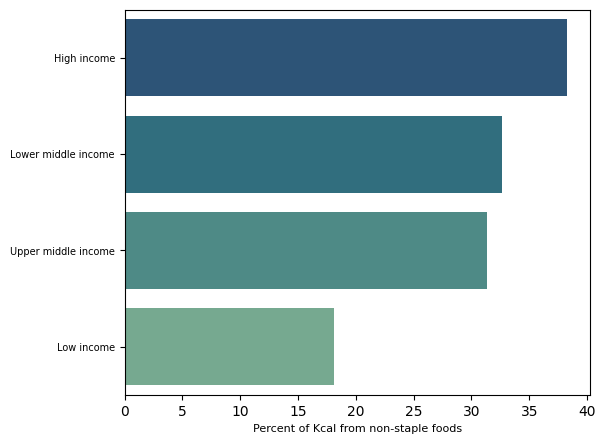

In [436]:
# Plotting the above information

fig, ax = plt.subplots()
fig.set_size_inches(6, 3)

df = calories_from_non_staples.sort_values("Percent of kcal from non-staple foods", ascending=False)

bar_plotter(x="Percent of kcal from non-staple foods",
            y=df.index,
            df=df,
            ax=ax,
            xlabel="Percent of Kcal from non-staple foods",
            #ylabel="Income groups",
            palette="crest_r")

plt.show()

In [19]:
# Number of countries from each group in this indicator:

daily_intake_economized.count()

Cereals  Roots & Tubers  Seeds, Nuts, and Oils   
Income group                                                          
High income               46              46                     46  \
Low income                21              21                     21   
Lower middle income       44              44                     44   
Upper middle income       45              45                     45   

                     Starchs & Sugars  Dairy & Egg Products   
Income group                                                  
High income                        46                    46  \
Low income                         21                    21   
Lower middle income                44                    44   
Upper middle income                45                    45   

                     Finfish / Shellfish Products  Poultry  Pork   
Income group                                                       
High income                                    46       46    46  \
Low income                                     21       21    21   
Lower middle income                            44       44    44   
Upper middle income                            45       45    45   

                     Beef Products  Spices & Herbs  Legumes & Products   
Income group                                                             
High income                     46              46                  46  \
Low income                      21              21                  21   
Lower middle income             44              44                  44   
Upper middle income             45              45                  45   

                     Vegetables  Fruits & Plantains  Infant food  
Income group                                                      
High income                  46                  46           46  
Low income                   21                  21           21  
Lower middle income          44                  44           44  
Upper middle income          45                  45           45

### Indicator 2: Shannon Diversity

In [20]:
# 1. Reading-in the dataset from FAO

food_supply = pd.read_csv('Food Quantity Data.csv',
                          sep= ',',
                          names= ['Country', 'Item', 'Value'])

#display(food_supply.head(30))

copy_food_supply = food_supply.copy(deep= True).drop(0)

display(copy_food_supply.head(10))

Country                   Item   Value
1   Afghanistan     Wheat and products  158.95
2   Afghanistan      Rice and products   17.21
3   Afghanistan    Barley and products    0.07
4   Afghanistan     Maize and products    3.53
5   Afghanistan       Rye and products       0
6   Afghanistan                   Oats       0
7   Afghanistan    Millet and products    0.16
8   Afghanistan         Cereals, Other       0
9   Afghanistan   Cassava and products    0.01
10  Afghanistan  Potatoes and products   26.49

In [21]:
# 2. Transposing the Data so that each country is represented as a one row:
transposed_copy_of_food_supply = copy_food_supply.pivot(
    index= 'Country',
    columns= 'Item',
    values= 'Value'
)

display(transposed_copy_of_food_supply.head())
#display(transposed_copy_of_food_supply.info())

Item                Apples and products Aquatic Animals, Others   
Country                                                           
Afghanistan                        2.95                     NaN  \
Albania                           32.66                       0   
Algeria                           12.38                       0   
Angola                             0.38                       0   
Antigua and Barbuda                5.47                     NaN   

Item                Aquatic Plants Bananas Barley and products Beans   
Country                                                                
Afghanistan                    NaN    3.11                0.07     0  \
Albania                          0    8.26                 0.2  5.03   
Algeria                          0    4.32               15.01  1.54   
Angola                           0   37.32                   0  7.24   
Antigua and Barbuda              0   17.87                   0  1.03   

Item                Bovine Meat Butter, Ghee Cassava and products Cephalopods   
Country                                                                         
Afghanistan                2.73         0.97                 0.01         NaN  \
Albania                    13.2         1.52                    0        0.72   
Algeria                    4.85          0.4                    0        0.03   
Angola                     4.17         0.04                226.1           0   
Antigua and Barbuda        6.74         1.26                 0.78        0.25   

Item                 ... Sugar non-centrifugal Sunflower seed   
Country              ...                                        
Afghanistan          ...                   NaN            NaN  \
Albania              ...                   NaN            NaN   
Algeria              ...                   NaN            NaN   
Angola               ...                   NaN            NaN   
Antigua and Barbuda  ...                   NaN           0.04   

Item                Sunflowerseed Oil Sweet potatoes Sweeteners, Other   
Country                                                                  
Afghanistan                      1.27              0              0.54  \
Albania                          4.72           0.01             24.22   
Algeria                          1.26              0              2.81   
Angola                           0.27          39.53              9.23   
Antigua and Barbuda              0.09           2.33             28.34   

Item                Tea (including mate) Tomatoes and products   
Country                                                          
Afghanistan                            2                  0.89  \
Albania                             0.15                 77.88   
Algeria                             0.36                 34.52   
Angola                              0.03                  2.12   
Antigua and Barbuda                 0.73                  5.82   

Item                Vegetables, other Wheat and products  Yams  
Country                                                         
Afghanistan                     55.39             158.95   NaN  
Albania                        217.39             124.68   NaN  
Algeria                        137.39             181.92   NaN  
Angola                          20.49              27.17   NaN  
Antigua and Barbuda             44.71               68.7  1.35  

[5 rows x 92 columns]

In [22]:
# 3. Changing the data type. Data in all columns was as objects, not numbers.
transposed_copy_copy = transposed_copy_of_food_supply.copy(deep= True)#.fillna(0)

transposed_copy_cleaned = transposed_copy_copy.loc[:,:].astype('float')

#assert transposed_copy_cleaned.loc[:,:].dtype == 'float'

display(transposed_copy_cleaned.head())

Item                 Apples and products  Aquatic Animals, Others   
Country                                                             
Afghanistan                         2.95                      NaN  \
Albania                            32.66                      0.0   
Algeria                            12.38                      0.0   
Angola                              0.38                      0.0   
Antigua and Barbuda                 5.47                      NaN   

Item                 Aquatic Plants  Bananas  Barley and products  Beans   
Country                                                                    
Afghanistan                     NaN     3.11                 0.07   0.00  \
Albania                         0.0     8.26                 0.20   5.03   
Algeria                         0.0     4.32                15.01   1.54   
Angola                          0.0    37.32                 0.00   7.24   
Antigua and Barbuda             0.0    17.87                 0.00   1.03   

Item                 Bovine Meat  Butter, Ghee  Cassava and products   
Country                                                                
Afghanistan                 2.73          0.97                  0.01  \
Albania                    13.20          1.52                  0.00   
Algeria                     4.85          0.40                  0.00   
Angola                      4.17          0.04                226.10   
Antigua and Barbuda         6.74          1.26                  0.78   

Item                 Cephalopods  ...  Sugar non-centrifugal  Sunflower seed   
Country                           ...                                          
Afghanistan                  NaN  ...                    NaN             NaN  \
Albania                     0.72  ...                    NaN             NaN   
Algeria                     0.03  ...                    NaN             NaN   
Angola                      0.00  ...                    NaN             NaN   
Antigua and Barbuda         0.25  ...                    NaN            0.04   

Item                 Sunflowerseed Oil  Sweet potatoes  Sweeteners, Other   
Country                                                                     
Afghanistan                       1.27            0.00               0.54  \
Albania                           4.72            0.01              24.22   
Algeria                           1.26            0.00               2.81   
Angola                            0.27           39.53               9.23   
Antigua and Barbuda               0.09            2.33              28.34   

Item                 Tea (including mate)  Tomatoes and products   
Country                                                            
Afghanistan                          2.00                   0.89  \
Albania                              0.15                  77.88   
Algeria                              0.36                  34.52   
Angola                               0.03                   2.12   
Antigua and Barbuda                  0.73                   5.82   

Item                 Vegetables, other  Wheat and products  Yams  
Country                                                           
Afghanistan                      55.39              158.95   NaN  
Albania                         217.39              124.68   NaN  
Algeria                         137.39              181.92   NaN  
Angola                           20.49               27.17   NaN  
Antigua and Barbuda              44.71               68.70  1.35  

[5 rows x 92 columns]

In [23]:
# 4. Attaching countries' regions and sizes of economy
transposed_copy_with_size_and_region = pd.merge(size_of_economy,
                                                transposed_copy_cleaned,
                                                left_index=True,
                                                right_index=True
                                               )

display(transposed_copy_with_size_and_region.head())

Income group                      Region   
Country                                                                 
Afghanistan                    Low income                  South Asia  \
Angola                Lower middle income          Sub-Saharan Africa   
Albania               Upper middle income       Europe & Central Asia   
United Arab Emirates          High income  Middle East & North Africa   
Argentina             Upper middle income   Latin America & Caribbean   

                      Apples and products  Aquatic Animals, Others   
Country                                                              
Afghanistan                          2.95                      NaN  \
Angola                               0.38                      0.0   
Albania                             32.66                      0.0   
United Arab Emirates                 6.75                      0.0   
Argentina                            5.39                      0.0   

                      Aquatic Plants  Bananas  Barley and products  Beans   
Country                                                                     
Afghanistan                      NaN     3.11                 0.07   0.00  \
Angola                           0.0    37.32                 0.00   7.24   
Albania                          0.0     8.26                 0.20   5.03   
United Arab Emirates             0.0     8.55                  NaN   2.30   
Argentina                        0.0    12.66                  NaN   2.11   

                      Bovine Meat  Butter, Ghee  ...  Sugar non-centrifugal   
Country                                          ...                          
Afghanistan                  2.73          0.97  ...                    NaN  \
Angola                       4.17          0.04  ...                    NaN   
Albania                     13.20          1.52  ...                    NaN   
United Arab Emirates         6.59          1.29  ...                    NaN   
Argentina                   47.98          0.48  ...                    NaN   

                      Sunflower seed  Sunflowerseed Oil  Sweet potatoes   
Country                                                                   
Afghanistan                      NaN               1.27            0.00  \
Angola                           NaN               0.27           39.53   
Albania                          NaN               4.72            0.01   
United Arab Emirates            0.26               0.80            0.46   
Argentina                        NaN              11.17            2.56   

                      Sweeteners, Other  Tea (including mate)   
Country                                                         
Afghanistan                        0.54                  2.00  \
Angola                             9.23                  0.03   
Albania                           24.22                  0.15   
United Arab Emirates               1.91                  0.12   
Argentina                          8.34                 24.14   

                      Tomatoes and products  Vegetables, other   
Country                                                          
Afghanistan                            0.89              55.39  \
Angola                                 2.12              20.49   
Albania                               77.88             217.39   
United Arab Emirates                   5.23              45.76   
Argentina                             22.87              37.86   

                      Wheat and products  Yams  
Country                                         
Afghanistan                       158.95   NaN  
Angola                             27.17   NaN  
Albania                           124.68   NaN  
United Arab Emirates               91.81   0.3  
Argentina                         117.84   NaN  

[5 rows x 94 columns]

In [24]:
# 5. Dealing with Missing Data: Determining the type.

## 5.1. Checking to see if there is any relationship between income group and missing data on a specific food item:

transposed_copy_nullity = transposed_copy_cleaned.isnull()

# display(transposed_copy_nullity)

transposed_copy_nullity_with_regions = pd.merge(size_of_economy,
                                                transposed_copy_nullity,
                                                left_index=True,
                                                right_index=True
                                               )
#display(transposed_copy_nullity_with_regions.head())

country_count_each_inc_group = pd.DataFrame(transposed_copy_with_size_and_region['Income group'].value_counts())

country_count_each_inc_group.columns = ['Total Count']

display(country_count_each_inc_group)

Total Count
Income group                    
High income                   46
Upper middle income           45
Lower middle income           44
Low income                    21

In [25]:
## 5.2. Percentage of missing values for each food group in each income group
nullity_by_income_group = transposed_copy_nullity_with_regions.groupby('Income group').sum().iloc[:, 1:]

count_of_countries = transposed_copy_nullity_with_regions.groupby('Income group').count().iloc[:, 1:]

percentage_of_nullity_of_food_groups = nullity_by_income_group.div(count_of_countries) * 100

display(percentage_of_nullity_of_food_groups)


Apples and products  Aquatic Animals, Others   
Income group                                                        
High income                          0.0                 6.521739  \
Low income                           0.0                33.333333   
Lower middle income                  0.0                 9.090909   
Upper middle income                  0.0                 4.444444   

                     Aquatic Plants   Bananas  Barley and products     Beans   
Income group                                                                   
High income                2.173913  0.000000             4.347826  4.347826  \
Low income                14.285714  4.761905             0.000000  0.000000   
Lower middle income        4.545455  2.272727             0.000000  2.272727   
Upper middle income        0.000000  0.000000             4.444444  6.666667   

                     Bovine Meat  Butter, Ghee  Cassava and products   
Income group                                                           
High income                  0.0           0.0             50.000000  \
Low income                   0.0           0.0              0.000000   
Lower middle income          0.0           0.0              6.818182   
Upper middle income          0.0           0.0             15.555556   

                     Cephalopods  ...  Sugar non-centrifugal  Sunflower seed   
Income group                      ...                                          
High income             2.173913  ...              95.652174       47.826087  \
Low income              9.523810  ...              90.476190       52.380952   
Lower middle income     0.000000  ...              68.181818       40.909091   
Upper middle income     0.000000  ...              80.000000       35.555556   

                     Sunflowerseed Oil  Sweet potatoes  Sweeteners, Other   
Income group                                                                
High income                   0.000000       13.043478                0.0  \
Low income                    0.000000        0.000000                0.0   
Lower middle income           0.000000        9.090909                0.0   
Upper middle income           2.222222        2.222222                0.0   

                     Tea (including mate)  Tomatoes and products   
Income group                                                       
High income                           0.0                    0.0  \
Low income                            0.0                    0.0   
Lower middle income                   0.0                    0.0   
Upper middle income                   0.0                    0.0   

                     Vegetables, other  Wheat and products       Yams  
Income group                                                           
High income                        0.0                 0.0  32.608696  
Low income                         0.0                 0.0  33.333333  
Lower middle income                0.0                 0.0  50.000000  
Upper middle income                0.0                 0.0  44.444444  

[4 rows x 92 columns]

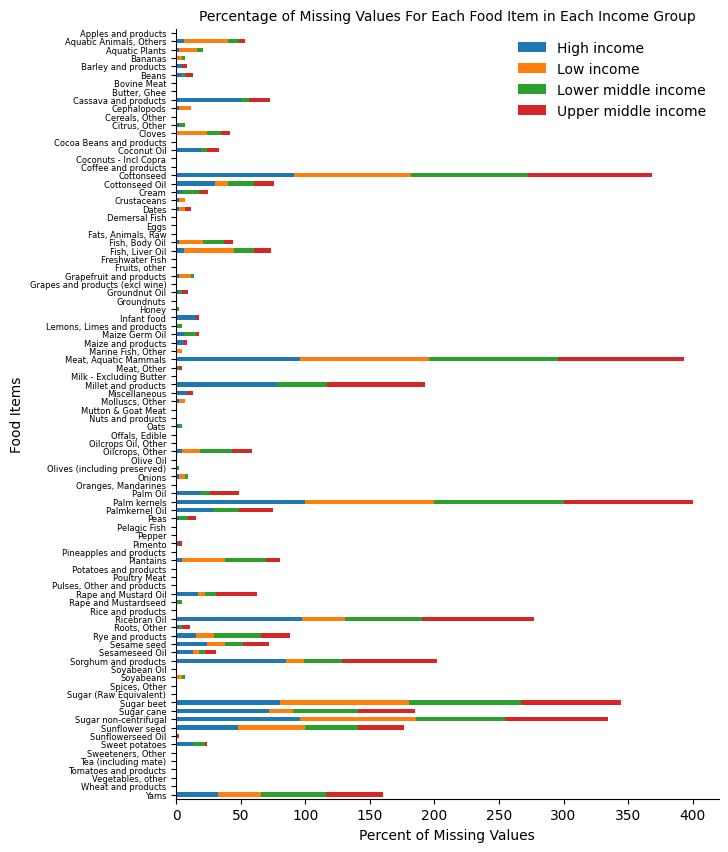

In [156]:
percentage_of_nullity_of_food_groups_pivoted = percentage_of_nullity_of_food_groups.T

#display(percentage_of_nullity_of_food_groups_pivoted)



## 5.3. Visualizing Missingness

#fig = plt.figure()
#fig.set_size_inches(10, 7)

ax = percentage_of_nullity_of_food_groups_pivoted.plot(kind= 'barh',
                                  stacked=True)

ax.figure.set_size_inches(7, 10)
ax.set(xlabel='Percent of Missing Values',
       ylabel='Food Items')
ax.legend(loc='upper right', frameon=False)
for spine in ['top', 'right'] :
    ax.spines[spine].set_visible(False)
ax.set_title('Percentage of Missing Values For Each Food Item in Each Income Group', fontdict={'fontsize' :10})
ax.tick_params(axis='y', which= 'major', labelsize=6)
ax.invert_yaxis()


# plt.savefig("missing_values_shannon.png")

In [27]:
## 5.4. Encoding the categorical values of Region and Size of Economy:  

### 5.4.1. Making sure there aren't any missing values

regions_nullity = transposed_copy_with_size_and_region['Region'].isnull()

size_of_economy_nullity = transposed_copy_with_size_and_region['Income group'].isnull()

print("Region nullity: {}".format(regions_nullity.sum()))

print("Nullity in Size of Economy: {}".format(size_of_economy_nullity.sum()))


Region nullity: 0
Nullity in Size of Economy: 0


In [28]:
## There was one un-classified country in-terms of size-of-economy: Venezuela. Up to the time you're reading this, it is no longer in the dataset. So run the block as it is.

size_of_economy_missing_val = size_of_economy_nullity[size_of_economy_nullity == True]

display(size_of_economy_missing_val)


# Removing Venezuela
#adjusted_transposed_copy = transposed_copy_with_size_and_region.drop('Venezuela, RB', axis=0)

adjusted_transposed_copy = transposed_copy_with_size_and_region

size_of_economy_nullity_updated = adjusted_transposed_copy['Income group'].isnull().sum()

#print("Updated Number of Nullity at Size of Economy / Income group: {}".format(size_of_economy_nullity_updated))


Series([], Name: Income group, dtype: bool)

In [29]:
# Encoding
encoder = OrdinalEncoder()

regions = adjusted_transposed_copy['Region']

income_groups = adjusted_transposed_copy['Income group']

display(pd.DataFrame(regions.unique()))
display(pd.DataFrame(income_groups.unique()))


0
0                  South Asia
1          Sub-Saharan Africa
2       Europe & Central Asia
3  Middle East & North Africa
4   Latin America & Caribbean
5         East Asia & Pacific
6               North America

0
0           Low income
1  Lower middle income
2  Upper middle income
3          High income

In [30]:
reshaped_regions = regions.values.reshape(-1, 1)

reshaped_income_groups = income_groups.values.reshape(-1, 1)

#display(reshaped_regions)

encoded_regions = encoder.fit_transform(reshaped_regions)

encoded_income_groups = encoder.fit_transform(reshaped_income_groups)
adjusted_transposed_copy_for_encoding = adjusted_transposed_copy.copy(deep=True)

adjusted_transposed_copy_for_encoding[adjusted_transposed_copy_for_encoding.columns[1]] = np.squeeze(encoded_regions)
#adjusted_transposed_copy_for_encoding.loc[:, 'Region'] = np.squeeze(encoded_regions) ---> A clearer code, but results into a FutureWarning Error

adjusted_transposed_copy_for_encoding[adjusted_transposed_copy_for_encoding.columns[0]] = np.squeeze(encoded_income_groups)
#adjusted_transposed_copy_for_encoding.loc[:, 'Income group'] = np.squeeze(encoded_income_groups)

display(adjusted_transposed_copy_for_encoding.head(10))


Income group  Region  Apples and products   
Country                                                           
Afghanistan                    1.0     5.0                 2.95  \
Angola                         2.0     6.0                 0.38   
Albania                        3.0     1.0                32.66   
United Arab Emirates           0.0     3.0                 6.75   
Argentina                      3.0     2.0                 5.39   
Armenia                        3.0     1.0                10.58   
Antigua and Barbuda            0.0     2.0                 5.47   
Australia                      0.0     0.0                11.03   
Austria                        0.0     1.0                20.77   
Azerbaijan                     3.0     1.0                15.11   

                      Aquatic Animals, Others  Aquatic Plants  Bananas   
Country                                                                  
Afghanistan                               NaN             NaN     3.11  \
Angola                                   0.00             0.0    37.32   
Albania                                  0.00             0.0     8.26   
United Arab Emirates                     0.00             0.0     8.55   
Argentina                                0.00             0.0    12.66   
Armenia                                  0.00             0.0     7.17   
Antigua and Barbuda                       NaN             0.0    17.87   
Australia                                0.07             0.0    11.07   
Austria                                  0.02             0.0    13.60   
Azerbaijan                               0.00             0.0     3.96   

                      Barley and products  Beans  Bovine Meat  Butter, Ghee   
Country                                                                       
Afghanistan                          0.07   0.00         2.73          0.97  \
Angola                               0.00   7.24         4.17          0.04   
Albania                              0.20   5.03        13.20          1.52   
United Arab Emirates                  NaN   2.30         6.59          1.29   
Argentina                             NaN   2.11        47.98          0.48   
Armenia                              3.89   1.08        24.31          1.34   
Antigua and Barbuda                  0.00   1.03         6.74          1.26   
Australia                            0.00   1.79        26.12          3.81   
Austria                              0.91   0.16        16.08          5.20   
Azerbaijan                           0.00   0.57        12.46          3.61   

                      ...  Sugar non-centrifugal  Sunflower seed   
Country               ...                                          
Afghanistan           ...                    NaN             NaN  \
Angola                ...                    NaN             NaN   
Albania               ...                    NaN             NaN   
United Arab Emirates  ...                    NaN            0.26   
Argentina             ...                    NaN             NaN   
Armenia               ...                    NaN             NaN   
Antigua and Barbuda   ...                    NaN            0.04   
Australia             ...                    NaN             NaN   
Austria               ...                    NaN            0.95   
Azerbaijan            ...                    NaN             NaN   

                      Sunflowerseed Oil  Sweet potatoes  Sweeteners, Other   
Country                                                                      
Afghanistan                        1.27            0.00               0.54  \
Angola                             0.27           39.53               9.23   
Albania                            4.72            0.01              24.22   
United Arab Emirates               0.80            0.46               1.91   
Argentina                         11.17            2.56               8.34   
Armenia         

In [31]:
## 5.5. Preparing Data For Imputation

excessive_missing_values = percentage_of_nullity_of_food_groups_pivoted[percentage_of_nullity_of_food_groups_pivoted.iloc[:, :] > 40]

display(excessive_missing_values.info())


<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, Apples and products to Yams
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   High income          11 non-null     float64
 1   Low income           6 non-null      float64
 2   Lower middle income  9 non-null      float64
 3   Upper middle income  10 non-null     float64
dtypes: float64(4)
memory usage: 5.6+ KB


None

In [32]:
items_without_excessive_missingness = percentage_of_nullity_of_food_groups_pivoted[percentage_of_nullity_of_food_groups_pivoted.iloc[:, :] < 40].dropna()

#display(items_without_excessive_missingness.info())

items_without_excessive_missingness_transposed = items_without_excessive_missingness.T

food_item_list = list(items_without_excessive_missingness_transposed.columns)

#display(food_item_list)


raw_data_for_imputation = adjusted_transposed_copy_for_encoding[food_item_list]

complete_data_for_imputation = pd.merge(adjusted_transposed_copy_for_encoding.iloc[:, 0:2],
                                        raw_data_for_imputation,
                                        left_index=True,
                                        right_index=True)

#display(complete_data_for_imputation.info())



## 5.6.1. Imputing by KNN

knn_imputer = KNN()

imputed_by_knn = pd.DataFrame(knn_imputer.fit_transform(complete_data_for_imputation),
                              columns=complete_data_for_imputation.columns)


## 5.6.2. Imputing by MICE

mice = IterativeImputer()

imputed_by_mice = np.round(pd.DataFrame(mice.fit_transform(complete_data_for_imputation),
                                        index=complete_data_for_imputation.index,
                                        columns=complete_data_for_imputation.columns), 1)


## 5.6.3. Evaluating accuracy of the two methods

# Checking the R-Statistic

# KNN_imputed:

Xknn = sm.add_constant(imputed_by_knn.iloc[:, :-1])
yknn = imputed_by_knn.iloc[:, -1]
lm_knn = sm.OLS(yknn, Xknn).fit()


# MICE_imputed:
Xmice = sm.add_constant(imputed_by_mice.iloc[:, :-1])
ymice = imputed_by_mice.iloc[:, -1]
lm_mice = sm.OLS(ymice, Xmice).fit()



r_squares = pd.DataFrame(dict(KNN_Imputed = lm_knn.rsquared,
                              MICE_Imputed = lm_mice.rsquared), 
                         index= ['Adj. Rsquared'])

coefficients = pd.DataFrame(dict(KNN_Imputed = lm_knn.params,
                                 MICE_Imputed = lm_mice.params))

coefficients_combined = pd.concat((r_squares, coefficients), axis= 0)

display(coefficients_combined.head(2))

#coefficients_combined.to_csv('MICE_vs_KNN_2nd_indicator.csv')

Imputing row 1/156 with 10 missing, elapsed time: 0.029
Imputing row 101/156 with 4 missing, elapsed time: 0.039


KNN_Imputed  MICE_Imputed
Adj. Rsquared     0.882185      0.890507
const           116.161064    115.261280

In [208]:
#display(imputed_by_mice.info())

# Creating a list of Food Items. Use this as a reference when aggregating food items into food groups.
food_items = pd.DataFrame(list(imputed_by_mice.columns),
                          columns= ['Food Items'])
#food_items.to_csv('Food_Items_mod.csv', index=False)



# Combining Foods into Food Groups:
aggregated_food_supplies = {
    'Cereals' : 0,
    'Roots & Tubers' : 0,
    'Vegetables' : 0,
    'Fruits & Plantains' : 0,
    'Seeds, Nuts, and Oils' : 0,
    'Starch and Sugars' : 0,
    'Infant Food' : 0
}


#aggregated_food_supplies['Income group'] = imputed_by_mice['Income group'].values.reshape(-1, 1)

aggregated_food_supplies['Cereals'] = \
        imputed_by_mice['Barley and products'] + \
        imputed_by_mice['Wheat and products'] + \
        imputed_by_mice['Cereals, Other'] + \
        imputed_by_mice['Maize and products'] + \
        imputed_by_mice['Oats'] + \
        imputed_by_mice['Rice and products'] + \
        imputed_by_mice['Rye and products']


aggregated_food_supplies['Roots & Tubers'] = \
        imputed_by_mice['Potatoes and products'] + \
        imputed_by_mice['Roots, Other'] + \
        imputed_by_mice['Sweet potatoes']


aggregated_food_supplies["Dairy and Egg Products"] = \
        imputed_by_mice['Butter, Ghee'] + \
        imputed_by_mice['Cream'] + \
        imputed_by_mice['Eggs'] + \
        imputed_by_mice['Milk - Excluding Butter']


aggregated_food_supplies["Finfish / Shellfish Products"] = \
        imputed_by_mice['Cephalopods'] + \
        imputed_by_mice['Crustaceans'] + \
        imputed_by_mice['Demersal Fish'] + \
        imputed_by_mice['Freshwater Fish'] + \
        imputed_by_mice['Marine Fish, Other'] + \
        imputed_by_mice['Molluscs, Other'] + \
        imputed_by_mice['Pelagic Fish']

aggregated_food_supplies['Beef Products'] = \
        imputed_by_mice['Aquatic Animals, Others'] + \
        imputed_by_mice['Bovine Meat'] + \
        imputed_by_mice['Fats, Animals, Raw'] + \
        imputed_by_mice['Meat, Other'] + \
        imputed_by_mice['Mutton & Goat Meat'] + \
        imputed_by_mice['Offals, Edible']

aggregated_food_supplies["Poultry"] = \
        imputed_by_mice['Poultry Meat']
    
aggregated_food_supplies['Starch and Sugars'] = \
        imputed_by_mice['Honey'] + \
        imputed_by_mice['Sweeteners, Other'] + \
        imputed_by_mice['Sugar (Raw Equivalent)']
        

aggregated_food_supplies["Legume and Legume Products"] = \
        imputed_by_mice['Beans'] + \
        imputed_by_mice['Peas'] + \
        imputed_by_mice['Soyabeans'] + \
        imputed_by_mice['Pulses, Other and products']


aggregated_food_supplies["Spices & Herbs"] = \
        imputed_by_mice['Cloves'] + \
        imputed_by_mice['Spices, Other'] + \
        imputed_by_mice['Tea (including mate)']

aggregated_food_supplies['Vegetables'] = \
        imputed_by_mice['Aquatic Plants'] + \
        imputed_by_mice['Onions'] + \
        imputed_by_mice['Pepper'] + \
        imputed_by_mice['Pimento'] + \
        imputed_by_mice['Vegetables, other'] + \
        imputed_by_mice['Tomatoes and products']
        
    
aggregated_food_supplies['Fruits & Plantains'] = \
        imputed_by_mice['Apples and products'] + \
        imputed_by_mice['Bananas'] + \
        imputed_by_mice['Citrus, Other'] + \
        imputed_by_mice['Oranges, Mandarines'] + \
        imputed_by_mice['Dates'] + \
        imputed_by_mice['Fruits, other'] + \
        imputed_by_mice['Grapefruit and products'] + \
        imputed_by_mice['Grapes and products (excl wine)'] + \
        imputed_by_mice['Lemons, Limes and products'] + \
        imputed_by_mice['Olives (including preserved)'] + \
        imputed_by_mice['Pineapples and products'] + \
        imputed_by_mice['Plantains']
    
    
aggregated_food_supplies['Seeds, Nuts, and Oils'] = \
        imputed_by_mice['Cocoa Beans and products'] + \
        imputed_by_mice['Coconut Oil'] + \
        imputed_by_mice['Coconuts - Incl Copra'] + \
        imputed_by_mice['Coffee and products'] + \
        imputed_by_mice['Cottonseed Oil'] + \
        imputed_by_mice['Fish, Body Oil'] + \
        imputed_by_mice['Fish, Liver Oil'] + \
        imputed_by_mice['Groundnut Oil'] + \
        imputed_by_mice['Groundnuts'] + \
        imputed_by_mice['Nuts and products'] + \
        imputed_by_mice['Maize Germ Oil'] + \
        imputed_by_mice['Oilcrops Oil, Other'] + \
        imputed_by_mice['Oilcrops, Other'] + \
        imputed_by_mice['Olive Oil'] + \
        imputed_by_mice['Palm Oil'] + \
        imputed_by_mice['Palmkernel Oil'] + \
        imputed_by_mice['Rape and Mustard Oil'] + \
        imputed_by_mice['Rape and Mustardseed'] + \
        imputed_by_mice['Sesame seed'] + \
        imputed_by_mice['Sesameseed Oil'] + \
        imputed_by_mice['Sunflowerseed Oil'] + \
        imputed_by_mice['Soyabean Oil']
    
    
aggregated_food_supplies['Infant Food'] = \
        imputed_by_mice['Infant food']



df_aggregated_food_supplies = pd.merge(adjusted_transposed_copy[['Income group', 'Region']],
                                       pd.DataFrame(aggregated_food_supplies, index=imputed_by_mice.index),
                                       left_index=True,
                                       right_index=True).sort_values('Income group')

display(df_aggregated_food_supplies.head(5))

# df_aggregated_food_supplies.to_csv('1_Aggregated_Food_Supplies.csv', index=True) 

Income group                     Region  Cereals  Roots & Tubers   
Country                                                                     
Spain     High income      Europe & Central Asia    113.1            60.3  \
Chile     High income  Latin America & Caribbean    153.3            57.9   
Iceland   High income      Europe & Central Asia     84.4            35.6   
Sweden    High income      Europe & Central Asia    115.0            53.9   
Slovenia  High income      Europe & Central Asia    140.1            38.1   

          Vegetables  Fruits & Plantains  Seeds, Nuts, and Oils   
Country                                                           
Spain          120.2                93.7                   48.5  \
Chile           71.9                59.9                   10.8   
Iceland         77.2                89.1                   28.0   
Sweden          85.1                60.9                   21.8   
Slovenia        99.5               104.7                   16.6   

          Starch and Sugars  Infant Food  Dairy and Egg Products   
Country                                                            
Spain                  32.5          0.4                   182.0  \
Chile                  41.2          0.0                    94.1   
Iceland                80.6          0.3                   232.1   
Sweden                 46.5          0.3                   234.7   
Slovenia               44.7          0.0                   192.0   

          Finfish / Shellfish Products  Beef Products  Poultry   
Country                                                          
Spain                             40.8           21.8     33.3  \
Chile                             14.0           26.8     38.7   
Iceland                           91.2           42.8     31.4   
Sweden                            32.3           32.8     16.3   
Slovenia                          13.2           20.9     29.1   

          Legume and Legume Products  Spices & Herbs  
Country                                               
Spain                            5.8             0.4  
Chile                            3.9             1.5  
Iceland                          1.1             1.6  
Sweden                           2.5             1.1  
Slovenia                         1.4             0.3

In [34]:
# Creating a function for calculating Shannon_diversity

def Shannon_diversity(dataframe) :
    """Calculates Shannon Diversity from the DataFrame"""

    # Creating the "Total Column"
    dataframe.loc[:, "Total"] = dataframe.sum(axis=1)


    # Removing zeroes and NaNs (Dividing columns with these values to the total will bring something nobody wants.)
    some_list = list()
    
    for i, val in dataframe.iterrows():
        j = dataframe.loc[[i]].dropna(axis=1)

        j = j.loc[:, (j != 0).any(axis=0)]

        some_list.append(j)

    
    # The Shannon Diversity Index
    container_1 = list()

    for i in range(len(some_list)):
        frame = some_list[i]

        container_2 = list()

        for col in frame :
            if col != "Total":
                d_index = abs(frame[col] / frame["Total"] * np.log(frame[col] / frame["Total"]))

                container_2.append(d_index)
            else:
                continue

            index_array = np.array(container_2).sum()


        container_1.append(index_array)


    dataframe.loc[:, "Production Diversity Indeces"] = container_1

    return pd.DataFrame(dataframe.loc[:, "Production Diversity Indeces"])

In [35]:
# Calculating Shannon Diversity Indeces for countries in the food supply table

food_supply_diversity_shannon = Shannon_diversity(df_aggregated_food_supplies.iloc[:, 2:])

food_supply_diversity_shannon

Production Diversity Indeces
Country                                         
Spain                                   2.138885
Chile                                   2.105233
Iceland                                 2.115612
Sweden                                  2.019177
Slovenia                                1.987958
...                                          ...
Mexico                                  2.034659
Ecuador                                 1.950009
Dominican Republic                      1.849328
Cuba                                    2.050092
Lebanon                                 2.085413

[156 rows x 1 columns]

In [36]:
# Attaching the Shannon data with sizes of economy

food_supply_diversity_economized = pd.merge(size_of_economy,
                                            food_supply_diversity_shannon,
                                            left_index=True,
                                            right_index=True).drop("Region", axis=1)

food_supply_diversity_economized

Income group  Production Diversity Indeces
Country                                                                
Afghanistan                    Low income                      1.698129
Angola                Lower middle income                      1.966925
Albania               Upper middle income                      1.792816
United Arab Emirates          High income                      2.225301
Argentina             Upper middle income                      2.158191
...                                   ...                           ...
Vanuatu               Lower middle income                      1.939273
Samoa                 Lower middle income                      2.091022
South Africa          Upper middle income                      2.011364
Zambia                Lower middle income                      1.665099
Zimbabwe              Lower middle income                      1.844348

[156 rows x 2 columns]

In [37]:
# Exploratory Data Analysis: Whlich country group has higher diversity

food_diversity_grouped_by_mean = food_supply_diversity_economized.groupby("Income group").mean()

display(food_diversity_grouped_by_mean)

food_diversity_grouped_by_median = food_supply_diversity_economized.groupby("Income group").median()

display(food_diversity_grouped_by_median)

Production Diversity Indeces
Income group                                     
High income                              2.071434
Low income                               1.808516
Lower middle income                      1.848279
Upper middle income                      1.986051

Production Diversity Indeces
Income group                                     
High income                              2.088878
Low income                               1.775004
Lower middle income                      1.854956
Upper middle income                      2.010195

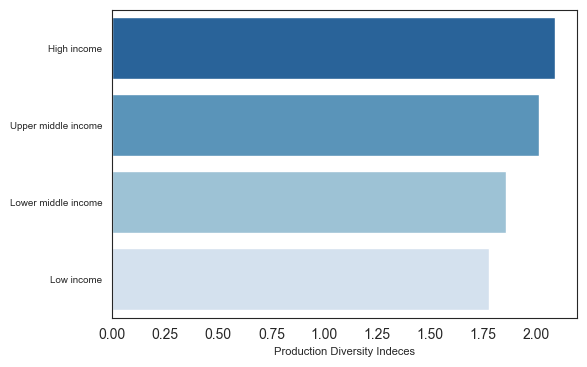

In [451]:
# Plotting the information above

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

df = food_diversity_grouped_by_median.sort_values("Production Diversity Indeces", ascending=False)

bar_plotter(x="Production Diversity Indeces",
            y= df.index,
            df=df,
            ax=ax,
            xlabel="Production Diversity Indeces",
            palette="Blues_r")

plt.show()

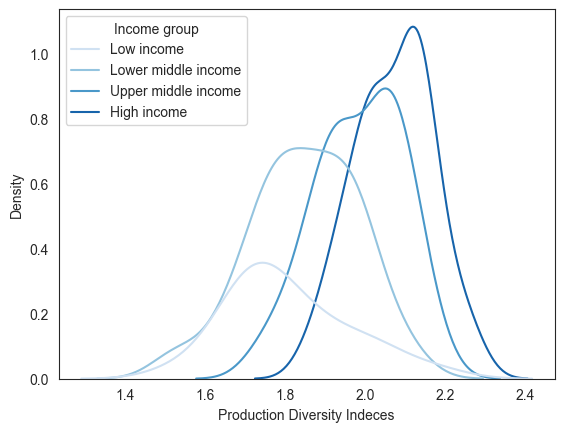

In [465]:
# Plotting a KDE plot to visualize the distribution of Shannon Values

fig, ax = plt.subplots()

sns.kdeplot(data=food_supply_diversity_economized,
            x= "Production Diversity Indeces",
            hue= "Income group",
            ax=ax,
            palette="Blues")

plt.show()

# plt.savefig("kde_shannon.png") # It kept exporting a blank image. If you're using VS Code as I'm, go to the top-right corner of the output. You'll see the option to save the image there.

In [38]:
# Number of countries from each group in this indicator

df_aggregated_food_supplies.groupby("Income group").count().iloc[:, 0]

Income group
High income            46
Low income             21
Lower middle income    44
Upper middle income    45
Name: Region, dtype: int64

### Indicator 3: Modified Functional Attibutite Diversity

In [39]:
#1. Merging the Food Supply Data from FAO and the Food Composition table.

# 1.1 Taking a glimpse of the food supply data to see the names of the foods used there.

display(imputed_by_mice.head(3))

Income group  Region  Apples and products   
Country                                                  
Afghanistan           1.0     5.0                  3.0  \
Angola                2.0     6.0                  0.4   
Albania               3.0     1.0                 32.7   

             Aquatic Animals, Others  Aquatic Plants  Bananas   
Country                                                         
Afghanistan                      0.1            -0.0      3.1  \
Angola                           0.0             0.0     37.3   
Albania                          0.0             0.0      8.3   

             Barley and products  Beans  Bovine Meat  Butter, Ghee  ...   
Country                                                             ...   
Afghanistan                  0.1    0.0          2.7           1.0  ...  \
Angola                       0.0    7.2          4.2           0.0  ...   
Albania                      0.2    5.0         13.2           1.5  ...   

             Soyabeans  Spices, Other  Sugar (Raw Equivalent)   
Country                                                         
Afghanistan        0.0            0.1                    15.2  \
Angola             0.4            0.0                    12.5   
Albania            0.0            0.0                    16.6   

             Sunflowerseed Oil  Sweet potatoes  Sweeteners, Other   
Country                                                             
Afghanistan                1.3             0.0                0.5  \
Angola                     0.3            39.5                9.2   
Albania                    4.7             0.0               24.2   

             Tea (including mate)  Tomatoes and products  Vegetables, other   
Country                                                                       
Afghanistan                   2.0                    0.9               55.4  \
Angola                        0.0                    2.1               20.5   
Albania                       0.2                   77.9              217.4   

             Wheat and products  
Country                          
Afghanistan               159.0  
Angola                     27.2  
Albania                   124.7  

[3 rows x 82 columns]

In [284]:
# 1.2 Importing the Food Composition Data

food_composition_table = pd.read_csv('food_composition_data.csv')

# display(food_composition_table.head())


# food_composition_table.pivot_table(index= ["food_name", "food_group"],
#                                    columns="nutr_name",
#                                    values="nutr_value").iloc[60:80]

In [41]:
# DO NOT RUN THIS PIECE OF CODE. ITS OUTPUT HAS ALREADY BEEN SAVED AND USED IN THE FOLLOWING CODE SNIPPETS.


## 1.5 Condensing food items such that we've a median value of nutrient values of each nutrient from each food type.

### I. Take a peek of your data

#display(food_composition_transposed.head())


### II. The initial columns' names are confusing. Taking them to the back

# food_compos_modified = food_composition_transposed[food_composition_transposed.columns.sort_values(ascending=False)]

#display(food_compos_modified.head())



### III. We don't want an index name for the columns. Removing it, and resetting row indexes to be food codes.

# better_food_compos_table = food_compos_modified.rename_axis(None, axis=1).reset_index()

# better_food_compos_table_1 = better_food_compos_table.set_index('food_code')

#display(better_food_compos_table_1.head())



### IV. Beginning condensing the foods: Writting a program that will do just that

# condensed_foods = pd.DataFrame()

# food_compos_aft_reduction = pd.DataFrame


def food_condenser() :    
    """ Condenses similar food types of a similar food group from the food_composition table """
    
    
    # Designing a better user experience btn the 1st iteration and the subsequent ones
    first_iter = 0
    
    new_iter = 0
    
    
    # Iteration starts
    while new_iter == first_iter :
        
        new_iter = 1 + first_iter
        
        start = input('Welcome. Should I start condensing? [Y/n]: ').upper()
        
        while start == 'Y' :
    
            print("""
            This is a preview of the food composition table as it is now. \n
            Please choose any word from the "food_name" column and the "food_group" column \n
            and then enter them in the prompts that follow..\n
            DO NOT WRITE the whole string for the food name, just the main food type (eg. butter, cheese, etc,)
            For the Food Group name, write the whole name. \n
            
            ATTENTION: Names in the "food_group" column are case sensitive.
            """.upper())
        
            display(better_food_compos_table_1.head(4))
            
            
            # Taking the group name
            food_group = input('Please write the food_group name: ')
            
            
            # Filtering the main_compos table for the aforementioned food_group
            group = better_food_compos_table_1[better_food_compos_table_1['food_group'].str.contains(food_group)]
            
            
            # Cutting of the desired food_group from the main-compos table
            remaining_groups = better_food_compos_table_1[ ~better_food_compos_table_1['food_group'] \
                                                         .isin(group['food_group'])
                                                        ]
            
            
            # Updating the food_compos table such that we only have food that haven't been condensed:
            food_compos_aft_reduction = remaining_groups
            
            
            # Getting the medium values for all nutrients in the desired food_and_food_group table
            median_vals = pd.DataFrame(data=group.iloc[:, 2:].aggregate('median', axis=0)).T
            
            
            # Attaching the food_name and food_group_name to the median values
            food_name = pd.DataFrame(data=[food_group], columns=['food_group'])

            compressed_values = pd.concat([food_name, median_vals], axis=1)
            
            
            # Attaching this to the "Condensed_foods" table
            
            global condensed_foods
            
            condensed_foods = pd.concat([condensed_foods, compressed_values], axis=0)
            
            display(condensed_foods)
            
            start = 'n'

    
    # For Subsequent iterations
    continuation = input('Do you want to repeat this process? [Y/n]: ').upper()
    
    
    while continuation == 'Y' :
            
        count = new_iter + 1
            
        print("""The names in the "food_group" column are case sensitive, remember that.\n
        This is the preview of the table as it is now.""".upper())
            
        display(food_compos_aft_reduction.head(4))
            
            
        # Taking the name of the food
        #name = input('Please write the food name: ').upper()
            
            
        # Taking the group name
        food_group = input('Please write the food_group name: ')
            
            
        # Filtering the main_compos table for the aforementioned food
        group = food_compos_aft_reduction[food_compos_aft_reduction['food_group'].str.contains(food_group)]
            
            
        # Cutting of the desired food from the main-compos table
        remaining_groups = food_compos_aft_reduction[ ~food_compos_aft_reduction['food_name'] \
                                                         .isin(group['food_name'])
                                                        ]
            
            
        # Updating the food_compos table such that we only have food that haven't been condensed:
        food_compos_aft_reduction = remaining_groups
            
            
        # Getting the medium values for all nutrients in the desired food_and_food_group table
        median_vals = pd.DataFrame(data=group.iloc[:, 2:].aggregate('median', axis=0)).T
            
            
        # Attaching the food_name and food_group_name to the median values
        food_name = pd.DataFrame(data=[food_group], columns=['food_group'])

        compressed_values = pd.concat([food_name, median_vals], axis=1)
            
            
        # Attaching this to the "Condensed_foods" table
        condensed_foods = pd.concat([condensed_foods, compressed_values], axis=0)
        
        
        # displaying the new "condensed_foods" table
        display(condensed_foods)
                
        # Re-running the procedure
        continuation = input('Do you want to repeat this process? [Y/n]: ').upper()
        
        
    return condensed_foods


# Condensing: Iteration 1:
#food_condenser()

#display(condensed_foods)

##### Notes for the food condenser

I took the median value for each food group to make the process of condensing the foods easier and straightforward.  

There were too many foods, and their names were formatted differently. The way I've done it is the easiest way to be able to generalize the nutrition value for each food group.

In [42]:
# Saving the output table to a variable and resetting the index
#condensed_food_compos = condensed_foods.reset_index()

#display(condensed_food_compos)


# Removing the first "index" column:
#condensed_food_compos_table = condensed_food_compos.drop("index", axis=1)

#display(condensed_food_compos_table)


# Saving the output to csv:
#condensed_food_compos_table.to_csv("Condensed_Food_Composition_Table.csv", index=True)

In [43]:
# UPLOADING THE TABLE ABOVE AGAIN AFTER SOME TIME

nutritional_content_table = pd.read_csv("01. Clean Datasets/Indicator_3/1_Condensed_Food_Composition_Table.csv")

display(nutritional_content_table.head())

Unnamed: 0              food_group  Zinc, Zn   Water   
0           0  Dairy and Egg Products     0.825  63.550  \
1           1        Spices and Herbs     2.840   9.310   
2           2              Baby Foods     0.490  83.200   
3           3           Fats and Oils     0.000   0.070   
4           4        Poultry Products     2.020  66.505   

   Vitamin K (phylloquinone)  Vitamin E, added  Vitamin E (alpha-tocopherol)   
0                        0.6               0.0                          0.18  \
1                       24.6               0.0                          1.69   
2                        5.1               0.0                          0.56   
3                       42.2               0.0                          5.00   
4                        0.0               0.0                          0.22   

   Vitamin D3 (cholecalciferol)  Vitamin D2 (ergocalciferol)   
0                           0.5                          0.0  \
1                           NaN                          NaN   
2                           0.1                          0.0   
3                           0.7                          0.0   
4                           0.2                          NaN   

   Vitamin D (D2 + D3)  ...  16:1 t  16:1 c    16:0  15:1   15:0   14:1   
0                  0.5  ...  0.0335  0.1210  1.9930   0.0  0.020  0.016  \
1                  0.0  ...  0.0000  0.0080  0.5740   0.0  0.000  0.000   
2                  0.0  ...  0.0000  0.0010  0.4260   0.0  0.000  0.000   
3                  0.0  ...  0.0000  0.0685  7.9895   0.0  0.014  0.000   
4                  0.2  ...  0.0040  0.1970  1.5200   0.0  0.006  0.008   

    14:0    13:0   12:0   10:0  
0  0.297  0.0000  0.093  0.076  
1  0.020  0.0000  0.002  0.000  
2  0.031  0.0000  0.007  0.001  
3  0.095  0.0005  0.000  0.000  
4  0.056     NaN  0.010  0.000  

[5 rows x 151 columns]

In [44]:
# Removing the column "Unnamed" and the last row that is empty:
nutrition_table = nutritional_content_table.iloc[:17, 1:].set_index("food_group")

#display(nutrition_table)

groups_nutrition_table = nutrition_table.index

#display(groups_nutrition_table)



# Combining the groups such that one has groups equal to the ones in the intake tables.
nutrition_table

nutrition_table.loc["Beef Products"] = nutrition_table.loc["Beef Products"] + \
                                       nutrition_table.loc["Sausages and Luncheon Meats"]

nutrition_table.loc["Seeds, Nuts, and Oils"] = nutrition_table.loc["Nut and Seed Products"] + \
                                    nutrition_table.loc["Fats and Oils"]

nutrition_table.loc["Breakfast Cereals"] = nutrition_table.loc["Breakfast Cereals"] + \
                                           nutrition_table.loc["Soups, Sauces, and Gravies"] + \
                                           nutrition_table.loc["Snacks"]

nutrition_table = nutrition_table.drop(["Sausages and Luncheon Meats", 
                                        "Fats and Oils", 
                                        "Soups, Sauces, and Gravies", 
                                        "Snacks",
                                        "Nut and Seed Products"])

nutrition_table

Zinc, Zn    Water   
food_group                                             
Dairy and Egg Products                0.825   63.550  \
Spices and Herbs                      2.840    9.310   
Baby Foods                            0.490   83.200   
Poultry Products                      2.020   66.505   
Breakfast Cereals                     4.310   97.495   
Fruits and Fruit Juices               0.090   84.010   
Pork Products                         2.275   65.125   
Vegetables and Vegetable Products     0.330   89.180   
Beef Products                         6.990  118.575   
Beverages                             0.030   87.855   
Finfish and Shellfish Products        0.660   72.970   
Legumes and Legume Products           1.090   69.000   
Seeds, Nuts, and Oils                 3.310    4.460   

                                   Vitamin K (phylloquinone)   
food_group                                                     
Dairy and Egg Products                                  0.60  \
Spices and Herbs                                       24.60   
Baby Foods                                              5.10   
Poultry Products                                        0.00   
Breakfast Cereals                                       4.55   
Fruits and Fruit Juices                                 1.55   
Pork Products                                           0.00   
Vegetables and Vegetable Products                       9.50   
Beef Products                                           2.00   
Beverages                                               0.00   
Finfish and Shellfish Products                          0.10   
Legumes and Legume Products                             3.00   
Seeds, Nuts, and Oils                                  44.90   

                                   Vitamin E, added   
food_group                                            
Dairy and Egg Products                          0.0  \
Spices and Herbs                                0.0   
Baby Foods                                      0.0   
Poultry Products                                0.0   
Breakfast Cereals                               0.0   
Fruits and Fruit Juices                         0.0   
Pork Products                                   0.0   
Vegetables and Vegetable Products               0.0   
Beef Products                                   0.0   
Beverages                                       0.0   
Finfish and Shellfish Products                  0.0   
Legumes and Legume Products                     0.0   
Seeds, Nuts, and Oils                           0.0   

                                   Vitamin E (alpha-tocopherol)   
food_group                                                        
Dairy and Egg Products                                    0.180  \
Spices and Herbs                                          1.690   
Baby Foods                                                0.560   
Poultry Products                                          0.220   
Breakfast Cereals                                         2.430   
Fruits and Fruit Juices                                   0.180   
Pork Products                                             0.220   
Vegetables and Vegetable Products                         0.295   
Beef Products                                             0.540   
Beverages                                                 0.000   
Finfish and Shellfish Products                            0.890   
Legumes and Legume Products                               0.255   
Seeds, Nuts, and Oils                                     7.530   

                                   Vitamin D3 (cholecalciferol)   
food_group                                                        
Dairy and Egg Products                                     0.50  \
Spices and Herbs                                            NaN   
Baby Foods                                                 0.10   
Poultry Products                                           0.20   

In [374]:
# Checking the modified functional diversity of the groups above before we combine them to make the seven groups we've been using since the beginning.

# Writing the MFAD function
def MFAD(df):
    """Calculates the MFAD value for a given df"""


    # Giving the user the picture of their dataset
    display("""Below is the dataframe as it is now:""")

    display(df)

    proceed = input("Do you want to proceed [y/n]: ").upper()


    # Calculating the MFAD
    
    MFAD_values = list()

    # defining the starting and ending points of the summation symbols.
    n = range(1, df.index.__len__()+1)
    
    while proceed == "Y" :
        species = int(input("Put the index of the item you want to use as your 'i': "))

        for j, val in df.iterrows():
            if j == df.iloc[[species]].index :
                continue
            else :
                distance = np.sqrt(((df.iloc[species] - val)**2).sum()) # Calculates the Eucledian distance.

                mfad = (distance / df.columns.__len__()) / 10000 # Completes the MFAD formula

                i = df.iloc[[species]].index.item() # Extracts the index for the i

                MFAD_values.append({f"{i} - {j}" : mfad})

        proceed = input("Do you have more food items for eucledian distance? [y/n]:").upper()

    
    MFAD_values = pd.DataFrame(MFAD_values).T#.rename_axis("eucledian(i - j)").T


    # Creating a program that names columns according to the number of items in the dataset.
    frame = pd.DataFrame()

    some_list = list()
    
    # Removing NAN's from each row in the dataset
    for i, val in MFAD_values.iterrows():
        j = MFAD_values.loc[[i]].dropna(axis=1)

        some_list.append(j)

        
    for i in range(0, len(some_list)) :
        some_list[i].columns = ["mfad_values"]

        frame = pd.concat([frame, some_list[i]], axis=0, ignore_index=False)

    # Removing duplicate values
    clean_frame = frame.drop_duplicates()


    # # Normalizing the MFAD values
    # clean_frame.loc[:, "Normalized_MFAD"] = (clean_frame["mfad_values"] - clean_frame["mfad_values"].mean()) /\
    #                                           (clean_frame["mfad_values"].max() - clean_frame["mfad_values"].min())


    # # Summing the mfad values from each iteration of i/j up to n
    clean_frame.loc["Total"] = clean_frame["mfad_values"].sum()

    return clean_frame

In [341]:
# Loading the food supply table

df_aggregated_food_supplies.head()

Income group                     Region  Cereals  Roots & Tubers   
Country                                                                     
Spain     High income      Europe & Central Asia    113.1            60.3  \
Chile     High income  Latin America & Caribbean    153.3            57.9   
Iceland   High income      Europe & Central Asia     84.4            35.6   
Sweden    High income      Europe & Central Asia    115.0            53.9   
Slovenia  High income      Europe & Central Asia    140.1            38.1   

          Vegetables  Fruits & Plantains  Seeds, Nuts, and Oils   
Country                                                           
Spain          120.2                93.7                   48.5  \
Chile           71.9                59.9                   10.8   
Iceland         77.2                89.1                   28.0   
Sweden          85.1                60.9                   21.8   
Slovenia        99.5               104.7                   16.6   

          Starch and Sugars  Infant Food  Dairy and Egg Products   
Country                                                            
Spain                  32.5          0.4                   182.0  \
Chile                  41.2          0.0                    94.1   
Iceland                80.6          0.3                   232.1   
Sweden                 46.5          0.3                   234.7   
Slovenia               44.7          0.0                   192.0   

          Finfish / Shellfish Products  Beef Products  Poultry   
Country                                                          
Spain                             40.8           21.8     33.3  \
Chile                             14.0           26.8     38.7   
Iceland                           91.2           42.8     31.4   
Sweden                            32.3           32.8     16.3   
Slovenia                          13.2           20.9     29.1   

          Legume and Legume Products  Spices & Herbs  
Country                                               
Spain                            5.8             0.4  
Chile                            3.9             1.5  
Iceland                          1.1             1.6  
Sweden                           2.5             1.1  
Slovenia                         1.4             0.3

In [347]:
# Grouping the data according to "Income group"

food_supplies_grouped = df_aggregated_food_supplies.drop("Region", axis=1).groupby("Income group")

median_food_supplies = food_supplies_grouped.median()

mean_food_supplies = food_supplies_grouped.mean()

# display(median_food_supplies)
# display(mean_food_supplies)

In [350]:
# The median_food_supplies table was taken for data robustness

## Multiplying the values to turn them into grams. Multiplied by ten because the values in the composition table are expressed in-terms of 100 grams.

median_food_supplies_in_grams = np.round(mean_food_supplies * 10)

median_food_supplies_in_grams

Cereals  Roots & Tubers  Vegetables  Fruits & Plantains   
Income group                                                                   
High income           1244.0           463.0      1002.0               834.0  \
Low income            1111.0           331.0       512.0               719.0   
Lower middle income   1610.0           437.0       728.0               748.0   
Upper middle income   1472.0           482.0      1135.0              1034.0   

                     Seeds, Nuts, and Oils  Starch and Sugars  Infant Food   
Income group                                                                 
High income                          298.0              531.0          5.0  \
Low income                           161.0              116.0          1.0   
Lower middle income                  298.0              290.0          2.0   
Upper middle income                  222.0              471.0          4.0   

                     Dairy and Egg Products  Finfish / Shellfish Products   
Income group                                                                
High income                          1591.0                         287.0  \
Low income                            346.0                          69.0   
Lower middle income                   492.0                         164.0   
Upper middle income                  1116.0                         159.0   

                     Beef Products  Poultry  Legume and Legume Products   
Income group                                                              
High income                  250.0    316.0                        46.0  \
Low income                   125.0     39.0                       139.0   
Lower middle income          164.0    115.0                        84.0   
Upper middle income          200.0    281.0                        57.0   

                     Spices & Herbs  
Income group                         
High income                    16.0  
Low income                      5.0  
Lower middle income            14.0  
Upper middle income            24.0

In [351]:
# Checking the food group names in the composition table

nutrition_table

Zinc, Zn    Water   
food_group                                             
Dairy and Egg Products                0.825   63.550  \
Spices and Herbs                      2.840    9.310   
Baby Foods                            0.490   83.200   
Poultry Products                      2.020   66.505   
Breakfast Cereals                     4.310   97.495   
Fruits and Fruit Juices               0.090   84.010   
Pork Products                         2.275   65.125   
Vegetables and Vegetable Products     0.330   89.180   
Beef Products                         6.990  118.575   
Beverages                             0.030   87.855   
Finfish and Shellfish Products        0.660   72.970   
Legumes and Legume Products           1.090   69.000   
Seeds, Nuts, and Oils                 3.310    4.460   

                                   Vitamin K (phylloquinone)   
food_group                                                     
Dairy and Egg Products                                  0.60  \
Spices and Herbs                                       24.60   
Baby Foods                                              5.10   
Poultry Products                                        0.00   
Breakfast Cereals                                       4.55   
Fruits and Fruit Juices                                 1.55   
Pork Products                                           0.00   
Vegetables and Vegetable Products                       9.50   
Beef Products                                           2.00   
Beverages                                               0.00   
Finfish and Shellfish Products                          0.10   
Legumes and Legume Products                             3.00   
Seeds, Nuts, and Oils                                  44.90   

                                   Vitamin E, added   
food_group                                            
Dairy and Egg Products                          0.0  \
Spices and Herbs                                0.0   
Baby Foods                                      0.0   
Poultry Products                                0.0   
Breakfast Cereals                               0.0   
Fruits and Fruit Juices                         0.0   
Pork Products                                   0.0   
Vegetables and Vegetable Products               0.0   
Beef Products                                   0.0   
Beverages                                       0.0   
Finfish and Shellfish Products                  0.0   
Legumes and Legume Products                     0.0   
Seeds, Nuts, and Oils                           0.0   

                                   Vitamin E (alpha-tocopherol)   
food_group                                                        
Dairy and Egg Products                                    0.180  \
Spices and Herbs                                          1.690   
Baby Foods                                                0.560   
Poultry Products                                          0.220   
Breakfast Cereals                                         2.430   
Fruits and Fruit Juices                                   0.180   
Pork Products                                             0.220   
Vegetables and Vegetable Products                         0.295   
Beef Products                                             0.540   
Beverages                                                 0.000   
Finfish and Shellfish Products                            0.890   
Legumes and Legume Products                               0.255   
Seeds, Nuts, and Oils                                     7.530   

                                   Vitamin D3 (cholecalciferol)   
food_group                                                        
Dairy and Egg Products                                     0.50  \
Spices and Herbs                                            NaN   
Baby Foods                                                 0.10   
Poultry Products                                           0.20   

In [368]:
# Multiplying values from each income group to determine the nutrient supply in the economy

# Creating a function that'll do that
def nutrient_supply(df) :
    """Calculates nutrient supplies for a particular country or country group"""

    column_names = list(nutrition_table.columns.values)

    index_names = list(df.columns.values)

    index_names.remove("Roots & Tubers")

    nutrient_supplies = pd.DataFrame([df["Cereals"].values * nutrition_table.loc["Breakfast Cereals"].values,
                                      df["Vegetables"].values * nutrition_table.loc["Vegetables and Vegetable Products"].values,
                                      df["Fruits & Plantains"].values * nutrition_table.loc["Fruits and Fruit Juices"].values,
                                      df["Seeds, Nuts, and Oils"].values * nutrition_table.loc["Seeds, Nuts, and Oils"].values,
                                      df["Starch and Sugars"].values * nutrition_table.loc["Beverages"].values,
                                      df["Infant Food"].values * nutrition_table.loc["Baby Foods"].values,
                                      df["Dairy and Egg Products"].values * nutrition_table.loc["Dairy and Egg Products"].values,
                                      df["Finfish / Shellfish Products"].values * nutrition_table.loc["Finfish and Shellfish Products"].values,
                                      df["Beef Products"].values * nutrition_table.loc["Beef Products"].values,
                                      df["Poultry"].values * nutrition_table.loc["Poultry Products"].values,
                                      df["Legume and Legume Products"].values * nutrition_table.loc["Legumes and Legume Products"].values,
                                      df["Spices & Herbs"].values * nutrition_table.loc["Spices and Herbs"].values])
    
    nutrient_supplies.columns = column_names

    nutrient_supplies.index = index_names
    
    return nutrient_supplies



nutrient_supply_high_income = nutrient_supply(median_food_supplies_in_grams.loc[["High income"]])

nutrient_supply_upper_middle = nutrient_supply(median_food_supplies_in_grams.loc[["Upper middle income"]])

nutrient_supply_lower_middle = nutrient_supply(median_food_supplies_in_grams.loc[["Lower middle income"]])

nutrient_supply_low_income = nutrient_supply(median_food_supplies_in_grams.loc[["Low income"]])


# Just for checking if everything worked out

# display(nutrient_supply_lower_middle)

In [390]:
# Calculating the MFAD values for each nutrient supply table

# mfad_low_income = MFAD(nutrient_supply_low_income)

# mfad_high_income = MFAD(nutrient_supply_high_income)

# mfad_lower_middle = MFAD(nutrient_supply_lower_middle)

# mfad_upper_middle = MFAD(nutrient_supply_upper_middle)


# Just Checking one of the output

# mfad_lower_middle

In [392]:
# Saving the outputs of the tables above so that I don't have to re-run the piece of code above

# mfad_low_income.to_csv("01. Clean Datasets/Metric_1/Indicator_3/3_mfad_low_income.csv")

# mfad_lower_middle.to_csv("01. Clean Datasets/Metric_1/Indicator_3/4_mfad_lower_middle.csv")

# mfad_upper_middle.to_csv("01. Clean Datasets/Metric_1/Indicator_3/5_mfad_upper_middle.csv")

# mfad_high_income.to_csv("01. Clean Datasets/Metric_1/Indicator_3/6_mfad_high_income.csv")

In [397]:
# Loading in the mfad datasets: You have to the set index again as Microsoft re-indexes the frame automatically when you save it in csv 
mfad_low_income = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/3_mfad_low_income.csv").set_index("Unnamed: 0")

mfad_lower_middle = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/4_mfad_lower_middle.csv").set_index("Unnamed: 0")

mfad_upper_middle = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/5_mfad_upper_middle.csv").set_index("Unnamed: 0")

mfad_high_income = pd.read_csv("01. Clean Datasets/Metric_1/Indicator_3/6_mfad_high_income.csv").set_index("Unnamed: 0")



# Combining MFAD values of each income group
mfad_all_groups = pd.DataFrame([mfad_low_income.loc["Total"].values[0],
                                mfad_lower_middle.loc["Total"].values[0],
                                mfad_upper_middle.loc["Total"].values[0],
                                mfad_high_income.loc["Total"].values[0]],
                                columns=["mfad_values"],
                                index=["Low income", 
                                       "Lower middle income",
                                       "Upper middle income",
                                       "High income"])

mfad_all_groups

mfad_values
Low income             34.807447
Lower middle income    51.482283
Upper middle income    49.566934
High income            47.364805

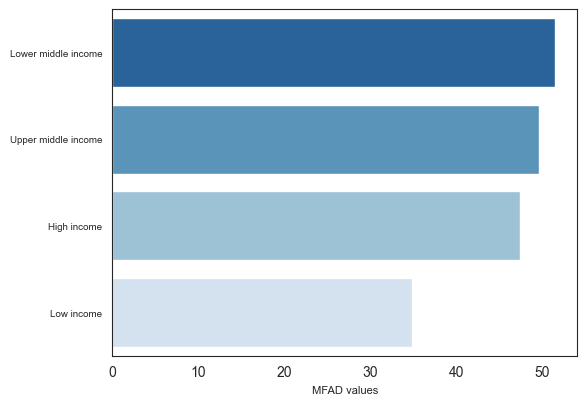

In [471]:
# Plotting this information

df = mfad_all_groups.sort_values("mfad_values", ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(6, 4.5)

bar_plotter(x="mfad_values",
            y=df.index,
            ax=ax,
            df=df,
            palette="Blues_r",
            xlabel="MFAD values")

plt.show()

### Indicator 4: Nutrient Balance Score

## Metric 2: Ecosystem Stability

### 1st Indicator: Ecosystem Status

In [50]:
# Loading the dataset

epi = pd.read_csv("materials_and_methods/Metric_2/indicator_1.csv")

epi.head()

code  iso               country                     region  EPI.new   
0     4  AFG           Afghanistan              Southern Asia     43.6  \
1    24  AGO                Angola         Sub-Saharan Africa     30.5   
2     8  ALB               Albania             Eastern Europe     47.1   
3   784  ARE  United Arab Emirates        Greater Middle East     52.4   
4    32  ARG             Argentina  Latin America & Caribbean     41.1   

   HLT.new  AIR.new  HAD.new  PMD.new  OZD.new  ...  CCH.rnk.old  CDA.rnk.old   
0     16.0     15.5      7.4     16.0     18.4  ...          159          161  \
1     20.5     23.1     17.9     24.0     36.8  ...           81           29   
2     40.0     37.5     34.5     36.7     63.7  ...          108          156   
3     49.4     41.7    100.0      3.4     20.4  ...          171          143   
4     56.3     52.0     60.5     48.2     51.8  ...          148           99   

   CHA.rnk.old  FGA.rnk.old  NDA.rnk.old  BCA.rnk.old  GHN.rnk.old   
0          164          NaN          141          142          112  \
1           35         77.0          132          105          119   
2           26         77.0           70          173           39   
3          112         37.0          163          134          157   
4          107         59.0          128            1          160   

   LCB.rnk.old  GIB.rnk.old  GHP.rnk.old  
0         12.0          129            1  
1        135.0            1           87  
2         37.0           25           67  
3        162.0          141          173  
4        128.0           93          134  

[5 rows x 279 columns]

In [51]:
# Removing unwanted columns and resetting the index.

epi_cleaned = epi.iloc[:, [2, 4]].set_index("country")

epi_cleaned.head()

EPI.new
country                      
Afghanistan              43.6
Angola                   30.5
Albania                  47.1
United Arab Emirates     52.4
Argentina                41.1

In [472]:
# Joining that data with sizes of economy

epi_economized = pd.merge(size_of_economy,
                          epi_cleaned,
                          left_index=True,
                          right_index=True).drop("Region", axis=1)


epi_economized.head()

Income group  EPI.new
Afghanistan                    Low income     43.6
Angola                Lower middle income     30.5
Albania               Upper middle income     47.1
United Arab Emirates          High income     52.4
Argentina             Upper middle income     41.1

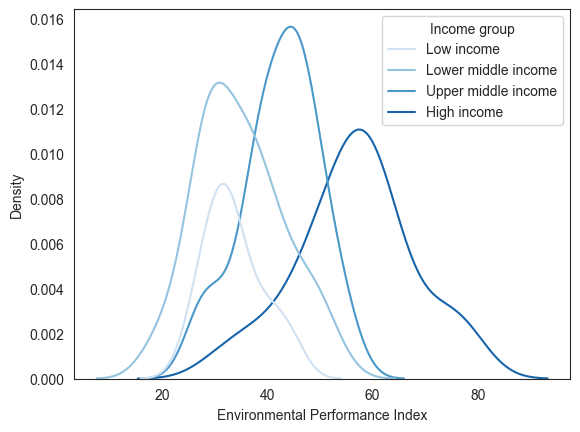

In [496]:
# Visualizing the information above

fig, ax = plt.subplots()

sns.kdeplot(data=epi_economized,
            x= "EPI.new",
            hue= "Income group",
            ax=ax,
            palette="Blues").set(xlabel="Environmental Performance Index")

plt.show()

In [475]:
# Summarizing the Data

epi_grouped_by_median = epi_economized.groupby("Income group").median().sort_values("EPI.new", ascending=False)

epi_grouped_by_mean = epi_economized.groupby("Income group").mean().sort_values("EPI.new", ascending=False)

display(epi_grouped_by_median)
display(epi_grouped_by_mean)

EPI.new
Income group                
High income            57.20
Upper middle income    43.60
Lower middle income    34.20
Low income             32.25

EPI.new
Income group                  
High income          56.608511
Upper middle income  42.489583
Lower middle income  34.744681
Low income           33.610000

### 2nd Indicator: Per Capita GHG Emissions

In [497]:
# Loading the dataset

emissions = pd.read_csv("materials_and_methods/Metric_2/indicator_2.csv")

emissions.head()


Entity Code  Year  Aviation and shipping (per capita)   
0  Afghanistan  AFG  1990                            0.001870  \
1  Afghanistan  AFG  1991                            0.001861   
2  Afghanistan  AFG  1992                            0.001659   
3  Afghanistan  AFG  1993                            0.001428   
4  Afghanistan  AFG  1994                            0.001294   

   Land-use change and forestry (per capita)   
0                                  -0.223473  \
1                                  -0.222426   
2                                  -0.198218   
3                                  -0.170668   
4                                  -0.154637   

   Manufacturing and construction (per capita)   
0                                     0.038336  \
1                                     0.037226   
2                                     0.030686   
3                                     0.025707   
4                                     0.021999   

   Fugitive emissions (per capita)  Agriculture (per capita)   
0                         0.026181                  0.754572  \
1                         0.022336                  0.781747   
2                         0.016587                  0.697495   
3                         0.011425                  0.606266   
4                         0.007764                  0.551258   

   Buildings (per capita)  Electricity and heat (per capita)   
0                0.007480                           0.015896  \
1                0.006515                           0.015821   
2                0.002488                           0.013270   
3                0.002142                           0.011425   
4                0.001294                           0.010352   

   Industry (per capita)  Transport (per capita)  Waste (per capita)  
0               0.004675                0.156151            0.115009  
1               0.005584                0.144251            0.122846  
2               0.004976                0.063861            0.116111  
3               0.004285                0.052843            0.106400  
4               0.003882                0.045938            0.102229

In [499]:
# Removing unwanted columns
emissions_only_from_agric = emissions.iloc[:, [0, 2, 7]]

emissions_only_from_agric.head()

Entity  Year  Agriculture (per capita)
0  Afghanistan  1990                  0.754572
1  Afghanistan  1991                  0.781747
2  Afghanistan  1992                  0.697495
3  Afghanistan  1993                  0.606266
4  Afghanistan  1994                  0.551258

In [501]:
# Removing unwanted rows
agricultural_emissions_2019 = emissions_only_from_agric[emissions_only_from_agric["Year"] == 2019].set_index("Entity")#.drop("index", axis=1)

agricultural_emissions_2019.head()

Year  Agriculture (per capita)
Entity                                     
Afghanistan  2019                  0.411443
Africa       2019                  0.737244
Albania      2019                  0.981251
Algeria      2019                  0.291767
Andorra      2019                  0.000000

In [505]:
# Filtering Countries to have the same ones as previous tables
emissions_of_sampled_countries = pd.merge(size_of_economy,
                                        agricultural_emissions_2019,
                                        left_index=True,
                                        right_index= True).drop(["Region", "Year"], axis=1)

emissions_of_sampled_countries.head()

Income group  Agriculture (per capita)
Afghanistan                    Low income                  0.411443
Angola                Lower middle income                  1.119505
Albania               Upper middle income                  0.981251
Andorra                       High income                  0.000000
United Arab Emirates          High income                  0.225801

In [506]:
# Checking the number of countries we have in the cleaned dataset
emissions_of_sampled_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, Afghanistan to Zimbabwe
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Income group              168 non-null    object 
 1   Agriculture (per capita)  167 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [521]:
# Dropping the missing value

missing_val = emissions_of_sampled_countries[emissions_of_sampled_countries["Agriculture (per capita)"].isna() == True]

display(missing_val)

emissions_of_sampled_countries = emissions_of_sampled_countries.drop("Liechtenstein")

emissions_of_sampled_countries.info()

Income group  Agriculture (per capita)
Liechtenstein  High income                       NaN

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zimbabwe
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Income group              167 non-null    object 
 1   Agriculture (per capita)  167 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [536]:
# Separating the food groups so that they can be scaled independently

emissions_high_income = emissions_of_sampled_countries[emissions_of_sampled_countries["Income group"] == "High income"]

emissions_low_income = emissions_of_sampled_countries[emissions_of_sampled_countries["Income group"] == "Low income"]

emissions_lower_middle = emissions_of_sampled_countries[emissions_of_sampled_countries["Income group"] == "Lower middle income"]

emissions_upper_middle = emissions_of_sampled_countries[emissions_of_sampled_countries["Income group"] == "Upper middle income"]

In [ ]:
# Scaling 

column = "Agriculture (per capita)"

scaled_high_income_emissions = scaler(emissions_high_income, column)

scaled_low_income_emissions = scaler(emissions_low_income, column)

scaled_lower_middle_emissions = scaler(emissions_lower_middle, column)

scaled_upper_middle_emissions = scaler(emissions_upper_middle, column)

In [539]:
# Joining the datasets

scaled_emissions_total = pd.concat([scaled_low_income_emissions,
                                    scaled_high_income_emissions,
                                    scaled_lower_middle_emissions,
                                    scaled_upper_middle_emissions], axis=0)

scaled_emissions_total.head()

Income group  Agriculture (per capita)  Scaled Values
Afghanistan                Low income                  0.411443      75.080818
Burundi                    Low income                  0.248424      84.109664
Burkina Faso               Low income                  1.135949      45.326189
Central African Republic   Low income                  3.148198      11.158292
Eritrea                    Low income                  1.320445      39.859780

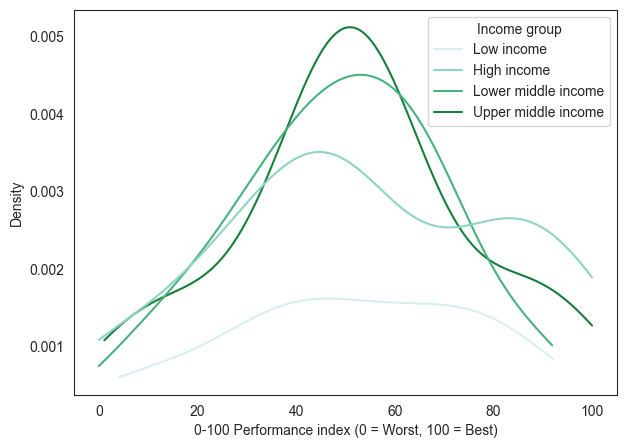

In [582]:
# Visualizing the dataset

# Plotting the data on a KDE 
fig, ax = plt.subplots()
fig.set_size_inches(7,5)

sns.kdeplot(data=scaled_emissions_total,
            x= "Scaled Values",
            hue= "Income group",
            ax=ax,
            cut=0,
            palette="BuGn",
            fill=False).set(xlabel="0-100 Performance index (0 = Worst, 100 = Best)")

plt.show()

In [546]:
# Descriptive Statistics for each group

scaled_emissions_median = scaled_emissions_total.groupby("Income group").median()

display(scaled_emissions_median)

scaled_emissions_mean = scaled_emissions_total.groupby("Income group").mean().sort_values("Scaled Values", ascending=False)

display(scaled_emissions_mean)

scaled_emissions_count = scaled_emissions_total.groupby("Income group").count()

scaled_emissions_count

Agriculture (per capita)  Scaled Values
Income group                                                
High income                          0.706209      50.000000
Low income                           0.995065      50.000002
Lower middle income                  0.663828      50.000206
Upper middle income                  0.733323      50.001044

Agriculture (per capita)  Scaled Values
Income group                                                
High income                          1.128405      54.049477
Upper middle income                  0.918613      51.835304
Low income                           1.291088      50.925158
Lower middle income                  0.966858      48.949993

Agriculture (per capita)  Scaled Values
Income group                                                
High income                                49             49
Low income                                 22             22
Lower middle income                        46             46
Upper middle income                        50             50

### Indicator 3: Per Capita Net Freshwater Withdrawal

In [54]:
# Loading the dataset

water_withdrawals = pd.read_csv("materials_and_methods/Metric_2/indicator_3.csv")

water_withdrawals.head()

Entity Code  Year   
0  Afghanistan  AFG  1987  \
1  Afghanistan  AFG  1988   
2  Afghanistan  AFG  1989   
3  Afghanistan  AFG  1990   
4  Afghanistan  AFG  1991   

   Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)  
0                                          99.000046                              
1                                          98.972824                              
2                                          98.944450                              
3                                          98.914856                              
4                                          98.883950

In [55]:
# Removing unwanted columns

water_withdrawals_cleaned = water_withdrawals.iloc[:, [0, 2, 3]]

water_withdrawals_cleaned.head()

Entity  Year   
0  Afghanistan  1987  \
1  Afghanistan  1988   
2  Afghanistan  1989   
3  Afghanistan  1990   
4  Afghanistan  1991   

   Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)  
0                                          99.000046                              
1                                          98.972824                              
2                                          98.944450                              
3                                          98.914856                              
4                                          98.883950

In [56]:
# Removing Unwanted Years

water_withdrawals_filtered = water_withdrawals_cleaned[water_withdrawals_cleaned["Year"] == 2019]

water_withdrawals_filtered.head()

Entity  Year   
32           Afghanistan  2019  \
62               Albania  2019   
102              Algeria  2019   
135               Angola  2019   
165  Antigua and Barbuda  2019   

     Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)  
32                                           98.169624                              
62                                           61.184790                              
102                                          63.764100                              
135                                          20.784925                              
165                                          15.652174

In [57]:
# Reseting the index

water_withdrawals_filtered_cleaned = water_withdrawals_filtered.set_index("Entity")

water_withdrawals_filtered_cleaned.head()

Year   
Entity                      
Afghanistan          2019  \
Albania              2019   
Algeria              2019   
Angola               2019   
Antigua and Barbuda  2019   

                     Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)  
Entity                                                                                              
Afghanistan                                                  98.169624                              
Albania                                                      61.184790                              
Algeria                                                      63.764100                              
Angola                                                       20.784925                              
Antigua and Barbuda                                          15.652174

In [58]:
# Merging the table above with size_of_economy table

water_withdrawals_economized = pd.merge(size_of_economy,
                                        water_withdrawals_filtered_cleaned,
                                        left_index=True,
                                        right_index= True).drop(["Region", "Year"], axis=1)

water_withdrawals_economized.head()

Income group   
Afghanistan                    Low income  \
Angola                Lower middle income   
Albania               Upper middle income   
United Arab Emirates          High income   
Argentina             Upper middle income   

                      Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)  
Afghanistan                                                   98.169624                              
Angola                                                        20.784925                              
Albania                                                       61.184790                              
United Arab Emirates                                          48.185406                              
Argentina                                                     73.928000

In [59]:
# Exploratory Data Analysis

water_withdrawals_grouped_mean = water_withdrawals_economized.groupby("Income group").mean()

display(water_withdrawals_grouped_mean.head())

water_withdrawals_grouped_median = water_withdrawals_economized.groupby("Income group").median()

display(water_withdrawals_grouped_median)

Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)
Income group                                                                                      
High income                                                  31.137505                            
Low income                                                   67.045932                            
Lower middle income                                          69.757238                            
Upper middle income                                          52.959919

Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)
Income group                                                                                      
High income                                                  19.056874                            
Low income                                                   76.105287                            
Lower middle income                                          76.718895                            
Upper middle income                                          59.994469

### Indicator 5: Per Capita Land Use

In [60]:
# Importing the dataset

land_use = pd.read_csv("materials_and_methods/Metric_2/indicator_5.csv")

land_use.head(60)

Entity Code  Year   
0   Afghanistan  AFG  1961  \
1   Afghanistan  AFG  1962   
2   Afghanistan  AFG  1963   
3   Afghanistan  AFG  1964   
4   Afghanistan  AFG  1965   
5   Afghanistan  AFG  1966   
6   Afghanistan  AFG  1967   
7   Afghanistan  AFG  1968   
8   Afghanistan  AFG  1969   
9   Afghanistan  AFG  1970   
10  Afghanistan  AFG  1971   
11  Afghanistan  AFG  1972   
12  Afghanistan  AFG  1973   
13  Afghanistan  AFG  1974   
14  Afghanistan  AFG  1975   
15  Afghanistan  AFG  1976   
16  Afghanistan  AFG  1977   
17  Afghanistan  AFG  1978   
18  Afghanistan  AFG  1979   
19  Afghanistan  AFG  1980   
20  Afghanistan  AFG  1981   
21  Afghanistan  AFG  1982   
22  Afghanistan  AFG  1983   
23  Afghanistan  AFG  1984   
24  Afghanistan  AFG  1985   
25  Afghanistan  AFG  1986   
26  Afghanistan  AFG  1987   
27  Afghanistan  AFG  1988   
28  Afghanistan  AFG  1989   
29  Afghanistan  AFG  1990   
30  Afghanistan  AFG  1991   
31  Afghanistan  AFG  1992   
32  Afghanistan  AFG  1993   
33  Afghanistan  AFG  1994   
34  Afghanistan  AFG  1995   
35  Afghanistan  AFG  1996   
36  Afghanistan  AFG  1997   
37  Afghanistan  AFG  1998   
38  Afghanistan  AFG  1999   
39  Afghanistan  AFG  2000   
40  Afghanistan  AFG  2001   
41  Afghanistan  AFG  2002   
42  Afghanistan  AFG  2003   
43  Afghanistan  AFG  2004   
44  Afghanistan  AFG  2005   
45  Afghanistan  AFG  2006   
46  Afghanistan  AFG  2007   
47  Afghanistan  AFG  2008   
48  Afghanistan  AFG  2009   
49  Afghanistan  AFG  2010   
50  Afghanistan  AFG  2011   
51  Afghanistan  AFG  2012   
52  Afghanistan  AFG  2013   
53  Afghanistan  AFG  2014   
54  Afghanistan  AFG  2015   
55  Afghanistan  AFG  2016   
56  Afghanistan  AFG  2017   
57  Afghanistan  AFG  2018   
58  Afghanistan  AFG  2019   
59  Afghanistan  AFG  2020   

    Agricultural land | 00006610 || Area | 5110pc || hectares per capita  
0                                            4.288897                     
1                                            4.210031                     
2                                            4.128873                     
3                                            4.048203                     
4                                            3.959685                     
5                                            3.875335                     
6                                            3.794092                     
7                                            3.706168                     
8                                            3.620566                     
9                                            3.534464                     
10                                           3.452842                     
11                                           3.370854                     
12                                           3.286997                     
13                                           3.205424                     
14                                           3.129619                     
15                                           3.062145                     
16                                           2.999060                     
17                                           2.940753                     
18                                           2.929916                     
19                                           3.047177                     
20                                           3.411235                     
21                                           3.772096                     
22                                           3.823967                     
23                                           3.714873                     
24                                           3.619978                     
25                                           3.642072                     
26                                           3.685543                     
27                                           3.663519                     
28 

In [61]:
# Selecting the relevant year

land_use_filtered = land_use[land_use["Year"] == 2019]

land_use_filtered

Entity      Code  Year   
58        Afghanistan       AFG  2019  \
118            Africa       NaN  2019   
178           Albania       ALB  2019   
238           Algeria       DZA  2019   
298    American Samoa       ASM  2019   
...               ...       ...   ...   
12985  Western Sahara       ESH  2019   
13045           World  OWID_WRL  2019   
13105           Yemen       YEM  2019   
13196          Zambia       ZMB  2019   
13256        Zimbabwe       ZWE  2019   

       Agricultural land | 00006610 || Area | 5110pc || hectares per capita  
58                                              1.006368                     
118                                             0.845206                     
178                                             0.408507                     
238                                             0.968469                     
298                                             0.084705                     
...                                                  ...                     
12985                                           9.183623                     
13045                                           0.611890                     
13105                                           0.743406                     
13196                                           1.296811                     
13256                                           1.055058                     

[236 rows x 4 columns]

In [62]:
# Removing columns that are not wanted.

land_use_cleaned = land_use_filtered.drop(["Code", "Year"], axis=1)

land_use_cleaned

Entity   
58        Afghanistan  \
118            Africa   
178           Albania   
238           Algeria   
298    American Samoa   
...               ...   
12985  Western Sahara   
13045           World   
13105           Yemen   
13196          Zambia   
13256        Zimbabwe   

       Agricultural land | 00006610 || Area | 5110pc || hectares per capita  
58                                              1.006368                     
118                                             0.845206                     
178                                             0.408507                     
238                                             0.968469                     
298                                             0.084705                     
...                                                  ...                     
12985                                           9.183623                     
13045                                           0.611890                     
13105                                           0.743406                     
13196                                           1.296811                     
13256                                           1.055058                     

[236 rows x 2 columns]

In [63]:
# Re-indexing the dataframe

land_use_completely_cleaned = land_use_cleaned.set_index("Entity").rename_axis("Country")

land_use_completely_cleaned

Agricultural land | 00006610 || Area | 5110pc || hectares per capita
Country                                                                             
Afghanistan                                              1.006368                   
Africa                                                   0.845206                   
Albania                                                  0.408507                   
Algeria                                                  0.968469                   
American Samoa                                           0.084705                   
...                                                           ...                   
Western Sahara                                           9.183623                   
World                                                    0.611890                   
Yemen                                                    0.743406                   
Zambia                                                   1.296811                   
Zimbabwe                                                 1.055058                   

[236 rows x 1 columns]

In [64]:
# Joining the table with sizes of economies

land_use_economized = pd.merge(size_of_economy,
                               land_use_completely_cleaned,
                               left_index=True,
                               right_index=True).drop("Region", axis=1)

land_use_economized.head()

Income group   
Country                            
Aruba                High income  \
Afghanistan           Low income   
Angola       Lower middle income   
Albania      Upper middle income   
Andorra              High income   

             Agricultural land | 00006610 || Area | 5110pc || hectares per capita  
Country                                                                            
Aruba                                                 0.018787                     
Afghanistan                                           1.006368                     
Angola                                                1.760314                     
Albania                                               0.408507                     
Andorra                                               0.246199

In [547]:
# Exploratory Data Analysis

land_use_grouped_mean = land_use_economized.groupby("Income group").mean()

display(land_use_grouped_mean)

land_use_grouped_median = land_use_economized.groupby("Income group").median()

display(land_use_grouped_median)

land_use_counted = land_use_economized.groupby("Income group").count()

display(land_use_counted)

Agricultural land | 00006610 || Area | 5110pc || hectares per capita
Income group                                                                             
High income                                                   0.824785                   
Low income                                                    1.178552                   
Lower middle income                                           1.520275                   
Upper middle income                                           1.403417

Agricultural land | 00006610 || Area | 5110pc || hectares per capita
Income group                                                                             
High income                                                   0.228527                   
Low income                                                    0.990771                   
Lower middle income                                           0.420939                   
Upper middle income                                           0.467098

Agricultural land | 00006610 || Area | 5110pc || hectares per capita
Income group                                                                             
High income                                                         63                   
Low income                                                          22                   
Lower middle income                                                 46                   
Upper middle income                                                 51

## Metric 3: Food Affordability and Availability

### Indicator 1: Food Affordability

In [66]:
# Loading the dataset

affordability = pd.read_csv("materials_and_methods/Metric_3/indicator_1.csv", header=None)

affordability.head()

0     1
0    Australia  93.3
1    Singapore  93.2
2  Netherlands  92.7
3      Belgium  92.6
4      Ireland  92.6

In [67]:
# Resetting the index and renaming columns

affordability_cleaned = affordability.rename(columns={0: "Countries", 1: "Affordability Scores"}).set_index("Countries")

affordability_cleaned

Affordability Scores
Countries                        
Australia                    93.3
Singapore                    93.2
Netherlands                  92.7
Belgium                      92.6
Ireland                      92.6
...                           ...
Haiti                        32.8
Burundi                      32.5
Syria                        32.0
Zambia                       26.8
Nigeria                      25.0

[113 rows x 1 columns]

In [68]:
# Attaching that table with size of economies

affordability_economized = pd.merge(size_of_economy,
                                    affordability_cleaned,
                                    left_index=True,
                                    right_index=True).drop("Region", axis=1)

affordability_economized

Income group  Affordability Scores
Angola                Lower middle income                  35.5
United Arab Emirates          High income                  86.7
Argentina             Upper middle income                  62.0
Australia                     High income                  93.3
Austria                       High income                  91.3
...                                   ...                   ...
United States                 High income                  87.1
Uzbekistan            Lower middle income                  52.7
Vietnam               Lower middle income                  84.0
South Africa          Upper middle income                  63.4
Zambia                Lower middle income                  26.8

[102 rows x 2 columns]

In [69]:
# Exploratory Data Analysis: Checking the sample size for each country group

affordability_income_groups_counted = affordability_economized.groupby("Income group").count()

display(affordability_income_groups_counted)

Affordability Scores
Income group                             
High income                            34
Low income                             15
Lower middle income                    30
Upper middle income                    23

In [70]:
# Exploratory Data Analysis: Mean and Median values in each country group

affordability_grouped_by_mean = affordability_economized.groupby("Income group").mean()

display(affordability_grouped_by_mean)

affordability_grouped_by_median = affordability_economized.groupby("Income group").median()

display(affordability_grouped_by_median)

Affordability Scores
Income group                             
High income                     89.038235
Low income                      41.873333
Lower middle income             58.263333
Upper middle income             75.326087

Affordability Scores
Income group                             
High income                         89.35
Low income                          42.60
Lower middle income                 59.85
Upper middle income                 78.00

### Indicator 2: Food Availability

In [71]:
# Loading the dataset:

food_availability = pd.read_csv("materials_and_methods/Metric_3/indicator_2.csv", header=None)

food_availability.head()

0     1
0        Japan  81.2
1        China  79.2
2    Singapore  77.8
3     Portugal  77.0
4  Switzerland  76.8

In [72]:
# Renaming columns and resetting the index

availability_cleaned = food_availability.rename({0: "Countries", 1: "Availability Scores"}, axis="columns").set_index("Countries")

availability_cleaned.head()

Availability Scores
Countries                       
Japan                       81.2
China                       79.2
Singapore                   77.8
Portugal                    77.0
Switzerland                 76.8

In [73]:
# Joining the dataset with the size_of_economy dataset

availability_economized = pd.merge(size_of_economy,
                                   availability_cleaned,
                                   right_index=True,
                                   left_index=True).drop("Region", axis=1)

availability_economized.head()

Income group  Availability Scores
Angola                Lower middle income                 43.5
United Arab Emirates          High income                 73.8
Argentina             Upper middle income                 63.4
Australia                     High income                 61.1
Austria                       High income                 67.1

In [74]:
# Exploratory Data Analysis: Checking the sample size from each income group

availability_group_count = availability_economized.groupby("Income group").count()

availability_group_count

Availability Scores
Income group                            
High income                           34
Low income                            15
Lower middle income                   30
Upper middle income                   23

In [75]:
# Exploratory Data Analysis: Checking the mean and median values from each income group

availability_groups_by_mean = availability_economized.groupby("Income group").mean()

display(availability_groups_by_mean)

availability_groups_by_median = availability_economized.groupby("Income group").median()

display(availability_groups_by_median)

Availability Scores
Income group                            
High income                    68.079412
Low income                     45.873333
Lower middle income            54.040000
Upper middle income            59.717391

Availability Scores
Income group                            
High income                        67.45
Low income                         48.20
Lower middle income                54.30
Upper middle income                59.80

### Indicator 3: Poverty Index

In [76]:
# Importing the data

poverty = pd.read_csv("materials_and_methods/Metric_3/indicator_3.csv")

poverty.head()

Goal  Target Indicator   SeriesCode   
0     1     1.1     1.1.1  SI_POV_DAY1  \
1     1     1.1     1.1.1  SI_POV_DAY1   
2     1     1.1     1.1.1  SI_POV_DAY1   
3     1     1.1     1.1.1  SI_POV_DAY1   
4     1     1.1     1.1.1  SI_POV_DAY1   

                                   SeriesDescription  GeoAreaCode GeoAreaName   
0  Proportion of population below international p...            2      Africa  \
1  Proportion of population below international p...            8     Albania   
2  Proportion of population below international p...           19    Americas   
3  Proportion of population below international p...           32   Argentina   
4  Proportion of population below international p...           32   Argentina   

      Age Location Reporting Type  ... Unnamed: 42 Unnamed: 43  Unnamed: 44   
0  ALLAGE  ALLAREA              G  ...         NaN         NaN          NaN  \
1  ALLAGE  ALLAREA              G  ...         NaN         NaN          NaN   
2  ALLAGE  ALLAREA              G  ...         NaN         NaN          NaN   
3    <15Y  ALLAREA              G  ...         NaN         NaN          NaN   
4   15-64  ALLAREA              G  ...         NaN         NaN          NaN   

   Unnamed: 45  Unnamed: 46  Unnamed: 47  Unnamed: 48  Unnamed: 49   
0          NaN          NaN          NaN          NaN          NaN  \
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 50  Unnamed: 51  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN  

[5 rows x 52 columns]

In [77]:
# Cleaning the data: Removing unwanted columns (Opening the document in excel and checking columns there helps)

poverty_shortened = poverty.iloc[:, :13]

poverty_shortened

Goal  Target Indicator   SeriesCode   
0       1     1.1     1.1.1  SI_POV_DAY1  \
1       1     1.1     1.1.1  SI_POV_DAY1   
2       1     1.1     1.1.1  SI_POV_DAY1   
3       1     1.1     1.1.1  SI_POV_DAY1   
4       1     1.1     1.1.1  SI_POV_DAY1   
..    ...     ...       ...          ...   
484     1     1.1     1.1.1  SI_POV_DAY1   
485     1     1.1     1.1.1  SI_POV_DAY1   
486     1     1.1     1.1.1  SI_POV_DAY1   
487     1     1.1     1.1.1  SI_POV_DAY1   
488     1     1.1     1.1.1  SI_POV_DAY1   

                                     SeriesDescription  GeoAreaCode   
0    Proportion of population below international p...            2  \
1    Proportion of population below international p...            8   
2    Proportion of population below international p...           19   
3    Proportion of population below international p...           32   
4    Proportion of population below international p...           32   
..                                                 ...          ...   
484  Proportion of population below international p...          716   
485  Proportion of population below international p...          716   
486  Proportion of population below international p...          716   
487  Proportion of population below international p...          716   
488  Proportion of population below international p...          716   

    GeoAreaName     Age Location Reporting Type      Sex    Units      2019  
0        Africa  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT  29.80000  
1       Albania  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   0.00000  
2      Americas  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   3.00000  
3     Argentina    <15Y  ALLAREA              G  BOTHSEX  PERCENT   1.53763  
4     Argentina   15-64  ALLAREA              G  BOTHSEX  PERCENT   0.68262  
..          ...     ...      ...            ...      ...      ...       ...  
484    Zimbabwe  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT  39.80000  
485    Zimbabwe  ALLAGE  ALLAREA              G   FEMALE  PERCENT  39.44854  
486    Zimbabwe  ALLAGE  ALLAREA              G     MALE  PERCENT  40.08752  
487    Zimbabwe  ALLAGE    RURAL              G  BOTHSEX  PERCENT  52.61327  
488    Zimbabwe  ALLAGE    URBAN              G  BOTHSEX  PERCENT  10.98269  

[489 rows x 13 columns]

In [78]:
# Taking only rows whose data in the "Sex" column is BOTHSEX, "Age" is ALLAGE, Location is ALLAREA

poverty_1 = poverty_shortened[poverty_shortened["Sex"] == "BOTHSEX"]

poverty_2 = poverty_1[poverty_1["Age"] == "ALLAGE"]

poverty_fully_filtered = poverty_2[poverty_2["Location"] == "ALLAREA"]

poverty_fully_filtered

Goal  Target Indicator   SeriesCode   
0       1     1.1     1.1.1  SI_POV_DAY1  \
1       1     1.1     1.1.1  SI_POV_DAY1   
2       1     1.1     1.1.1  SI_POV_DAY1   
6       1     1.1     1.1.1  SI_POV_DAY1   
13      1     1.1     1.1.1  SI_POV_DAY1   
..    ...     ...       ...          ...   
475     1     1.1     1.1.1  SI_POV_DAY1   
478     1     1.1     1.1.1  SI_POV_DAY1   
479     1     1.1     1.1.1  SI_POV_DAY1   
480     1     1.1     1.1.1  SI_POV_DAY1   
484     1     1.1     1.1.1  SI_POV_DAY1   

                                     SeriesDescription  GeoAreaCode   
0    Proportion of population below international p...            2  \
1    Proportion of population below international p...            8   
2    Proportion of population below international p...           19   
6    Proportion of population below international p...           32   
13   Proportion of population below international p...           51   
..                                                 ...          ...   
475  Proportion of population below international p...          548   
478  Proportion of population below international p...           11   
479  Proportion of population below international p...          155   
480  Proportion of population below international p...            1   
484  Proportion of population below international p...          716   

        GeoAreaName     Age Location Reporting Type      Sex    Units  2019  
0            Africa  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT  29.8  
1           Albania  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   0.0  
2          Americas  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   3.0  
6         Argentina  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   0.8  
13          Armenia  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   1.0  
..              ...     ...      ...            ...      ...      ...   ...  
475         Vanuatu  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT  10.0  
478  Western Africa  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT  26.6  
479  Western Europe  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   0.1  
480           World  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT   8.5  
484        Zimbabwe  ALLAGE  ALLAREA              G  BOTHSEX  PERCENT  39.8  

[98 rows x 13 columns]

In [79]:
# Removing all other unwanted columns

poverty_cleaned = poverty_fully_filtered.iloc[:, [6, 12]].set_index("GeoAreaName")

poverty_cleaned

2019
GeoAreaName         
Africa          29.8
Albania          0.0
Americas         3.0
Argentina        0.8
Armenia          1.0
...              ...
Vanuatu         10.0
Western Africa  26.6
Western Europe   0.1
World            8.5
Zimbabwe        39.8

[98 rows x 1 columns]

In [80]:
# Attaching it with the size of economy table

poverty_economized = pd.merge(size_of_economy,
                              poverty_cleaned,
                              left_index=True,
                              right_index=True).drop("Region", axis=1)

poverty_economized

Income group  2019
Albania             Upper middle income   0.0
Argentina           Upper middle income   0.8
Armenia             Upper middle income   1.0
Austria                     High income   0.6
Belgium                     High income   0.1
Bulgaria            Upper middle income   0.9
Belarus             Upper middle income   0.0
Brazil              Upper middle income   5.4
China               Upper middle income   0.1
Colombia            Upper middle income   5.3
Costa Rica          Upper middle income   1.1
Cyprus                      High income   0.2
Germany                     High income   0.0
Denmark                     High income   0.3
Dominican Republic  Upper middle income   0.8
Ecuador             Upper middle income   3.6
Spain                       High income   0.8
Estonia                     High income   0.6
Finland                     High income   0.0
Fiji                Upper middle income   1.3
France                      High income   0.1
Georgia             Upper middle income   4.8
Greece                      High income   0.7
Honduras            Lower middle income  12.7
Croatia                     High income   0.3
Hungary                     High income   0.3
Indonesia           Lower middle income   4.4
India               Lower middle income  10.0
Ireland                     High income   0.1
Italy                       High income   1.0
Kiribati            Lower middle income   1.7
Sri Lanka           Lower middle income   1.0
Lithuania                   High income   0.5
Luxembourg                  High income   0.1
Latvia                      High income   0.2
Maldives            Upper middle income   0.0
Marshall Islands    Upper middle income   0.9
North Macedonia     Upper middle income   2.7
Malta                       High income   0.3
Malawi                       Low income  70.1
Norway                      High income   0.2
Panama              Upper middle income   1.0
Peru                Upper middle income   3.0
Poland                      High income   0.1
Portugal                    High income   0.1
Paraguay            Upper middle income   1.0
Romania             Upper middle income   2.2
Russian Federation  Upper middle income   0.0
El Salvador         Lower middle income   1.4
Serbia              Upper middle income   2.3
Slovenia                    High income   0.0
Sweden                      High income   0.3
Thailand            Upper middle income   0.1
Uganda                       Low income  42.2
Ukraine             Lower middle income   0.0
Uruguay                     High income   0.1
Vanuatu             Lower middle income  10.0
Zimbabwe            Lower middle income  39.8

In [81]:
# Grouping to check the sample size

poverty_grouped_and_counted = poverty_economized.groupby("Income group").count()
display(poverty_grouped_and_counted)

2019
Income group             
High income            24
Low income              2
Lower middle income     9
Upper middle income    23

In [82]:
# Rechecking the initial country names to see if we can salvage low income countries from the initial poverty table

included_names = list(poverty_economized.index.values)

excluded_names = ~poverty_cleaned.index.isin(included_names)

poverty_excluded_values = poverty_cleaned[excluded_names]

poverty_excluded_values

2019
GeoAreaName                                             
Africa                                              29.8
Americas                                             3.0
Asia                                                 5.0
Australia and New Zealand                            0.5
Bolivia (Plurinational State of)                     1.9
Central America                                      3.6
Central and Southern Asia                            8.5
Czechia                                              0.0
Developed regions (Europe, Cyprus, Israel, Nort...   0.5
Developing regions                                  10.3
Eastern and South-Eastern Asia                       1.0
Eastern Asia                                         0.2
Eastern Asia (excluding Japan)                       0.1
Eastern Europe                                       0.2
Egypt                                                1.5
Europe                                               0.3
Europe and Northern America                          0.5
Iran (Islamic Republic of)                           1.0
Kyrgyzstan                                           0.7
Latin America and the Caribbean                      4.3
Least Developed Countries (LDCs)                    31.4
Netherlands (Kingdom of the)                         0.1
Northern Africa (exc. Sudan)                         1.2
Northern America                                     0.9
Northern Europe                                      0.4
Oceania                                              8.7
Republic of Moldova                                  0.0
Slovakia                                             0.1
South America                                        4.2
South-Eastern Asia                                   3.0
Southern Asia                                        8.3
Southern Europe                                      0.8
Sub-Saharan Africa                                  35.4
Sub-Saharan Africa (inc. Sudan)                     34.9
Türkiye                                              0.4
United Kingdom of Great Britain and Northern Ir...   0.5
United States of America                             1.0
Western Africa                                      26.6
Western Europe                                       0.1
World                                                8.5

In [83]:
# Checking the median values of low-income countries to see if they reflect the "Least Developed Countries" values given at the poverty table

poverty_grouped_medians = poverty_economized.groupby("Income group").median()

poverty_grouped_medians

2019
Income group              
High income           0.20
Low income           56.15
Lower middle income   4.40
Upper middle income   1.00

In [84]:
# Some more digging on the size_of_economy dataset to look for countries with slight differences in names

size_of_economy

# display(size_of_economy.index.values)

size_of_economy.loc["Moldova"]

Income group      Upper middle income
Region          Europe & Central Asia
Name: Moldova, dtype: object

### Indicator 4: Income Inequality

In [85]:
# Loading the dataset

gini = pd.read_csv("materials_and_methods/Metric_3/indicator_4.csv")

gini

Entity Code  Year  Gini coefficient
0      Albania  ALB  1996          0.270103
1      Albania  ALB  2002          0.317390
2      Albania  ALB  2005          0.305957
3      Albania  ALB  2008          0.299847
4      Albania  ALB  2012          0.289605
...        ...  ...   ...               ...
2120    Zambia  ZMB  2010          0.556215
2121    Zambia  ZMB  2015          0.571361
2122  Zimbabwe  ZWE  2011          0.431536
2123  Zimbabwe  ZWE  2017          0.443371
2124  Zimbabwe  ZWE  2019          0.502565

[2125 rows x 4 columns]

In [86]:
# Filtering to get the year wanted

gini_filtered = gini[gini["Year"] == 2019]

gini_filtered

Entity Code  Year  Gini coefficient
10              Albania  ALB  2019          0.307717
47    Argentina - urban  NaN  2019          0.429059
69              Armenia  ARM  2019          0.298782
104             Austria  AUT  2019          0.302116
142             Belarus  BLR  2019          0.252778
...                 ...  ...   ...               ...
1988            Ukraine  UKR  2019          0.266195
2051      United States  USA  2019          0.415356
2065            Uruguay  URY  2019          0.396765
2085            Vanuatu  VUT  2019          0.323176
2124           Zimbabwe  ZWE  2019          0.502565

[67 rows x 4 columns]

In [87]:
# Attaching the table with sizes of economy

gini_economized = pd.merge(size_of_economy,
                           gini_filtered,
                           left_index=True,
                           right_on="Entity").drop(["Region", "Code", "Year"], axis=1).set_index("Entity")

gini_economized

Income group  Gini coefficient
Entity                                                   
Albania             Upper middle income          0.307717
Armenia             Upper middle income          0.298782
Austria                     High income          0.302116
Belgium                     High income          0.272198
Bulgaria            Upper middle income          0.402714
Belarus             Upper middle income          0.252778
Bolivia             Lower middle income          0.416496
Brazil              Upper middle income          0.534858
China               Upper middle income          0.381683
Colombia            Upper middle income          0.513350
Costa Rica          Upper middle income          0.481878
Cyprus                      High income          0.312242
Denmark                     High income          0.277236
Dominican Republic  Upper middle income          0.419186
Ecuador             Upper middle income          0.457115
Spain                       High income          0.343058
Estonia                     High income          0.307675
Finland                     High income          0.277373
Fiji                Upper middle income          0.307069
Georgia             Upper middle income          0.359008
Greece                      High income          0.331045
Honduras            Lower middle income          0.481682
Croatia                     High income          0.289091
Hungary                     High income          0.299505
Indonesia           Lower middle income          0.376101
India               Lower middle income          0.357339
Kiribati            Lower middle income          0.278327
Lithuania                   High income          0.352532
Luxembourg                  High income          0.342413
Latvia                      High income          0.344895
Moldova             Upper middle income          0.260166
Maldives            Upper middle income          0.292851
Marshall Islands    Upper middle income          0.354829
Malta                       High income          0.310421
Malawi                       Low income          0.385432
Netherlands                 High income          0.292483
Norway                      High income          0.277423
Panama              Upper middle income          0.498383
Peru                Upper middle income          0.415628
Poland                      High income          0.302395
Portugal                    High income          0.327627
Paraguay            Upper middle income          0.456506
Romania             Upper middle income          0.348042
El Salvador         Lower middle income          0.387788
Serbia              Upper middle income          0.289532
Slovenia                    High income          0.243842
Sweden                      High income          0.293056
Thailand            Upper middle income          0.348557
Turkey              Upper middle income          0.419091
Uganda                       Low income          0.427055
Ukraine             Lower middle income          0.266195
Uruguay                     High income          0.396765
United States               High income          0.415356
Vanuatu             Lower middle income          0.323176
Zimbabwe            Lower middle income          0.502565

In [88]:
# Grouping to see how much of a sample size we have in each group

gini_grouped_and_counted = gini_economized.groupby("Income group").count()

gini_grouped_and_counted

Gini coefficient
Income group                         
High income                        22
Low income                          2
Lower middle income                 9
Upper middle income                22

In [89]:
included_names = list(gini_economized.index.values)

excluded_names = ~gini_filtered["Entity"].isin(included_names)

# excluded_names
gini_excluded_values = gini_filtered[excluded_names]

gini_excluded_values

Entity Code  Year  Gini coefficient
47    Argentina - urban  NaN  2019          0.429059
365       China - rural  NaN  2019          0.326749
385       China - urban  NaN  2019          0.370526
513             Czechia  CZE  2019          0.252622
906       India - rural  NaN  2019          0.308630
918       India - urban  NaN  2019          0.393656
974   Indonesia - rural  NaN  2019          0.316865
1003  Indonesia - urban  NaN  2019          0.392157
1019               Iran  IRN  2019          0.409360
1166         Kyrgyzstan  KGZ  2019          0.297012
1690             Russia  RUS  2019          0.376914
1753           Slovakia  SVK  2019          0.232323

In [90]:
# Checking if we can fetch some of the low-income countries from the size of economy table from the names left-out in the gini table

size_of_economy.loc["India"]

Income group    Lower middle income
Region                   South Asia
Name: India, dtype: object

## Metric 4: Sociocultural Wellbeing

### Indicator 1: Gender Equity

In [91]:
# Loading the dataset

gender_equity = pd.read_csv("materials_and_methods/Metric_4/indicator_1.csv", header=None)

gender_equity

0      1
0             Iceland  0.877
1              Norway  0.842
2             Finland  0.832
3              Sweden  0.820
4           Nicaragua  0.804
..                ...    ...
148  Congo, Dem. Rep.  0.578
149             Syria  0.567
150          Pakistan  0.564
151              Iraq  0.530
152             Yemen  0.494

[153 rows x 2 columns]

In [92]:
# Renaming columns

gender_equity_renamed = gender_equity.rename({0: "Country", 1: "Global Gender Gap Index"}, axis=1)

gender_equity_renamed

Country  Global Gender Gap Index
0             Iceland                    0.877
1              Norway                    0.842
2             Finland                    0.832
3              Sweden                    0.820
4           Nicaragua                    0.804
..                ...                      ...
148  Congo, Dem. Rep.                    0.578
149             Syria                    0.567
150          Pakistan                    0.564
151              Iraq                    0.530
152             Yemen                    0.494

[153 rows x 2 columns]

In [93]:
# Resetting the index column and merging the data with the size of economy dataset

gender_equity_cleaned = gender_equity_renamed.set_index("Country")

display(gender_equity_cleaned.head())


gender_equity_economized = pd.merge(size_of_economy,
                                    gender_equity_cleaned,
                                    left_index=True,
                                    right_index=True).drop("Region", axis=1)

gender_equity_economized

Global Gender Gap Index
Country                           
Iceland                      0.877
Norway                       0.842
Finland                      0.832
Sweden                       0.820
Nicaragua                    0.804

Income group  Global Gender Gap Index
Country                                                           
Angola                Lower middle income                    0.660
Albania               Upper middle income                    0.769
United Arab Emirates          High income                    0.655
Argentina             Upper middle income                    0.746
Armenia               Upper middle income                    0.684
...                                   ...                      ...
Uruguay                       High income                    0.737
United States                 High income                    0.724
Vanuatu               Lower middle income                    0.638
Zambia                Lower middle income                    0.731
Zimbabwe              Lower middle income                    0.730

[140 rows x 2 columns]

In [94]:
# Grouping countries according to the size of economy and checking for sample sizes, mean, and median values.

gender_equity_grouped_and_counted = gender_equity_economized.groupby("Income group").count()

gender_equity_means = gender_equity_economized.groupby("Income group").mean()

gender_equity_median = gender_equity_economized.groupby("Income group").median()

display(gender_equity_grouped_and_counted)
display(gender_equity_means)
display(gender_equity_median)

Global Gender Gap Index
Income group                                
High income                               48
Low income                                15
Lower middle income                       38
Upper middle income                       39

Global Gender Gap Index
Income group                                
High income                         0.732083
Low income                          0.673600
Lower middle income                 0.681711
Upper middle income                 0.703744

Global Gender Gap Index
Income group                                
High income                            0.736
Low income                             0.668
Lower middle income                    0.682
Upper middle income                    0.709

### Indicator 2: Instances of Child Labor

In [95]:
# Loading the dataset

child_labor = pd.read_csv("materials_and_methods/Metric_4/indicator_2.csv")

child_labor.head()

ref_area.label                                    indicator.label   
0    Afghanistan  Children in employment by sex, age and economi...  \
1    Afghanistan  Children in employment by sex, age and economi...   
2    Afghanistan  Children in employment by sex, age and economi...   
3    Afghanistan  Children in employment by sex, age and economi...   
4    Afghanistan  Children in employment by sex, age and economi...   

                                 source.label   sex.label   
0  HIES - Households Living Conditions Survey  Sex: Total  \
1  HIES - Households Living Conditions Survey  Sex: Total   
2  HIES - Households Living Conditions Survey  Sex: Total   
3  HIES - Households Living Conditions Survey  Sex: Total   
4  HIES - Households Living Conditions Survey  Sex: Total   

                    classif1.label   
0  Age (Child labour bands): '5-17  \
1  Age (Child labour bands): '5-17   
2  Age (Child labour bands): '5-17   
3  Age (Child labour bands): '5-17   
4  Age (Child labour bands): '5-17   

                                     classif2.label  time  obs_value   
0           Economic activity (Broad sector): Total  2014   3261.161  \
1     Economic activity (Broad sector): Agriculture  2014    380.369   
2        Economic activity (Broad sector): Industry  2014    130.488   
3        Economic activity (Broad sector): Services  2014     84.046   
4  Economic activity (Broad sector): Not classified  2014   2666.258   

  obs_status.label                                  note_source.label  
0              NaN  Repository: ILO-STATISTICS - Micro data proces...  
1              NaN  Repository: ILO-STATISTICS - Micro data proces...  
2              NaN  Repository: ILO-STATISTICS - Micro data proces...  
3              NaN  Repository: ILO-STATISTICS - Micro data proces...  
4              NaN  Repository: ILO-STATISTICS - Micro data proces...

In [548]:
# Filtering the dataset according to year 2019, Age-band 5-17, in the agricultural sector, and both sexes.

child_labor_2019 = child_labor[child_labor["time"] == 2019]

child_labor_5years = child_labor_2019[child_labor_2019["classif1.label"] == "Age (Child labour bands): '5-17"]

child_labor_in_agriculture = child_labor_5years[child_labor_5years["classif2.label"] == "Economic activity (Broad sector): Agriculture"]

child_labor_agriculture_both_sexes = child_labor_in_agriculture[child_labor_in_agriculture["sex.label"] == "Sex: Total"][["ref_area.label", 
                                                                                                                          "sex.label", 
                                                                                                                          "classif1.label",
                                                                                                                          "classif2.label",
                                                                                                                          "obs_value"]]

child_labor_agriculture_both_sexes

ref_area.label   sex.label                   classif1.label   
329        Colombia  Sex: Total  Age (Child labour bands): '5-17  \
435         Ecuador  Sex: Total  Age (Child labour bands): '5-17   
661        Honduras  Sex: Total  Age (Child labour bands): '5-17   
1118         Mexico  Sex: Total  Age (Child labour bands): '5-17   

                                     classif2.label  obs_value  
329   Economic activity (Broad sector): Agriculture    243.775  
435   Economic activity (Broad sector): Agriculture    429.444  
661   Economic activity (Broad sector): Agriculture    185.550  
1118  Economic activity (Broad sector): Agriculture    589.248

### Indicator 3: Respect For Community Rights

In [565]:
# Loading the dataframe

community_rights = pd.read_csv("materials_and_methods/Metric_4/indicator_3.csv")

community_rights.head()

Last updated:     Unnamed: 1           9/2/2015   
0        Country         Region       Income level  \
1        Country            NaN                NaN   
2      Lithuania         Europe  High income: OECD   
3         Latvia         Europe  High income: OECD   
4  United States  North America  High income: OECD   

                                          Unnamed: 3 Unnamed: 4 Unnamed: 5   
0  Income level normalized (5=High Income:OECD; 1...     Aarhus        OGP  \
1                                                NaN   Progress        NaN   
2                                                  5     Aarhus        OGP   
3                                                  5     Aarhus        OGP   
4                                                  5        NaN        OGP   

        Unnamed: 6                                         Unnamed: 7   
0  Federal/unitary                                                1.1  \
1              NaN  To what extent does the law mandate access to ...   
2          Unitary                                                  3   
3          Unitary                                                  3   
4          Federal                                                  3   

                                              Notes:   
0                                                1.2  \
1  To what extent does the law provide for natura...   
2                                                  3   
3                                                  3   
4                                                  3   

  Click an arrow on any column to sort the results. Clicking A-->Z will sort from smallest to largest score and Z-->A will sort largest to smallest   
0                                                1.3                                                                                                 \
1  To what extent does the law make access to env...                                                                                                  
2                                                  2                                                                                                  
3                                                  2                                                                                                  
4                                                  2                                                                                                  

   ... Unnamed: 181 Unnamed: 182 Unnamed: 183 Unnamed: 184 Unnamed: 185   
0  ...          NaN          NaN          NaN          NaN          NaN  \
1  ...          NaN          NaN          NaN          NaN          NaN   
2  ...          NaN          NaN          NaN          NaN          NaN   
3  ...          NaN          NaN          NaN          NaN          NaN   
4  ...          NaN          NaN          NaN          NaN          NaN   

  Unnamed: 186 Unnamed: 187 Unnamed: 188 Unnamed: 189 Unnamed: 190  
0          NaN          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN          NaN  

[5 rows x 191 columns]

In [567]:
# Removing Unwanted columns and rows, and resetting the index

community_rights_cleaned = community_rights.iloc[:, [0, 132]].rename(columns={"Last updated:" : "Country", "Unnamed: 132" : "Overall Score"}).drop([0, 1]).set_index("Country")

community_rights_cleaned.head()

Overall Score
Country                     
Lithuania               2.39
Latvia                  2.31
United States           2.16
South Africa            2.16
United Kingdom          2.14

In [568]:
# Joining the sizes of economies

community_rights_economized = pd.merge(size_of_economy,
                                       community_rights_cleaned,
                                       left_index=True,
                                       right_index=True).drop("Region", axis=1)

community_rights_economized.head()

Income group Overall Score
Country                                      
Argentina   Upper middle income          1.63
Australia           High income          1.42
Bangladesh  Lower middle income          1.10
Belize      Lower middle income          0.82
Benin       Lower middle income          0.84

## Metric 5: Resilience

### Indicator 1: ND-GAIN

In [97]:
# Loading the dataset

nd_gain = pd.read_csv("materials_and_methods/Metric_5/gain.csv")

nd_gain.head()

ISO3         Name       1995       1996       1997       1998       1999   
0  AFG  Afghanistan  34.540527  34.532318  34.610292  34.802520  34.818479  \
1  ALB      Albania  44.985055  44.973357  44.904180  44.543379  44.084588   
2  DZA      Algeria  45.013035  45.103616  45.012953  45.024701  45.369850   
3  AND      Andorra        NaN        NaN        NaN        NaN        NaN   
4  AGO       Angola  34.700633  34.682550  34.622045  34.560876  34.592635   

        2000       2001       2002  ...       2012       2013       2014   
0  34.836746  35.259062  35.686449  ...  31.923583  31.756797  32.709698  \
1  44.140112  44.394205  44.868712  ...  48.742192  49.279484  50.696344   
2  45.658923  45.845773  46.005927  ...  44.960241  45.680764  45.601550   
3        NaN        NaN        NaN  ...        NaN        NaN        NaN   
4  34.620471  34.896140  35.385018  ...  35.009971  35.346728  35.496522   

        2015       2016       2017       2018       2019       2020       2021  
0  32.901910  33.170649  32.419421  32.228588  32.844426  32.566627  32.797710  
1  51.248574  50.854689  50.684835  51.184690  50.780027  50.630988  50.758476  
2  45.862860  46.348301  47.413017  47.416751  47.478285  47.614827  47.853701  
3        NaN        NaN        NaN        NaN        NaN        NaN        NaN  
4  35.545056  36.831118  36.841935  37.225241  37.401906  37.537551  37.909703  

[5 rows x 29 columns]

In [98]:
# Selecting the relevant year

nd_gain_filtered = nd_gain.loc[:, ["Name", "2019"]]

nd_gain_filtered.head()

Name       2019
0  Afghanistan  32.844426
1      Albania  50.780027
2      Algeria  47.478285
3      Andorra        NaN
4       Angola  37.401906

In [99]:
# Resetting the index for the dataset

nd_gain_cleaned = nd_gain_filtered.set_index("Name")

nd_gain_cleaned.head()

2019
Name                  
Afghanistan  32.844426
Albania      50.780027
Algeria      47.478285
Andorra            NaN
Angola       37.401906

In [100]:
# Joining the table with sizes of economy

nd_gain_economized = pd.merge(size_of_economy,
                              nd_gain_cleaned,
                              left_index=True,
                              right_index=True).drop("Region", axis=1)

nd_gain_economized.head()

Income group       2019
Afghanistan                    Low income  32.844426
Angola                Lower middle income  37.401906
Albania               Upper middle income  50.780027
Andorra                       High income        NaN
United Arab Emirates          High income  60.504101

In [569]:
# Exploratory Data Analysis

nd_gain_grouped_mean = nd_gain_economized.groupby("Income group").mean()

display(nd_gain_grouped_mean)

nd_gain_grouped_median = nd_gain_economized.groupby("Income group").median()

display(nd_gain_grouped_median)

nd_gain_counted = nd_gain_economized.groupby("Income group").count()

nd_gain_counted

2019
Income group                  
High income          62.044251
Low income           35.379523
Lower middle income  42.854906
Upper middle income  50.146962

2019
Income group                  
High income          61.695109
Low income           35.291224
Lower middle income  41.918914
Upper middle income  49.758989

2019
Income group             
High income            50
Low income             22
Lower middle income    42
Upper middle income    47

### Indicator 2: Food Production Diversity

In [102]:
# Importing Data for crops
raw_crops = pd.read_csv("materials_and_methods/Metric_5/indicator_2/raw_crops.csv")

raw_crops.head(3)

Domain Code                        Domain  Area Code (M49)         Area   
0         QCL  Crops and livestock products                4  Afghanistan  \
1         QCL  Crops and livestock products                4  Afghanistan   
2         QCL  Crops and livestock products                4  Afghanistan   

   Element Code     Element  Item Code (CPC)   
0          5510  Production           1371.0  \
1          5510  Production           1654.0   
2          5510  Production           1341.0   

                                                Item  Year Code  Year Unit   
0                                  Almonds, in shell       2019  2019    t  \
1  Anise, badian, coriander, cumin, caraway, fenn...       2019  2019    t   
2                                             Apples       2019  2019    t   

       Value Flag Flag Description  
0   38205.00    A  Official figure  
1   18903.37    I    Imputed value  
2  250324.00    A  Official figure

In [103]:
# Removing columns not wanted
raw_crops_filtered = raw_crops.drop(["Domain Code", 
                                    "Domain", 
                                    "Area Code (M49)", 
                                    "Element", 
                                    "Element Code", 
                                    "Item Code (CPC)",
                                    "Year Code",
                                    "Year",
                                    "Unit",
                                    "Flag",
                                    "Flag Description"], axis=1)


raw_crops_filtered.head()

Area                                               Item      Value
0  Afghanistan                                  Almonds, in shell   38205.00
1  Afghanistan  Anise, badian, coriander, cumin, caraway, fenn...   18903.37
2  Afghanistan                                             Apples  250324.00
3  Afghanistan                                           Apricots  129363.00
4  Afghanistan                                             Barley  123576.00

In [570]:
income_groups = size_of_economy.groupby("Income group").count()

income_groups

Region
Income group               
High income              79
Low income               27
Lower middle income      55
Upper middle income      55

In [104]:
# Transposing the table so that each country has only one row
raw_crops_refined = raw_crops_filtered.pivot_table(index="Area",
                                                   columns="Item",
                                                   values="Value")

raw_crops_refined.head(10)

Item                 Abaca, manila hemp, raw  Agave fibres, raw, n.e.c.   
Area                                                                      
Afghanistan                              NaN                        NaN  \
Albania                                  NaN                        NaN   
Algeria                                  NaN                        NaN   
Angola                                   NaN                        NaN   
Antigua and Barbuda                      NaN                        NaN   
Argentina                                NaN                        NaN   
Armenia                                  NaN                        NaN   
Australia                                NaN                        NaN   
Austria                                  NaN                        NaN   
Azerbaijan                               NaN                        NaN   

Item                 Almonds, in shell   
Area                                     
Afghanistan                   38205.00  \
Albania                            NaN   
Algeria                       72412.00   
Angola                             NaN   
Antigua and Barbuda                NaN   
Argentina                       692.51   
Armenia                           0.00   
Australia                    212000.00   
Austria                            NaN   
Azerbaijan                      915.60   

Item                 Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw   
Area                                                                                             
Afghanistan                                                   18903.37                          \
Albania                                                            NaN                           
Algeria                                                            NaN                           
Angola                                                             NaN                           
Antigua and Barbuda                                                NaN                           
Argentina                                                      5936.82                           
Armenia                                                            NaN                           
Australia                                                      1157.60                           
Austria                                                            NaN                           
Azerbaijan                                                         NaN                           

Item                   Apples   Apricots  Areca nuts  Artichokes  Asparagus   
Area                                                                          
Afghanistan          250324.0  129363.00         NaN         NaN        NaN  \
Albania              107713.0    4875.00         NaN         NaN        NaN   
Algeria              558830.0  209204.00         NaN    119636.0        NaN   
Angola                    NaN        NaN         NaN         NaN        NaN   
Antigua and Barbuda       NaN        NaN         NaN         NaN        NaN   
Argentina            547846.0   27029.07         NaN     35000.0   10344.55   
Armenia               81674.0   68113.00         NaN         NaN        NaN   
Australia            265150.0    8377.00         NaN         NaN    8176.66   
Austria              239210.0   11510.00         NaN         NaN    3320.00   
Azerbaijan           292735.6   29252.40         NaN         NaN        NaN   

Item                 Avocados  ...  True hemp, raw or retted  Tung nuts   
Area                           ...                                        
Afghanistan               NaN  ...                       NaN        NaN  \
Albania                   NaN  ...                       NaN        NaN   
Algeria                   NaN  ...                       NaN        NaN   
Angola                    NaN  ...                       NaN        NaN   
Antigua and Barbud

In [105]:
# Calculating the Shannon index
shannon_raw_crops = Shannon_diversity(raw_crops_refined)

shannon_raw_crops

Production Diversity Indeces
Area                                                            
Afghanistan                                             2.133909
Albania                                                 3.112096
Algeria                                                 2.900503
Angola                                                  1.899805
Antigua and Barbuda                                     1.578415
...                                                          ...
Venezuela (Bolivarian Republic of)                      2.920425
Viet Nam                                                2.160689
Yemen                                                   3.169278
Zambia                                                  1.621875
Zimbabwe                                                1.702844

[200 rows x 1 columns]

In [106]:
# Matching country groups with their sizes of economy

shannon_raw_crops_country_groups = pd.merge(size_of_economy,
                                            shannon_raw_crops,
                                            left_index=True,
                                            right_index=True).drop("Region", axis=1)

shannon_raw_crops_sorted = shannon_raw_crops_country_groups.sort_values("Production Diversity Indeces", ascending=False)


# Saving the dataframe above
# shannon_raw_crops_sorted.to_csv("01. Clean Datasets/Metric_5/shannon_raw_crops.csv")

shannon_raw_crops_sorted

Income group  Production Diversity Indeces
Israel                    High income                      3.368086
China             Upper middle income                      3.290967
Spain                     High income                      3.251324
Albania           Upper middle income                      3.112096
Grenada           Upper middle income                      3.074635
...                               ...                           ...
Kiribati          Lower middle income                      0.412736
Malaysia          Upper middle income                      0.375506
Eswatini          Lower middle income                      0.343989
Mauritius         Upper middle income                      0.221635
Marshall Islands  Upper middle income                      0.000000

[164 rows x 2 columns]

In [107]:
# Importing the raw animal products production data

raw_animal = pd.read_csv("materials_and_methods/Metric_5/indicator_2/raw_animal.csv")

raw_animal.head()

Domain Code                        Domain  Area Code (M49)         Area   
0         QCL  Crops and livestock products                4  Afghanistan  \
1         QCL  Crops and livestock products                4  Afghanistan   
2         QCL  Crops and livestock products                4  Afghanistan   
3         QCL  Crops and livestock products                4  Afghanistan   
4         QCL  Crops and livestock products                4  Afghanistan   

   Element Code     Element  Item Code (CPC)   
0          5510  Production         21512.00  \
1          5510  Production         21151.00   
2          5510  Production         21156.00   
3          5510  Production         21155.00   
4          5510  Production         21159.02   

                                                Item  Year Code  Year Unit   
0                             Cattle fat, unrendered       2019  2019    t  \
1   Edible offal of cattle, fresh, chilled or frozen       2019  2019    t   
2     Edible offal of goat, fresh, chilled or frozen       2019  2019    t   
3    Edible offal of sheep, fresh, chilled or frozen       2019  2019    t   
4  Edible offals of camels and other camelids, fr...       2019  2019    t   

      Value Flag Flag Description  
0   2377.48    I    Imputed value  
1  17008.16    I    Imputed value  
2   9145.38    I    Imputed value  
3  15615.85    I    Imputed value  
4    549.05    I    Imputed value

In [108]:
# Selecting only the columns that are wanted

raw_animal_filtered = raw_animal.iloc[:, [3, 7, 11]]

raw_animal_filtered.head()

Area                                               Item     Value
0  Afghanistan                             Cattle fat, unrendered   2377.48
1  Afghanistan   Edible offal of cattle, fresh, chilled or frozen  17008.16
2  Afghanistan     Edible offal of goat, fresh, chilled or frozen   9145.38
3  Afghanistan    Edible offal of sheep, fresh, chilled or frozen  15615.85
4  Afghanistan  Edible offals of camels and other camelids, fr...    549.05

In [255]:
# Transposing the data

raw_animal_refined = raw_animal_filtered.pivot_table(index="Area", columns="Item", values="Value")

raw_animal_refined.head()

Item                 Beeswax  Buffalo fat, unrendered  Cattle fat, unrendered   
Area                                                                            
Afghanistan              NaN                      NaN                 2377.48  \
Albania                  NaN                      0.0                 1593.05   
Algeria                  NaN                      NaN                 2915.19   
Angola               2314.66                      NaN                 3652.58   
Antigua and Barbuda      NaN                      NaN                    1.46   

Item                 Edible offal of buffalo, fresh, chilled or frozen   
Area                                                                     
Afghanistan                                                        NaN  \
Albania                                                            0.0   
Algeria                                                            NaN   
Angola                                                             NaN   
Antigua and Barbuda                                                NaN   

Item                 Edible offal of cattle, fresh, chilled or frozen   
Area                                                                    
Afghanistan                                                  17008.16  \
Albania                                                       4571.35   
Algeria                                                      22738.50   
Angola                                                       17188.59   
Antigua and Barbuda                                              7.07   

Item                 Edible offal of goat, fresh, chilled or frozen   
Area                                                                  
Afghanistan                                                 9145.38  \
Albania                                                     2592.64   
Algeria                                                     3704.69   
Angola                                                      2427.06   
Antigua and Barbuda                                            0.78   

Item                 Edible offal of pigs, fresh, chilled or frozen   
Area                                                                  
Afghanistan                                                     NaN  \
Albania                                                      682.11   
Algeria                                                       10.98   
Angola                                                      4688.46   
Antigua and Barbuda                                            2.23   

Item                 Edible offal of sheep, fresh, chilled or frozen   
Area                                                                   
Afghanistan                                                 15615.85  \
Albania                                                      5211.85   
Algeria                                                     41639.96   
Angola                                                        617.70   
Antigua and Barbuda                                             1.13   

Item                 Edible offals of camels and other camelids, fresh, chilled or frozen   
Area                                                                                        
Afghanistan                                                     549.05                     \
Albania                                                           0.00                      
Algeria                                                         941.45                      
Angola                                                             NaN                      
Antigua and Barbuda                                                NaN                      

Item                 Edible offals of horses and other equines,  fresh, chilled or frozen   
Area                                                                                        
Afghanistan                                                   

In [ ]:
# APPENDIX CODE


# 1. Visualizing distributions of the data

# fig, ((ax1, ax2), 
#       (ax3, ax4), 
#       (ax5, ax6), 
#       (ax7, ax8), 
#       (ax9, ax10), 
#       (ax11, ax12), 
#       (ax13, ax14)) = plt.subplots(7, 2, sharey=True, sharex=False, figsize=(7, 13))

# def distributions(df, x, y, ax) :
    
#     """Plots Boxplots for income groups"""
    
#     g = sns.boxplot(data=df,
#                     ax= ax,
#                     x=x,
#                     palette='tab10',
#                     y=y).set(xlabel='',
#                              ylabel='',
#                              title=x)
    
#     ax.set_title(x, fontsize=8)
    
#     ax.tick_params(axis='both', which='major', labelsize=7)
    
#     return g

# plt.suptitle('Distribution of Values among Different Food Groups', y= 0.95, fontsize=10)
# plt.subplots_adjust(hspace= 0.7)
# #plt.savefig('Distribution_of_Daily_Kcal_Intakes.png')


# Refer to this code for finer customizations of Seaborn plots.